## Expedia Hotel Recommendation 

Expedia uses search parameters to adjust their hotel recommendations, but there aren't enough customer specific data to personalize them for each user. In this competition, Expedia is challenging Kagglers to contextualize customer data and predict the likelihood a user will stay at 100 different hotel groups.

### Loading packages

In [1]:
import sys,os,os.path
from sys import getsizeof, stderr

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from implicit.als import AlternatingLeastSquares
import scipy.sparse as sparse

from sklearn.utils import shuffle
from sklearn.decomposition import NMF, PCA
from sklearn.externals import joblib

from heapq import nlargest 
from operator import itemgetter

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import ml_metrics 

from heapq import nlargest
from operator import itemgetter

import math
from functools import reduce

import itertools
import copy

from time import localtime, strftime

from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass


### Reading Train Data
File has 37,670,293 records. To reduce amount of RAM used I specified dtype for each variable

In [2]:
print("Reading Train Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
train = pd.read_csv('data/train.csv.gz', 
    compression='gzip',
    # nrows =1000000,
    dtype={
    'user_id': np.int32, 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16, 
    'is_booking': np.int8, 
    'cnt': np.int64, 
    'hotel_cluster': np.int16},
    usecols=['user_id', 'user_location_city', 'orig_destination_distance', 'is_booking', 'is_package', 'hotel_cluster', 'hotel_country', 'hotel_market', 'srch_destination_id', 'srch_destination_type_id'],
    )
print("Reading Train Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))


Reading Train Data... Started at 2018-03-02 16:12:11
Reading Train Data finished at 2018-03-02 16:12:56
 


In [3]:
train.head()

user_location_city  orig_destination_distance  user_id  is_package  \
0               48862                2234.264160       12           1   
1               48862                2234.264160       12           1   
2               48862                2234.264160       12           0   
3               35390                 913.193176       93           0   
4               35390                 913.625916       93           0   

   srch_destination_id  srch_destination_type_id  is_booking  hotel_country  \
0                 8250                         1           0             50   
1                 8250                         1           1             50   
2                 8250                         1           0             50   
3                14984                         1           0             50   
4                14984                         1           0             50   

   hotel_market  hotel_cluster  
0           628              1  
1           628              1  
2           628              1  
3          1457             80  
4          1457             21

In [4]:
user_counts = train['user_id'].value_counts()
print("There are {} unique users in train set".format(len(user_counts)))
for i in range(1, 30):
      print("\t{0} users have '<= {1}' actions".format(sum(user_counts <= i), i))


There are 1198786 unique users in train set
	0 users have '<= 1' actions
	28565 users have '<= 2' actions
	102435 users have '<= 3' actions
	175782 users have '<= 4' actions
	240329 users have '<= 5' actions
	297239 users have '<= 6' actions
	347292 users have '<= 7' actions
	392089 users have '<= 8' actions
	432676 users have '<= 9' actions
	469318 users have '<= 10' actions
	502573 users have '<= 11' actions
	533669 users have '<= 12' actions
	562122 users have '<= 13' actions
	588681 users have '<= 14' actions
	613217 users have '<= 15' actions
	636177 users have '<= 16' actions
	657576 users have '<= 17' actions
	677647 users have '<= 18' actions
	696943 users have '<= 19' actions
	714637 users have '<= 20' actions
	731513 users have '<= 21' actions
	747533 users have '<= 22' actions
	762462 users have '<= 23' actions
	776686 users have '<= 24' actions
	790364 users have '<= 25' actions
	803252 users have '<= 26' actions
	815203 users have '<= 27' actions
	827040 users have '<= 28'

### Creating Validation set
Select 1,000,000 for validation set

In [5]:
print("Original shape of Train set is {0}".format(train.shape))
valid = train.sample(n=1000000, random_state=47)
train = train.loc[~train.index.isin(valid.index)]
print('Train set: {0}\nValid set: {1}'.format(train.shape, valid.shape))

Original shape of Train set is (37670293, 10)
Train set: (36670293, 10)
Valid set: (1000000, 10)


### Discarding users with few events

In [6]:
def discard_low_events(data, min_events=4):
    user_counts = data['user_id'].value_counts()
    low_users = user_counts[user_counts <= min_events].index.values
    return data.loc[~data['user_id'].isin(low_users)]


### Recomendations for records not covered by models

In [7]:
def prepare_arrays_match():
    f = open("data/train/train.csv", "r")
    f.readline()
    
    best_hotels_od_ulc = dict()
    best_hotels_uid_miss = dict()
    best_hotels_search_dest = dict()
    best_hotels_country = dict()
    popular_hotel_cluster = dict()
    best_s00 = dict()
    best_s01 = dict()
    total = 0

    # Calc counts
    while 1:
        line = f.readline().strip()
        total += 1

        if total % 10000000 == 0:
            print('Read {} lines...'.format(total))

        if line == '':
            break

        arr = line.split(",")
        
        if arr[11] != '':
            book_year = int(arr[11][:4])
            book_month = int(arr[11][5:7])
        else:
            book_year = int(arr[0][:4])
            book_month = int(arr[0][5:7])
            
        if book_month<1 or book_month>12 or book_year<2012 or book_year>2015:
            continue
            
        user_location_country = arr[3]
        user_location_city = arr[5]
        if arr[6] != '':
            orig_destination_distance = str(round(float(arr[6])))
        else:
            orig_destination_distance = arr[6]
        user_id = arr[7]
        is_package = arr[9]
        srch_destination_id = arr[16]
        hotel_country = arr[21]
        hotel_market = arr[22]
        is_booking = float(arr[18])
        hotel_cluster = arr[23]

        append_0 = ((book_year - 2012)*12 + (book_month - 12))
        if not (append_0>0 and append_0<=36):
            # print(line)
            continue
        
        append_1 = pow(math.log(append_0), 1.35) * (-0.1+0.95*pow(append_0, 1.46)) * (3.5 + 17.6*is_booking)
        append_2 = 0.54 + is_booking + (total / 1000000000)
                              
        if user_location_city != '' and orig_destination_distance != '' and user_id !='' and srch_destination_id != '' and hotel_country != '' and is_booking==1:
            s00 = (user_id, user_location_city, srch_destination_id, hotel_country, hotel_market)
            if s00 in best_s00:
                if hotel_cluster in best_s00[s00]:
                    best_s00[s00][hotel_cluster] += append_0
                else:
                    best_s00[s00][hotel_cluster] = append_0
            else:
                best_s00[s00] = dict()
                best_s00[s00][hotel_cluster] = append_0

        if user_location_city != '' and orig_destination_distance != '' and user_id !='' and srch_destination_id != '' and is_booking==1:
            s01 = (user_id, srch_destination_id, hotel_country, hotel_market)
            if s01 in best_s01:
                if hotel_cluster in best_s01[s01]:
                    best_s01[s01][hotel_cluster] += append_0
                else:
                    best_s01[s01][hotel_cluster] = append_0
            else:
                best_s01[s01] = dict()
                best_s01[s01][hotel_cluster] = append_0

        
        if user_location_city != '' and user_id !='' and srch_destination_id != '' and hotel_country != '' and is_booking==1:
            s0 = (user_id, user_location_city, srch_destination_id, hotel_country, hotel_market)
            if s0 in best_hotels_uid_miss:
                if hotel_cluster in best_hotels_uid_miss[s0]:
                    best_hotels_uid_miss[s0][hotel_cluster] += append_0
                else:
                    best_hotels_uid_miss[s0][hotel_cluster] = append_0
            else:
                best_hotels_uid_miss[s0] = dict()
                best_hotels_uid_miss[s0][hotel_cluster] = append_0
        
        if user_location_city != '' and orig_destination_distance != '':
            s1 = (user_location_city, orig_destination_distance)

            if s1 in best_hotels_od_ulc:
                if hotel_cluster in best_hotels_od_ulc[s1]:
                    best_hotels_od_ulc[s1][hotel_cluster] += append_0
                else:
                    best_hotels_od_ulc[s1][hotel_cluster] = append_0
            else:
                best_hotels_od_ulc[s1] = dict()
                best_hotels_od_ulc[s1][hotel_cluster] = append_0
        
        
        if srch_destination_id != '' and hotel_country != '' and hotel_market != '':
            s2 = (srch_destination_id,hotel_country,hotel_market,is_package)
            if s2 in best_hotels_search_dest:
                if hotel_cluster in best_hotels_search_dest[s2]:
                    best_hotels_search_dest[s2][hotel_cluster] += append_1
                else:
                    best_hotels_search_dest[s2][hotel_cluster] = append_1
            else:
                best_hotels_search_dest[s2] = dict()
                best_hotels_search_dest[s2][hotel_cluster] = append_1
        
        if hotel_market != '':
            s3 = (hotel_market)
            if s3 in best_hotels_country:
                if hotel_cluster in best_hotels_country[s3]:
                    best_hotels_country[s3][hotel_cluster] += append_2
                else:
                    best_hotels_country[s3][hotel_cluster] = append_2
            else:
                best_hotels_country[s3] = dict()
                best_hotels_country[s3][hotel_cluster] = append_2

        if hotel_cluster in popular_hotel_cluster:
            popular_hotel_cluster[hotel_cluster] += append_0
        else:
            popular_hotel_cluster[hotel_cluster] = append_0

    f.close()
    return (best_s00, best_s01, best_hotels_country, best_hotels_od_ulc, best_hotels_uid_miss, best_hotels_search_dest, popular_hotel_cluster)

print("Building dictionaries. Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
score_dict = prepare_arrays_match()
print("Finished at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))



Building dictionaries. Started at 2018-03-02 16:13:05
Read 10000000 lines...
Read 20000000 lines...
Read 30000000 lines...
Finished at 2018-03-02 16:16:33


In [10]:
total_size(score_dict)

'~4.57 GB'

In [11]:
for item in score_dict:
    print(total_size(item))

~1.1 GB
~0.95 MB
~0.01 MB
~1.71 GB
~1.61 GB
~0.09 MB
~0.0 MB


## Recommender sytem based on Matrix Factorizations
Latent factor models compress user-item matrix into a low-dimensional representation in terms of latent factors. One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.

We need do define some event strength for each user and hotel cluster interaction. In next code box you can see several variants of bulding such stregth evaluation functions

In [11]:
def event_strength(row):
    return 10**row['is_booking']

#### Some tuning parameters for ALS model

In [15]:
num_components = 30
num_events = 10

Building Matrix factorization is presented in the next code section block

In [16]:
train_high_events = discard_low_events(train, min_events=num_events)

print("Creating Event Strength... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
# Apply event_strenght function to train data set
# train['event_strength'] = 1
train_high_events['event_strength'] = train_high_events['is_booking'].apply(lambda x: 10**x)

print("Event Strength Created at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))

# Group by each user and hotel cluster so we have unique pair of user and hotel cluster and event strength for them
train_group = train_high_events.groupby(['user_id', 'hotel_cluster'])['event_strength'].max().reset_index()

#Creating a sparse pivot table with users in rows and hotel clusters in columns
train_pivot_df = train_group.pivot(index='user_id', 
                                           columns='hotel_cluster', 
                                           values='event_strength').fillna(0)

train_pivot_matrix = train_pivot_df.as_matrix()
train_sparse = sparse.csr_matrix(train_pivot_matrix.T)


matrix_size = train_pivot_matrix.shape[0]*train_pivot_matrix.shape[1] # Number of possible interactions in the matrix
num_purchases = np.count_nonzero(train_pivot_matrix) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
print("Matrix size: {0}".format(train_pivot_matrix.shape))
print("Matrix sparsity is {0}%".format(sparsity))

print("Started ALS at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
%env OPENBLAS_NUM_THREADS=1
model = AlternatingLeastSquares(factors=num_components)
model.fit(train_sparse)
item_vecs = model.item_factors
user_vecs = model.user_factors
%env OPENBLAS_NUM_THREADS=4
print("Finished ALS at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))

# Making predictions from decompossed matrix
all_user_predicted_strength = np.dot(user_vecs, item_vecs.T) 

preds_df = pd.DataFrame(all_user_predicted_strength, columns=train_pivot_df.columns, index=train_pivot_df.index)




Creating Event Strength... Started at 2018-03-02 12:03:57


C:\Users\Kyryl Ielizarov\AppData\Local\conda\conda\envs\Kaggle\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Event Strength Created at 2018-03-02 12:04:08
Matrix size: (719411, 100)
Matrix sparsity is 82.11046814685903%
Started ALS at 2018-03-02 12:04:22
env: OPENBLAS_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=4
Finished ALS at 2018-03-02 12:04:49


In [17]:
num_predictions = 5
#test_preds_df = preds_df.head(n=40)
print("Creating prediction at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
preds_thin_df =pd.DataFrame(preds_df.apply(lambda x: ' '.join([str(i) for i in x.sort_values(ascending=False).iloc[:num_predictions].index.values]), axis=1),
                            columns=['hotel_cluster_pred'], index=preds_df.index)
print("Finished creating prediction at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))


Creating prediction at 2018-03-02 12:07:18
Finished creating prediction at 2018-03-02 12:09:25


In [19]:
print("Creating dictionary of hotel_clusters by srch_destination_id. \n\tStarted at {0} ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
df_freq = train.groupby(['srch_destination_id', 'is_booking', 'hotel_cluster']).agg(
    {"user_id": len}).rename(columns={'user_id': 'count'}).reset_index()
df_freq['count'] = df_freq.apply(lambda x: x['count']*(10**x['is_booking']), axis=1) 
df_freq = df_freq.groupby(['srch_destination_id', 'hotel_cluster']).agg({'count': 'sum'}).unstack(level='hotel_cluster')
count_sd = df_freq['count'].to_dict('index')
del df_freq
print("\tFinished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))


def suggest_cluster(row, count_sd):
        n_large = ''
        n_large_list = []
        d_key = row['srch_destination_id']   
        if d_key in count_sd:
            d = count_sd[d_key]
            n_large_list += [str(i[0]) for i in nlargest(5, d.items(), key=itemgetter(1)) if not math.isnan(i[1])]
        n_large_list += ['91', '41', '48', '64', '65']
        n_large = reduce(lambda l, x: l+[x] if x not in l else l, n_large_list, [])[:5]
        n_large = ' '.join(n_large)
        return n_large

Creating dictionary of hotel_clusters by srch_destination_id. 
	Started at 2018-03-02 12:16:51 
	Finished at 2018-03-02 12:17:09
 


In [20]:
print(valid.shape)
valid_scored = valid.merge(preds_thin_df.reset_index(), how='left', on='user_id')
scored_sample = valid_scored.loc[~valid_scored['hotel_cluster_pred'].isna()]
map5 = ml_metrics.mapk(scored_sample[['hotel_cluster']].values.tolist(), scored_sample['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
print('\n*** MAP@5 of set {0} records scored using ALS is {1} ***'.format(scored_sample.shape[0], map5))

valid_not_scored = pd.DataFrame(valid_scored[valid_scored['hotel_cluster_pred'].isna()])

valid_not_scored['hotel_cluster_pred'] = valid_not_scored.apply(lambda x: suggest_cluster(x, count_sd), axis=1)
scored_sample = valid_not_scored
map5 = ml_metrics.mapk(valid_not_scored[['hotel_cluster']].values.tolist(), valid_not_scored['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
print('\n *** MAP@5 of set {0} records scored using srch_destination preferences is {1} ***'.format(scored_sample.shape[0], map5))
valid_scored = valid_scored[~valid_scored['hotel_cluster_pred'].isna()].append(valid_not_scored)
print(valid_scored.shape)

map5 = ml_metrics.mapk(valid_scored[['hotel_cluster']].values.tolist(), valid_scored['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
print("MAP@5 of Validation set is {0}".format(round(map5,5)))

(1000000, 10)

*** MAP@5 of set 916370 records scored using ALS is 0.1388183448461502 ***

 *** MAP@5 of set 83630 records scored using srch_destination preferences is 0.09918430387819363 ***
(1000000, 11)
MAP@5 of Validation set is 0.1355


Making predictions on test data

In [31]:
print("Reading Test Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
test = pd.read_csv('data/test.csv.gz',
    compression='gzip',
    # nrows = 1000000,
    dtype={ 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'user_id': np.int32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16}, 
    usecols=['id', 'user_id', 'srch_destination_id'])
print("Reading Test Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
print(test.shape)
test_scored = test.merge(preds_thin_df.reset_index(), how='left', on='user_id')
test_not_scored = pd.DataFrame(test_scored[test_scored['hotel_cluster_pred'].isna()])
print(test_not_scored.shape)
test_not_scored['hotel_cluster_pred'] = test_not_scored.apply(lambda x: suggest_cluster(x, count_sd), axis=1)
test_submission = test_scored[~test_scored['hotel_cluster_pred'].isna()].append(test_not_scored)
test_submission = test_submission.rename(columns={'hotel_cluster_pred': 'hotel_cluster'})
test_submission = test_submission.drop(['user_id', 'srch_destination_id'], axis=1)
print(test_submission.shape)
submission_name = "submissions/ALS{0}_events_le{1}_{2}_subm.csv".format(num_components, num_events, strftime("%Y-%m-%d_%H-%M", localtime()))
test_submission.to_csv(submission_name, index=False)
print("Scoring by Recommendation System is  finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))

Reading Test Data... Started at 2018-02-21 09:40:44
Reading Test Data finished at 2018-02-21 09:40:48
 
(2528243, 3)
(734179, 4)
(2528243, 2)
Scoring by Recommendation System is  finished at 2018-02-21 09:41:45
 


## ALS model by srch_destination_type_id


### Function for creating models by groups
This function creates number of models by *segment_var_name* using dictionary *segments*

In [8]:
def mf_by_segment(train_set, segments, segment_var_name , cur_model):
    mf_pred = {} 
    
    for key, value in segments.items():
        if len(value)>5:
            print_val = value[:5]
            print_val.append('...')
        else:
            print_val = value
        print("\n\tWorking with segment {0}: |{1} in {2}. len={3}| \t*** {4} ***".format(key,
                                                                             segment_var_name,
                                                                             print_val,
                                                                             len(value),
                                                                             strftime("%Y-%m-%d %H:%M:%S", localtime())))
        
        sample = pd.DataFrame(train_set[train_set[segment_var_name].isin(value)])
        print("\tSample shape: {0}".format(sample.shape))
        sample['event_strength'] = sample['is_booking'].apply(lambda x: 10**x)
      
        train_group = sample.groupby(['user_id', 'hotel_cluster'])['event_strength'].max().reset_index()
        #Creating a sparse pivot table with users in rows and hotel clusters in columns
        train_pivot_df = train_group.pivot(index='user_id', 
                                                   columns='hotel_cluster', 
                                                   values='event_strength').fillna(0)

        train_pivot_matrix = train_pivot_df.as_matrix()
        train_sparse = sparse.csr_matrix(train_pivot_matrix.T)

        matrix_size = train_pivot_matrix.shape[0]*train_pivot_matrix.shape[1] # Number of possible interactions in the matrix
        num_purchases = np.count_nonzero(train_pivot_matrix) # Number of items interacted with
        sparsity = 100*(1 - (num_purchases/matrix_size))
        print("\tMatrix sparsity is {0}% |\tMatrix size: {1}".format(sparsity, train_pivot_matrix.shape))
        print("\tStarted ALS at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
        
        model = copy.deepcopy(cur_model)
        model.fit(train_sparse)
        item_vecs = model.item_factors
        user_vecs = model.user_factors
        del train_group, train_pivot_matrix, train_sparse
        print("\tFinished ALS at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))

        # Making predictions from decompossed matrix
        all_user_predicted_strength = np.dot(user_vecs, item_vecs.T) 
        preds_df = pd.DataFrame(all_user_predicted_strength, columns=train_pivot_df.columns, index=train_pivot_df.index)
        preds_thin_df = pd.DataFrame(preds_df.apply(lambda x: ' '.join([str(i) for i in x.sort_values(ascending=False).iloc[:5].index.values]), axis=1),
                            columns=['hotel_cluster_pred'], index=preds_df.index)
        
        # Save preditcion df to 
        mf_pred[key] = preds_thin_df
    
    return mf_pred

### Function for scoring datasets
Firstly dataset is scored using NMF models built for groups. If it wasn't score, there is used model built on all data. If there is still users which weren't covered they are scored using top *hotel_cluster*'s by *srch_destination_id*

In [76]:
def score_mf_by_segment(score_set, segments, segment_var_name, mf_pred):
    scored_set = pd.DataFrame(None, columns=score_set.columns.values)
    for key, value in segments.items():
        if len(value)>5:
            print_val = value[:5]
            print_val.append('...')
        else:
            print_val = value
        print("\tScoring with segment {0}: |{1} in {2}. len={3}| *** {4} ***".format(key,
                                                                             segment_var_name,
                                                                             print_val,
                                                                             len(value),
                                                                             strftime("%Y-%m-%d %H:%M:%S", localtime())))
        if key == 'all':
            sample = score_set.loc[~(score_set['id'].isin(scored_set['id'].tolist()))]
            scored_sample = sample.merge(mf_pred[key].reset_index(), how='left', on='user_id')
        else:
            sample = score_set.loc[score_set[segment_var_name].isin(value)]
            print("\t\tSample size: {0}".format(sample.shape[0]))
            scored_sample = sample.merge(mf_pred[key].reset_index(), how='inner', on='user_id').dropna()
            calc_map5 = 'hotel_cluster' in sample.columns.values
            if calc_map5:
                map5 = ml_metrics.mapk(scored_sample[['hotel_cluster']].values.tolist(), scored_sample['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
                print('\t\tMAP@5 of set #{0} scored using ALS is {1}'.format(key, map5))
        
        
        scored_set = scored_set.append(scored_sample)
    
    return scored_set

def suggest_cluster(row, score_dict, use_counts):
    (best_s00,best_s01,best_hotels_country, best_hotels_od_ulc, best_hotels_uid_miss, best_hotels_search_dest, popular_hotel_cluster) = score_dict

    filled = []
    topclusters = nlargest(5, sorted(popular_hotel_cluster.items()), key=itemgetter(1))
    try:
        orig_destination_distance = str(round(float(row['orig_destination_distance'])))
    except ValueError:
        orig_destination_distance = str(row['orig_destination_distance'])

    use_counts['total'] += 1
    
    user_location_city = str(row['user_location_city'])
    user_id = str(row['user_id'])
    is_package = str(row['is_package'])
    srch_destination_id = str(row['srch_destination_id'])
    hotel_country = str(row['hotel_country'])
    hotel_market = str(row['hotel_market'])

    filled = []

    s1 = (user_location_city, orig_destination_distance)
    if s1 in best_hotels_od_ulc:
        d = best_hotels_od_ulc[s1]
        topitems = nlargest(5, sorted(d.items()), key=itemgetter(1))
        for i in range(len(topitems)):
            if topitems[i][0] in filled:
                continue
            if len(filled) == 5:
                break
            filled.append(topitems[i][0])
            use_counts['total1'] += 1

    s0 = (user_id, user_location_city, srch_destination_id, hotel_country, hotel_market)
    if s0 in best_hotels_uid_miss:
        d = best_hotels_uid_miss[s0]
        topitems = nlargest(4, sorted(d.items()), key=itemgetter(1))
        for i in range(len(topitems)):
            if topitems[i][0] in filled:
                    continue
            if len(filled) == 5:
                    break
            filled.append(topitems[i][0])
            use_counts['total0'] += 1

    s00 = (user_id, user_location_city, srch_destination_id, hotel_country, hotel_market)
    s01 = (user_id, srch_destination_id, hotel_country, hotel_market)
    if s01 in best_s01 and s00 not in best_s00:
        d = best_s01[s01]
        topitems = nlargest(4, sorted(d.items()), key=itemgetter(1))
        for i in range(len(topitems)):
            if topitems[i][0] in filled:
                continue
            if len(filled) == 5:
                break
            filled.append(topitems[i][0])
            use_counts['total00'] += 1


    s2 = (srch_destination_id,hotel_country,hotel_market,is_package)
    if s2 in best_hotels_search_dest:
        d = best_hotels_search_dest[s2]
        topitems = nlargest(5, d.items(), key=itemgetter(1))
        for i in range(len(topitems)):
            if topitems[i][0] in filled:
                continue
            if len(filled) == 5:
                break
            filled.append(topitems[i][0])
            use_counts['total2'] += 1

    s3 = (hotel_market)
    if s3 in best_hotels_country:
        d = best_hotels_country[s3]
        topitems = nlargest(5, d.items(), key=itemgetter(1))
        for i in range(len(topitems)):
            if topitems[i][0] in filled:
                continue
            if len(filled) == 5:
                break
            filled.append(topitems[i][0])
            use_counts['total3'] += 1
                
    for i in range(len(topclusters)):
        if topclusters[i][0] in filled:
                continue
        if len(filled) == 5:
                break
        filled.append(topclusters[i][0])
        use_counts['total4'] += 1

    return ' '.join(filled)

def score_by_dict(score_set, score_dict):
    print("\tScoring with Dict  *** {0} ***".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
    use_counts = {'total': 0, 'total0': 0, 'total1': 0, 'total00': 0, 'total2': 0, 'total3': 0, 'total4': 0 }
    result = score_set.apply(lambda x: suggest_cluster(x, score_dict, use_counts), axis=1)
    score_set['hotel_cluster_pred'] = result
    return score_set

def score_all(data, segments, segment_var_name, mf_pred, score_dict):
    calc_map5 = 'hotel_cluster' in data.columns.values
    if not 'id' in data.columns.values:
        data['id'] = range(data.shape[0]) 
    print()    
    # print(data.columns.values)
    data_scored = score_mf_by_segment(data, segments, segment_var_name, mf_pred)
    scored_sample = data_scored.loc[~data_scored['hotel_cluster_pred'].isna()]
    if calc_map5:
        
        map5 = ml_metrics.mapk(scored_sample[['hotel_cluster']].values.tolist(), scored_sample['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
        print('\t*** MAP@5 of set {0} records scored using ALS is {1} ***'.format(scored_sample.shape[0], map5))
    else:
        print('\t*** {0} records scored using ALS ***'.format(scored_sample.shape[0]))
    data_not_scored = pd.DataFrame(data_scored.loc[data_scored['hotel_cluster_pred'].isna()])
    if data_not_scored.shape[0] > 0:
        data_scored_2 = score_by_dict(data_not_scored, score_dict)
        scored_sample = data_scored_2
        if calc_map5:
            map5 = ml_metrics.mapk(scored_sample[['hotel_cluster']].values.tolist(), scored_sample['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
            print('\t*** MAP@5 of set {0} records scored using Dict preferences is {1} ***'.format(scored_sample.shape[0], map5))
        else:
            print('\t***{0} records scored using Dict preferences ***'.format(scored_sample.shape[0]))
        scored_all = data_scored[~data_scored['hotel_cluster_pred'].isna()].append(data_scored_2)
    else:
        scored_all = data_scored
    return scored_all
    

In [84]:
def grid_search_learning_curve(base_model, train, valid, param_grid, segment_var, segments, score_dict):
    n_t = train.shape[0]
    n_v = valid.shape[0]
    
    evnts_cnt_grid = param_grid['Events_cnt']
    
    als_grid = param_grid['ALS']
    als_model = copy.deepcopy(base_model['ALS'])
    curves = []
    for cnt in evnts_cnt_grid:
        print('\nDiscarding low count events: {0}'.format(cnt))
        train_high_events = discard_low_events(train, min_events=cnt)
        print("\tTrain high events DF shape: {0}".format(train_high_events.shape))

        als_keys, als_values = zip(*als_grid.items())

        #%env OPENBLAS_NUM_THREADS=1
        total_fits = len([i for i in itertools.product(*als_values)])
        cnt_fit = 0
        for v in itertools.product(*als_values):
            als_params = dict(zip(als_keys, v))
            cur_als_model = copy.deepcopy(als_model)
            print_line = []
            for k, v in als_params.items():
                setattr(cur_als_model, k, v)
                print_line.append((k, v))
            cnt_fit += 1
            print('\n*** ALS fit {0}/{1}: '.format(cnt_fit, total_fits) + ' | '.join('{}: {}'.format(k, v) for (k, v) in print_line) + '***')
            
            mf_segment_pred = mf_by_segment(train_set=train_high_events,
                              segments=segments,
                              segment_var_name=segment_var,
                              cur_model=cur_als_model)  
            '''    
            train_scored = score_all(train_high_events,
                         segments=segments,
                         segment_var_name=segment_var,
                         mf_pred=mf_segment_pred,
                         score_dict=score_dict)
            map5_train = ml_metrics.mapk(train_scored[['hotel_cluster']].values.tolist(), train_scored['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5) 
            print("\t*** MAP@5 of Train set is {0} ***".format(map5))
            '''
            
            valid_scored = score_all(valid,
                         segments=segments,
                         segment_var_name=segment_var,
                         mf_pred=mf_segment_pred,
                         score_dict=score_dict)
              
            map5_valid = ml_metrics.mapk(valid_scored[['hotel_cluster']].values.tolist(), valid_scored['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
            print("\n\t*** MAP@5 of Validation set is {0} ***".format(map5_valid))
                
            curves.append({'params': {'Events_cnt': cnt, 'ALS': als_params},
                               'map@5': { 'valid': map5_valid}})
            
        #%env OPENBLAS_NUM_THREADS=8
    
    return curves

### Creating segmentation
Create segmentation of data set using *srch_destination_type_id*

If population of the group is greater than lowest_pct(0.05) then separate model will be created

In [100]:
segment_var_name = 'srch_destination_type_id'
lowest_pct = 0.05
segment_modeling = {}
freq_df = pd.DataFrame(train[segment_var_name].value_counts())
freq_df['pct'] = freq_df[segment_var_name].apply(lambda x: round(x/train.shape[0],4))
freq_df = freq_df.reset_index()
print(freq_df)
print()
for index, row in freq_df.iterrows():
    if row['pct'] > lowest_pct:
        segment_modeling[index+1] = [row['index']]
segment_modeling['all'] = freq_df['index'].tolist()

del freq_df        

param_grid = {'ALS':{'factors': [50, 100, 150],
              'regularization': [1e1, 1e2],
              'iterations': [15, 30, 50]},
              'Events_cnt': [10, 20, 30]}

#%env OPENBLAS_NUM_THREADS=1
base_als = AlternatingLeastSquares()
#%env OPENBLAS_NUM_THREADS=8
base_model = {'ALS': base_als}

curves = grid_search_learning_curve(base_model, train, valid, param_grid, segment_var_name, segments=segment_modeling, score_dict=score_dict) 

   index  srch_destination_type_id     pct
0      1                  22686806  0.6187
1      6                   8225812  0.2243
2      3                   2675059  0.0729
3      5                   1746070  0.0476
4      4                   1199327  0.0327
5      8                    132484  0.0036
6      7                      3148  0.0001
7      9                      1574  0.0000
8      0                        12  0.0000
9      2                         1  0.0000


Discarding low count events: 10
	Train high events DF shape: (33964980, 10)

*** ALS fit 1/18: factors: 50 | regularization: 10.0 | iterations: 15***

	Working with segment 1: |srch_destination_type_id in [1.0]. len=1| 	*** 2018-03-04 22:32:18 ***
	Sample shape: (21023248, 10)
	Matrix sparsity is 87.18151067178727% |	Matrix size: (703303, 100)
	Started ALS at 2018-03-04 22:32:34
	Finished ALS at 2018-03-04 22:32:58

	Working with segment 2: |srch_destination_type_id in [6.0]. len=1| 	*** 2018-03-04 22:35:02 ***
	Sample 

		MAP@5 of set #2 scored using ALS is 0.23787096518948214
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-04 23:13:07 ***
		Sample size: 72896
		MAP@5 of set #3 scored using ALS is 0.3429357723577236
	Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| *** 2018-03-04 23:13:08 ***
	*** MAP@5 of set 916370 records scored using ALS is 0.1833138724896421 ***
	Scoring with Dict  *** 2018-03-04 23:13:15 ***
	*** MAP@5 of set 83630 records scored using Dict preferences is 0.5262676870341584 ***

	*** MAP@5 of Validation set is 0.21199510000000005 ***

*** ALS fit 5/18: factors: 50 | regularization: 100.0 | iterations: 30***

	Working with segment 1: |srch_destination_type_id in [1.0]. len=1| 	*** 2018-03-04 23:13:33 ***
	Sample shape: (21023248, 10)
	Matrix sparsity is 87.18151067178727% |	Matrix size: (703303, 100)
	Started ALS at 2018-03-04 23:13:50
	Finished ALS at 2018-03-04 23:14:35

	Working with segment 2: |srch_destina

		MAP@5 of set #2 scored using ALS is 0.24005694603108663
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-04 23:56:36 ***
		Sample size: 72896
		MAP@5 of set #3 scored using ALS is 0.3490691056910569
	Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| *** 2018-03-04 23:56:36 ***
	*** MAP@5 of set 916370 records scored using ALS is 0.18951131457089726 ***
	Scoring with Dict  *** 2018-03-04 23:56:44 ***
	*** MAP@5 of set 83630 records scored using Dict preferences is 0.5262676870341584 ***

	*** MAP@5 of Validation set is 0.21767424999999987 ***

*** ALS fit 9/18: factors: 100 | regularization: 10.0 | iterations: 50***

	Working with segment 1: |srch_destination_type_id in [1.0]. len=1| 	*** 2018-03-04 23:57:02 ***
	Sample shape: (21023248, 10)
	Matrix sparsity is 87.18151067178727% |	Matrix size: (703303, 100)
	Started ALS at 2018-03-04 23:57:18
	Finished ALS at 2018-03-04 23:59:05

	Working with segment 2: |srch_destin

		MAP@5 of set #2 scored using ALS is 0.24590127046768437
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-05 00:44:45 ***
		Sample size: 72896
		MAP@5 of set #3 scored using ALS is 0.34918983739837395
	Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| *** 2018-03-05 00:44:45 ***
	*** MAP@5 of set 916370 records scored using ALS is 0.20387347177813914 ***
	Scoring with Dict  *** 2018-03-05 00:44:52 ***
	*** MAP@5 of set 83630 records scored using Dict preferences is 0.5262676870341584 ***

	*** MAP@5 of Validation set is 0.23083530000000005 ***

*** ALS fit 13/18: factors: 150 | regularization: 10.0 | iterations: 15***

	Working with segment 1: |srch_destination_type_id in [1.0]. len=1| 	*** 2018-03-05 00:45:10 ***
	Sample shape: (21023248, 10)
	Matrix sparsity is 87.18151067178727% |	Matrix size: (703303, 100)
	Started ALS at 2018-03-05 00:45:27
	Finished ALS at 2018-03-05 00:46:11

	Working with segment 2: |srch_dest

		MAP@5 of set #2 scored using ALS is 0.24590139410214182
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-05 01:33:42 ***
		Sample size: 72896
		MAP@5 of set #3 scored using ALS is 0.34920040650406503
	Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| *** 2018-03-05 01:33:42 ***
	*** MAP@5 of set 916370 records scored using ALS is 0.20394882343740342 ***
	Scoring with Dict  *** 2018-03-05 01:33:50 ***
	*** MAP@5 of set 83630 records scored using Dict preferences is 0.5262676870341584 ***

	*** MAP@5 of Validation set is 0.2309043500000001 ***

*** ALS fit 17/18: factors: 150 | regularization: 100.0 | iterations: 30***

	Working with segment 1: |srch_destination_type_id in [1.0]. len=1| 	*** 2018-03-05 01:34:08 ***
	Sample shape: (21023248, 10)
	Matrix sparsity is 87.18151067178727% |	Matrix size: (703303, 100)
	Started ALS at 2018-03-05 01:34:24
	Finished ALS at 2018-03-05 01:35:51

	Working with segment 2: |srch_dest

		MAP@5 of set #1 scored using ALS is 0.1389284345801279
	Scoring with segment 2: |srch_destination_type_id in [6.0]. len=1| *** 2018-03-05 02:16:39 ***
		Sample size: 224747
		MAP@5 of set #2 scored using ALS is 0.19120654567060086
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-05 02:16:40 ***
		Sample size: 72896
		MAP@5 of set #3 scored using ALS is 0.3090155824882513
	Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| *** 2018-03-05 02:16:41 ***
	*** MAP@5 of set 817043 records scored using ALS is 0.14159420006046197 ***
	Scoring with Dict  *** 2018-03-05 02:16:47 ***
	*** MAP@5 of set 182957 records scored using Dict preferences is 0.518269502305642 ***

	*** MAP@5 of Validation set is 0.21050958333333333 ***

*** ALS fit 3/18: factors: 50 | regularization: 10.0 | iterations: 50***

	Working with segment 1: |srch_destination_type_id in [1.0]. len=1| 	*** 2018-03-05 02:17:20 ***
	Sample shape: (18790932, 10)
	Matr


	Scoring with segment 1: |srch_destination_type_id in [1.0]. len=1| *** 2018-03-05 02:49:37 ***
		Sample size: 618146
		MAP@5 of set #1 scored using ALS is 0.17327981506511878
	Scoring with segment 2: |srch_destination_type_id in [6.0]. len=1| *** 2018-03-05 02:49:40 ***
		Sample size: 224747
		MAP@5 of set #2 scored using ALS is 0.22329090974715213
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-05 02:49:42 ***
		Sample size: 72896
		MAP@5 of set #3 scored using ALS is 0.3287611876036313
	Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| *** 2018-03-05 02:49:43 ***
	*** MAP@5 of set 817043 records scored using ALS is 0.1732423915673144 ***
	Scoring with Dict  *** 2018-03-05 02:49:49 ***
	*** MAP@5 of set 182957 records scored using Dict preferences is 0.518269502305642 ***

	*** MAP@5 of Validation set is 0.23636751666666664 ***

*** ALS fit 7/18: factors: 100 | regularization: 10.0 | iterations: 15***

	Working wit

	Finished ALS at 2018-03-05 03:22:12

	Scoring with segment 1: |srch_destination_type_id in [1.0]. len=1| *** 2018-03-05 03:23:33 ***
		Sample size: 618146
		MAP@5 of set #1 scored using ALS is 0.18991874360496697
	Scoring with segment 2: |srch_destination_type_id in [6.0]. len=1| *** 2018-03-05 03:23:36 ***
		Sample size: 224747
		MAP@5 of set #2 scored using ALS is 0.23085954961033048
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-05 03:23:37 ***
		Sample size: 72896
		MAP@5 of set #3 scored using ALS is 0.3356088713001896
	Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| *** 2018-03-05 03:23:38 ***
	*** MAP@5 of set 817043 records scored using ALS is 0.19291538715424617 ***
	Scoring with Dict  *** 2018-03-05 03:23:45 ***
	*** MAP@5 of set 182957 records scored using Dict preferences is 0.518269502305642 ***

	*** MAP@5 of Validation set is 0.2524412000000001 ***

*** ALS fit 11/18: factors: 100 | regularization: 

	Matrix sparsity is 77.31135217813585% |	Matrix size: (474649, 100)
	Started ALS at 2018-03-05 03:57:27
	Finished ALS at 2018-03-05 03:58:54

	Scoring with segment 1: |srch_destination_type_id in [1.0]. len=1| *** 2018-03-05 04:00:16 ***
		Sample size: 618146
		MAP@5 of set #1 scored using ALS is 0.17692940515139646
	Scoring with segment 2: |srch_destination_type_id in [6.0]. len=1| *** 2018-03-05 04:00:19 ***
		Sample size: 224747
		MAP@5 of set #2 scored using ALS is 0.22399709031948178
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-05 04:00:20 ***
		Sample size: 72896
		MAP@5 of set #3 scored using ALS is 0.3357549857549857
	Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| *** 2018-03-05 04:00:20 ***
	*** MAP@5 of set 817043 records scored using ALS is 0.17796782625475852 ***
	Scoring with Dict  *** 2018-03-05 04:00:27 ***
	*** MAP@5 of set 182957 records scored using Dict preferences is 0.518269502305642 ***

	*

	Sample shape: (30312702, 10)
	Matrix sparsity is 77.31135217813585% |	Matrix size: (474649, 100)
	Started ALS at 2018-03-05 04:38:04
	Finished ALS at 2018-03-05 04:40:27

	Scoring with segment 1: |srch_destination_type_id in [1.0]. len=1| *** 2018-03-05 04:41:48 ***
		Sample size: 618146
		MAP@5 of set #1 scored using ALS is 0.18983079216300547
	Scoring with segment 2: |srch_destination_type_id in [6.0]. len=1| *** 2018-03-05 04:41:51 ***
		Sample size: 224747
		MAP@5 of set #2 scored using ALS is 0.23090050169777634
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-05 04:41:52 ***
		Sample size: 72896
		MAP@5 of set #3 scored using ALS is 0.33590201628786837
	Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| *** 2018-03-05 04:41:52 ***
	*** MAP@5 of set 817043 records scored using ALS is 0.19281990054379022 ***
	Scoring with Dict  *** 2018-03-05 04:41:59 ***
	*** MAP@5 of set 182957 records scored using Dict preferenc

	Finished ALS at 2018-03-05 05:04:40

	Working with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| 	*** 2018-03-05 05:05:18 ***
	Sample shape: (26976181, 10)
	Matrix sparsity is 73.51972282074102% |	Matrix size: (341584, 100)
	Started ALS at 2018-03-05 05:05:35
	Finished ALS at 2018-03-05 05:05:53

	Scoring with segment 1: |srch_destination_type_id in [1.0]. len=1| *** 2018-03-05 05:06:51 ***
		Sample size: 618146
		MAP@5 of set #1 scored using ALS is 0.16467921573659552
	Scoring with segment 2: |srch_destination_type_id in [6.0]. len=1| *** 2018-03-05 05:06:54 ***
		Sample size: 224747
		MAP@5 of set #2 scored using ALS is 0.21209748507577394
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-05 05:06:56 ***
		Sample size: 72896
		MAP@5 of set #3 scored using ALS is 0.32017751479289946
	Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| *** 2018-03-05 05:06:56 ***
	*** MAP@5 of set 727228 recor

	Matrix sparsity is 95.4848782236562% |	Matrix size: (223155, 100)
	Started ALS at 2018-03-05 05:30:49
	Finished ALS at 2018-03-05 05:31:00

	Working with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| 	*** 2018-03-05 05:31:38 ***
	Sample shape: (26976181, 10)
	Matrix sparsity is 73.51972282074102% |	Matrix size: (341584, 100)
	Started ALS at 2018-03-05 05:31:55
	Finished ALS at 2018-03-05 05:32:46

	Scoring with segment 1: |srch_destination_type_id in [1.0]. len=1| *** 2018-03-05 05:33:45 ***
		Sample size: 618146
		MAP@5 of set #1 scored using ALS is 0.16704871111237843
	Scoring with segment 2: |srch_destination_type_id in [6.0]. len=1| *** 2018-03-05 05:33:48 ***
		Sample size: 224747
		MAP@5 of set #2 scored using ALS is 0.21252348820648917
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-05 05:33:49 ***
		Sample size: 72896
		MAP@5 of set #3 scored using ALS is 0.3255470777535555
	Scoring with segment all: |srch_destination

	Sample shape: (1926404, 10)
	Matrix sparsity is 95.4848782236562% |	Matrix size: (223155, 100)
	Started ALS at 2018-03-05 06:00:10
	Finished ALS at 2018-03-05 06:00:27

	Working with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| 	*** 2018-03-05 06:01:05 ***
	Sample shape: (26976181, 10)
	Matrix sparsity is 73.51972282074102% |	Matrix size: (341584, 100)
	Started ALS at 2018-03-05 06:01:22
	Finished ALS at 2018-03-05 06:02:46

	Scoring with segment 1: |srch_destination_type_id in [1.0]. len=1| *** 2018-03-05 06:03:45 ***
		Sample size: 618146
		MAP@5 of set #1 scored using ALS is 0.1817465211440303
	Scoring with segment 2: |srch_destination_type_id in [6.0]. len=1| *** 2018-03-05 06:03:48 ***
		Sample size: 224747
		MAP@5 of set #2 scored using ALS is 0.21945654799436598
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-05 06:03:49 ***
		Sample size: 72896
		MAP@5 of set #3 scored using ALS is 0.32561559223502545
	Scoring with s


	Working with segment 3: |srch_destination_type_id in [3.0]. len=1| 	*** 2018-03-05 06:31:29 ***
	Sample shape: (1926404, 10)
	Matrix sparsity is 95.4848782236562% |	Matrix size: (223155, 100)
	Started ALS at 2018-03-05 06:31:31
	Finished ALS at 2018-03-05 06:31:39

	Working with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| 	*** 2018-03-05 06:32:17 ***
	Sample shape: (26976181, 10)
	Matrix sparsity is 73.51972282074102% |	Matrix size: (341584, 100)
	Started ALS at 2018-03-05 06:32:34
	Finished ALS at 2018-03-05 06:33:09

	Scoring with segment 1: |srch_destination_type_id in [1.0]. len=1| *** 2018-03-05 06:34:08 ***
		Sample size: 618146
		MAP@5 of set #1 scored using ALS is 0.18180117530202364
	Scoring with segment 2: |srch_destination_type_id in [6.0]. len=1| *** 2018-03-05 06:34:11 ***
		Sample size: 224747
		MAP@5 of set #2 scored using ALS is 0.21945843018787425
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-05 06:34:12

In [44]:
curves

[{'map@5': {'valid': 0.15243166666666669},
  'params': {'ALS': {'alpha': 1, 'num_factors': 20, 'regularization': 0.0},
   'Events_cnt': 10}},
 {'map@5': {'valid': 0.15017866666666668},
  'params': {'ALS': {'alpha': 10, 'num_factors': 20, 'regularization': 0.0},
   'Events_cnt': 10}},
 {'map@5': {'valid': 0.15548656666666671},
  'params': {'ALS': {'alpha': 50, 'num_factors': 20, 'regularization': 0.0},
   'Events_cnt': 10}},
 {'map@5': {'valid': 0.20605558333333338},
  'params': {'ALS': {'alpha': 1, 'num_factors': 20, 'regularization': 0.1},
   'Events_cnt': 10}},
 {'map@5': {'valid': 0.20650295000000002},
  'params': {'ALS': {'alpha': 10, 'num_factors': 20, 'regularization': 0.1},
   'Events_cnt': 10}},
 {'map@5': {'valid': 0.20614015000000002},
  'params': {'ALS': {'alpha': 50, 'num_factors': 20, 'regularization': 0.1},
   'Events_cnt': 10}},
 {'map@5': {'valid': 0.21334280000000005},
  'params': {'ALS': {'alpha': 1, 'num_factors': 20, 'regularization': 10.0},
   'Events_cnt': 10}},
 

In [101]:
best_curves = sorted(curves, key=lambda x: x['map@5']['valid'], reverse=True)
best_curves[0]

{'map@5': {'valid': 0.27462268333333339},
 'params': {'ALS': {'factors': 100, 'iterations': 15, 'regularization': 100.0},
  'Events_cnt': 30}}

### Fit model with best parameters

In [103]:
params = best_curves[0]['params']['ALS']
events_cnt = best_curves[0]['params']['Events_cnt']
train_high_events = discard_low_events(train, min_events=events_cnt)

bestALS = AlternatingLeastSquares(**params)
mf_segment_pred = mf_by_segment(train_set=train_high_events,
                              segments=segment_modeling,
                              segment_var_name=segment_var_name,
                              cur_model=bestALS)  


	Working with segment 1: |srch_destination_type_id in [1.0]. len=1| 	*** 2018-03-05 08:31:32 ***
	Sample shape: (16749835, 10)
	Matrix sparsity is 80.8303434979898% |	Matrix size: (340264, 100)
	Started ALS at 2018-03-05 08:31:44
	Finished ALS at 2018-03-05 08:32:05

	Working with segment 2: |srch_destination_type_id in [6.0]. len=1| 	*** 2018-03-05 08:33:06 ***
	Sample shape: (6118357, 10)
	Matrix sparsity is 90.3511842190434% |	Matrix size: (310381, 99)
	Started ALS at 2018-03-05 08:33:11
	Finished ALS at 2018-03-05 08:33:23

	Working with segment 3: |srch_destination_type_id in [3.0]. len=1| 	*** 2018-03-05 08:34:20 ***
	Sample shape: (1926404, 10)
	Matrix sparsity is 95.4848782236562% |	Matrix size: (223155, 100)
	Started ALS at 2018-03-05 08:34:22
	Finished ALS at 2018-03-05 08:34:28

	Working with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| 	*** 2018-03-05 08:35:08 ***
	Sample shape: (26976181, 10)
	Matrix sparsity is 73.51972282074102% |	Matrix siz

In [104]:
valid_scored = score_all(valid,
                         segments=segment_modeling,
                         segment_var_name=segment_var_name,
                         mf_pred=mf_segment_pred,
                         score_dict=score_dict)
map5_valid = ml_metrics.mapk(valid_scored[['hotel_cluster']].values.tolist(), valid_scored['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
print("\t*** MAP@5 of Validation set is {0} ***".format(map5_valid))
            


	Scoring with segment 1: |srch_destination_type_id in [1.0]. len=1| *** 2018-03-05 09:11:47 ***
		Sample size: 618146
		MAP@5 of set #1 scored using ALS is 0.18182719543376388
	Scoring with segment 2: |srch_destination_type_id in [6.0]. len=1| *** 2018-03-05 09:11:54 ***
		Sample size: 224747
		MAP@5 of set #2 scored using ALS is 0.2194218842639212
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-05 09:11:55 ***
		Sample size: 72896
		MAP@5 of set #3 scored using ALS is 0.325587563583515
	Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| *** 2018-03-05 09:11:56 ***
	*** MAP@5 of set 727228 records scored using ALS is 0.18509992739553482 ***
	Scoring with Dict  *** 2018-03-05 09:12:02 ***
	*** MAP@5 of set 272772 records scored using Dict preferences is 0.5131228034157953 ***
	*** MAP@5 of Validation set is 0.27457538333333337 ***


### Scoring Test.csv file

In [105]:
print("Reading Test Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
test = pd.read_csv('data/test.csv.gz',
    compression='gzip',
    # nrows = 1000000,
    dtype={ 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'user_id': np.int32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16}, 
    usecols=['user_id', 'id', 'user_location_city', 'orig_destination_distance', 'is_package', 'hotel_country', 'hotel_market', 'srch_destination_id', 'srch_destination_type_id']
    )
print("Reading Test Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
print("\tTest records: {0}".format(test.shape[0]))

test_submission = score_all(test,
                         segments=segment_modeling,
                         segment_var_name=segment_var_name,
                         mf_pred=mf_segment_pred,
                         score_dict=score_dict)

test_submission = test_submission.rename(columns={'hotel_cluster_pred': 'hotel_cluster'})
test_submission = test_submission.drop(['user_id', 'user_location_city', 'orig_destination_distance', 'is_package', 'hotel_country', 'hotel_market', 'srch_destination_id', 'srch_destination_type_id'], axis=1)
print("\tTest submission records: {0}".format(test_submission.shape[0]))
submission_name = "submissions/ALS{0}_events_le{1}_by_dest_type_{2}_subm.csv".format(params['factors'], events_cnt, strftime("%Y-%m-%d_%H-%M", localtime()))
test_submission.to_csv(submission_name, index=False)

Reading Test Data... Started at 2018-03-05 09:13:09
Reading Test Data finished at 2018-03-05 09:13:13
 
	Test records: 2528243

	Scoring with segment 1: |srch_destination_type_id in [1.0]. len=1| *** 2018-03-05 09:13:13 ***
		Sample size: 1376502
	Scoring with segment 2: |srch_destination_type_id in [6.0]. len=1| *** 2018-03-05 09:13:13 ***
		Sample size: 733482
	Scoring with segment 3: |srch_destination_type_id in [3.0]. len=1| *** 2018-03-05 09:13:14 ***
		Sample size: 210685
	Scoring with segment all: |srch_destination_type_id in [1, 6, 3, 5, 4, '...']. len=10| *** 2018-03-05 09:13:14 ***
	*** 1061253 records scored using ALS ***
	Scoring with Dict  *** 2018-03-05 09:13:16 ***
	***1466990 records scored using Dict preferences ***
	Test submission records: 2528243


## NMF model by clusters built on srch_destination_id



### Reading destinations file
To reduce memory usage was used not default dtype

In [66]:
dtype_dest = {}
for i in range(149):
    dtype_dest['d'+str(i+1)] = np.float32
dest = pd.read_csv('data/destinations.csv.gz', compression='gzip', dtype=dtype_dest, index_col='srch_destination_id')

scaler = StandardScaler()
dest = pd.DataFrame(data=StandardScaler().fit_transform(dest.values), columns=dtype_dest.keys(), index=dest.index)


(62106, 10)
(62106, 149)
Building K-means clusters| k=2| 2018-02-08 10:24:29 
	Calculatin silhoute score... 2018-02-08 10:24:34
	For k = 2 The average silhouette_score is 0.4666425883769989



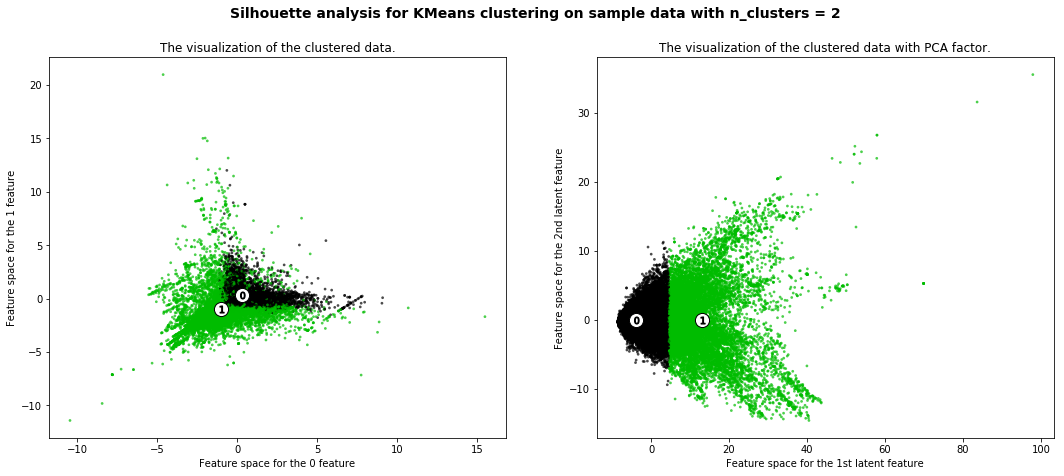

Building K-means clusters| k=3| 2018-02-08 10:24:41 
	Calculatin silhoute score... 2018-02-08 10:24:47
	For k = 3 The average silhouette_score is 0.34931501746177673



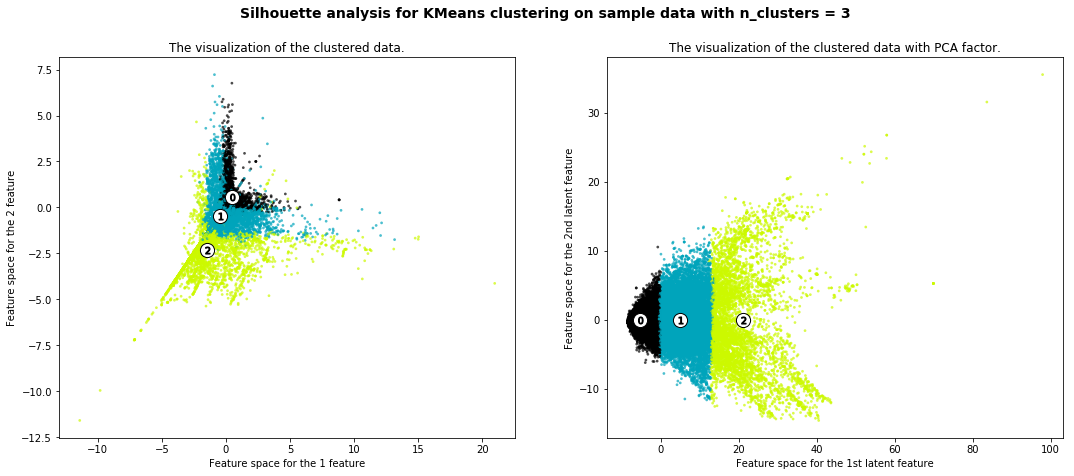

Building K-means clusters| k=4| 2018-02-08 10:24:54 
	Calculatin silhoute score... 2018-02-08 10:25:00
	For k = 4 The average silhouette_score is 0.28568923473358154



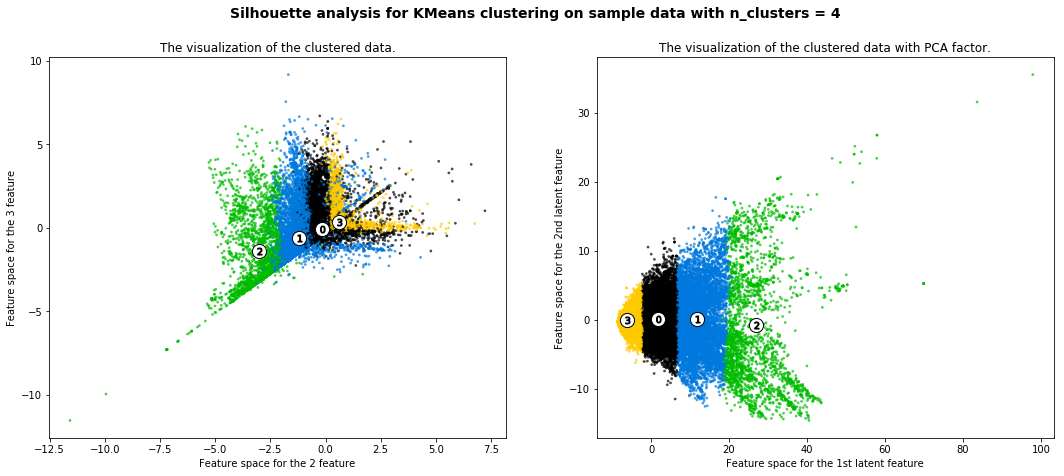

Building K-means clusters| k=5| 2018-02-08 10:25:07 
	Calculatin silhoute score... 2018-02-08 10:25:13
	For k = 5 The average silhouette_score is 0.2683422565460205



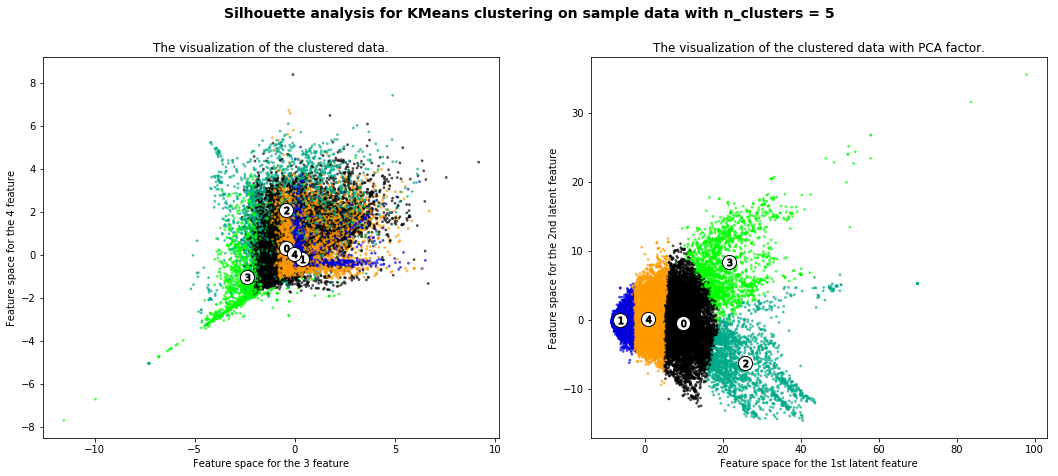

Building K-means clusters| k=6| 2018-02-08 10:25:20 
	Calculatin silhoute score... 2018-02-08 10:25:27
	For k = 6 The average silhouette_score is 0.22269979119300842



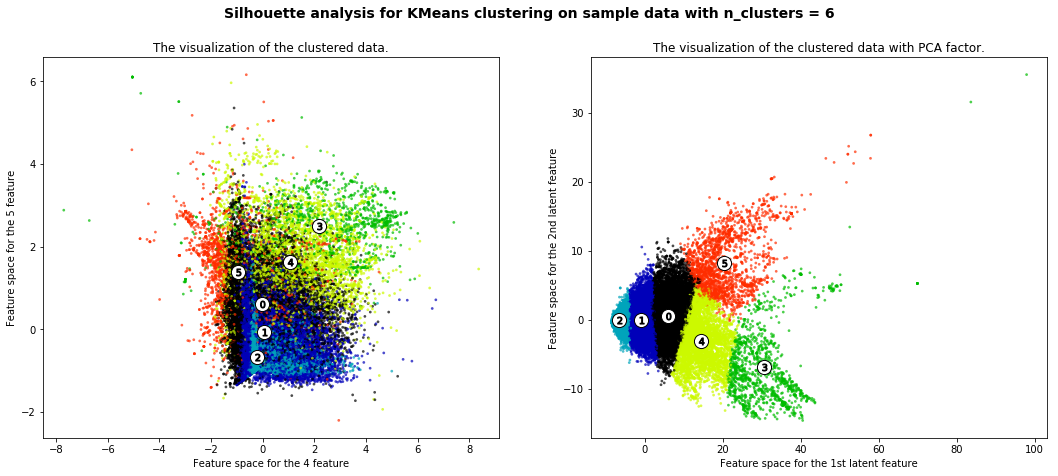

Building K-means clusters| k=7| 2018-02-08 10:25:34 
	Calculatin silhoute score... 2018-02-08 10:25:41
	For k = 7 The average silhouette_score is 0.21179857850074768



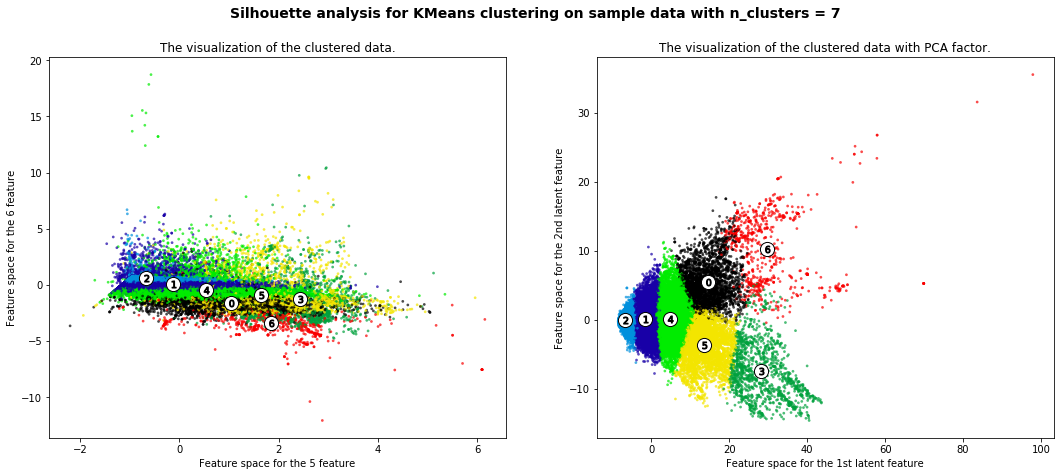

Building K-means clusters| k=8| 2018-02-08 10:25:48 
	Calculatin silhoute score... 2018-02-08 10:25:57
	For k = 8 The average silhouette_score is 0.2144303172826767



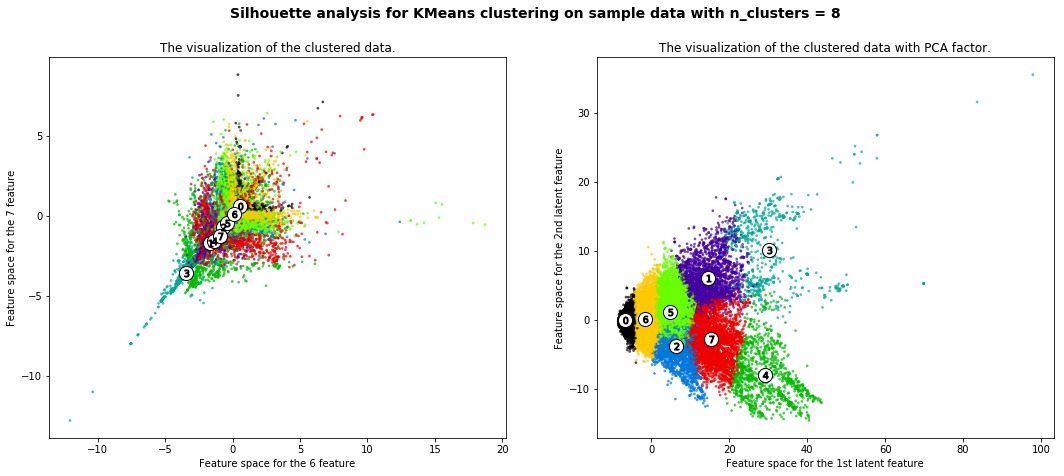

Building K-means clusters| k=9| 2018-02-08 10:26:04 
	Calculatin silhoute score... 2018-02-08 10:26:11
	For k = 9 The average silhouette_score is 0.21211493015289307



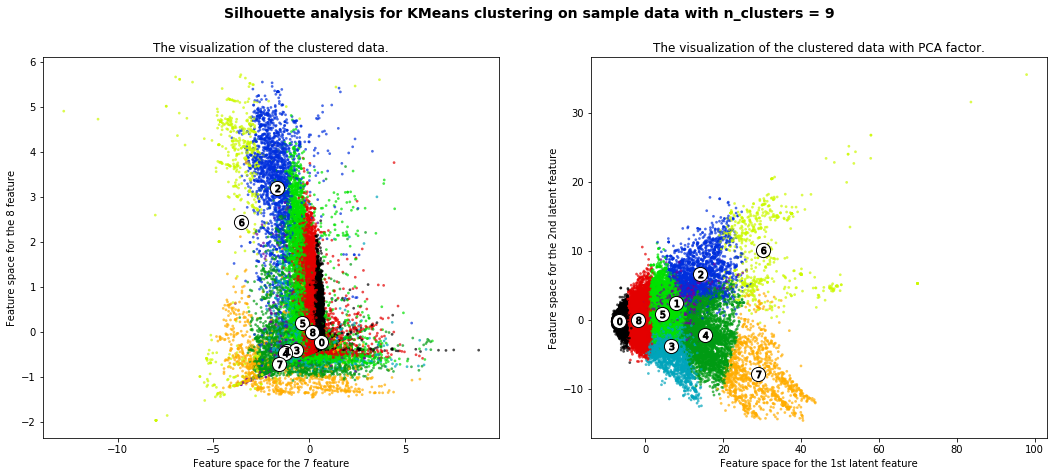

Building K-means clusters| k=10| 2018-02-08 10:26:18 
	Calculatin silhoute score... 2018-02-08 10:26:26
	For k = 10 The average silhouette_score is 0.21112757921218872



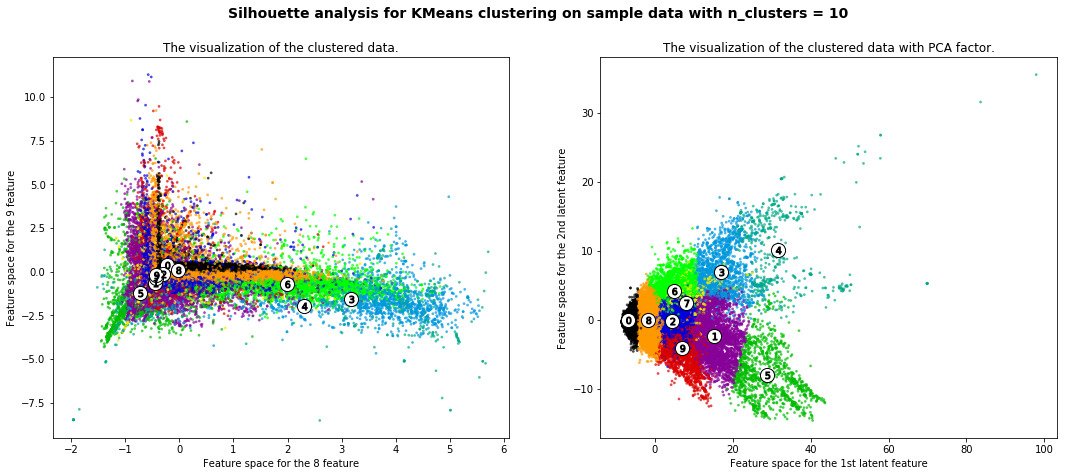

In [12]:
max_clusters = 10
range_n_clusters = range(2,max_clusters+1)

X = dest.values

pca = PCA(n_components=max_clusters)
Xp = pca.fit_transform(X)
print(Xp.shape)
print(X.shape)

for n_clusters in range_n_clusters:
    print("Building K-means clusters| k={0}| {1} ".format(n_clusters, strftime("%Y-%m-%d %H:%M:%S", localtime())))
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 47 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=47, n_jobs=-1).fit(X)
    cluster_labels = clusterer.labels_
    # Labeling the clusters
    centers = clusterer.cluster_centers_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    print("\tCalculatin silhoute score... {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=12000, random_state=47)
    print("\tFor k = {0} The average silhouette_score is {1}\n".format(n_clusters, silhouette_avg))

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax1.scatter(X[:, n_clusters-2], X[:, n_clusters-1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    
    # Draw white circles at cluster centers
    ax1.scatter(centers[:, n_clusters-2], centers[:, n_clusters-1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax1.scatter(c[n_clusters-2], c[n_clusters-1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax1.set_title("The visualization of the clustered data.")
    ax1.set_xlabel("Feature space for the {0} feature".format(n_clusters-2))
    ax1.set_ylabel("Feature space for the {0} feature".format(n_clusters-1))

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Xp[:, 0], Xp[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    p_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(p_centers[:, 0], p_centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(p_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data with PCA factor.")
    ax2.set_xlabel("Feature space for the 1st latent feature")
    ax2.set_ylabel("Feature space for the 2nd latent feature")

    
    plt.show()


I've decided to choose 8 clusters separation for segmentation of *srch_destination_id*

In [68]:
segment_var_name = 'srch_destination_id'
n_clusters = 30
X = dest.values
clusterer = KMeans(n_clusters=n_clusters, random_state=47, n_jobs=-1).fit(X)
cluster_labels = clusterer.labels_
cluster_segm = {}
for i in range(n_clusters):
    cluster_segm[i] = dest.index.values[cluster_labels == i].tolist()
cluster_segm['all'] = dest.index.tolist()
       
param_grid = {'ALS':{'factors': [50, 100],
              'regularization': [1e1, 1e2],
              'iterations': [15, 30, 50]},
              'Events_cnt': [4, 10, 30]}

#%env OPENBLAS_NUM_THREADS=1
base_als = AlternatingLeastSquares()
#%env OPENBLAS_NUM_THREADS=8
base_model = {'ALS': base_als}

curves = grid_search_learning_curve(base_model, train, valid, param_grid, segment_var_name, segments=cluster_segm, score_dict=score_dict) 


Discarding low count events: 4
	Train high events DF shape: (36078622, 10)

*** ALS: factors: 50 | regularization: 10.0 | iterations: 15***

	Working with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, '...']. len=1565| 	*** 2018-03-03 12:03:49 ***
	Sample shape: (1581984, 10)
	Matrix sparsity is 96.36996540761905% |	Matrix size: (265037, 92)
	Started ALS at 2018-03-03 12:03:54
	Finished ALS at 2018-03-03 12:03:58

	Working with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=16871| 	*** 2018-03-03 12:04:46 ***
	Sample shape: (227029, 10)
	Matrix sparsity is 97.73538250711371% |	Matrix size: (71310, 79)
	Started ALS at 2018-03-03 12:04:50
	Finished ALS at 2018-03-03 12:04:51

	Working with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, '...']. len=622| 	*** 2018-03-03 12:05:04 ***
	Sample shape: (1259722, 10)
	Matrix sparsity is 95.78922047557276% |	Matrix size: (199308, 88)
	Started ALS at 2018-03-03 12:05:09
	Finished ALS at 2018-03-03 12:05:1

	Finished ALS at 2018-03-03 12:19:34

	Working with segment 28: |srch_destination_id in [118, 181, 189, 206, 258, '...']. len=2002| 	*** 2018-03-03 12:20:28 ***
	Sample shape: (1249806, 10)
	Matrix sparsity is 96.2914739965194% |	Matrix size: (181669, 95)
	Started ALS at 2018-03-03 12:20:33
	Finished ALS at 2018-03-03 12:20:36

	Working with segment 29: |srch_destination_id in [50, 94, 108, 132, 348, '...']. len=732| 	*** 2018-03-03 12:21:06 ***
	Sample shape: (638407, 10)
	Matrix sparsity is 96.40543081203509% |	Matrix size: (112486, 93)
	Started ALS at 2018-03-03 12:21:11
	Finished ALS at 2018-03-03 12:21:12

	Working with segment all: |srch_destination_id in [0, 1, 2, 3, 4, '...']. len=62106| 	*** 2018-03-03 12:21:31 ***
	Sample shape: (35918769, 10)
	Matrix sparsity is 86.00790145080184% |	Matrix size: (1013991, 100)
	Started ALS at 2018-03-03 12:22:02
	Finished ALS at 2018-03-03 12:22:37
	Scoring with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, '...']. len=1565| 	**

	Matrix sparsity is 95.78922047557276% |	Matrix size: (199308, 88)
	Started ALS at 2018-03-03 12:27:17
	Finished ALS at 2018-03-03 12:27:22

	Working with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, '...']. len=1123| 	*** 2018-03-03 12:27:55 ***
	Sample shape: (2465813, 10)
	Matrix sparsity is 95.10891434517771% |	Matrix size: (299664, 96)
	Started ALS at 2018-03-03 12:28:02
	Finished ALS at 2018-03-03 12:28:11

	Working with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, '...']. len=177| 	*** 2018-03-03 12:29:02 ***
	Sample shape: (1970098, 10)
	Matrix sparsity is 95.95806627271867% |	Matrix size: (235445, 81)
	Started ALS at 2018-03-03 12:29:07
	Finished ALS at 2018-03-03 12:29:13

	Working with segment 5: |srch_destination_id in [250, 1588, 1901, 5958, 7792, '...']. len=159| 	*** 2018-03-03 12:29:53 ***
	Sample shape: (180948, 10)
	Matrix sparsity is 95.99907837742792% |	Matrix size: (32359, 79)
	Started ALS at 2018-03-03 12:29:57
	Finished ALS at 201

	Finished ALS at 2018-03-03 12:46:26
	Scoring with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, '...']. len=1565| 	*** 2018-03-03 12:49:19 ***
		Sample size: 44257
		MAP@5 of set #0 scored using ALS is 0.3672552870090634
	Scoring with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=16871| 	*** 2018-03-03 12:49:19 ***
		Sample size: 6229
		MAP@5 of set #1 scored using ALS is 0.561467944168441
	Scoring with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, '...']. len=622| 	*** 2018-03-03 12:49:19 ***
		Sample size: 34975
		MAP@5 of set #2 scored using ALS is 0.3252937028418306
	Scoring with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, '...']. len=1123| 	*** 2018-03-03 12:49:20 ***
		Sample size: 68619
		MAP@5 of set #3 scored using ALS is 0.24776877277524445
	Scoring with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, '...']. len=177| 	*** 2018-03-03 12:49:20 ***
		Sample size: 54929
		MAP@5 of set #4 scored using ALS

	Finished ALS at 2018-03-03 12:54:19

	Working with segment 6: |srch_destination_id in [7, 25, 60, 66, 72, '...']. len=4090| 	*** 2018-03-03 12:54:25 ***
	Sample shape: (1207033, 10)
	Matrix sparsity is 96.94096384401944% |	Matrix size: (233812, 94)
	Started ALS at 2018-03-03 12:54:30
	Finished ALS at 2018-03-03 12:54:40

	Working with segment 7: |srch_destination_id in [1223, 3072, 3903, 4037, 4454, '...']. len=190| 	*** 2018-03-03 12:55:24 ***
	Sample shape: (1094701, 10)
	Matrix sparsity is 95.18882290239074% |	Matrix size: (131340, 87)
	Started ALS at 2018-03-03 12:55:29
	Finished ALS at 2018-03-03 12:55:35

	Working with segment 8: |srch_destination_id in [4, 15, 30, 31, 36, '...']. len=11222| 	*** 2018-03-03 12:56:00 ***
	Sample shape: (797833, 10)
	Matrix sparsity is 96.90102248567909% |	Matrix size: (160815, 87)
	Started ALS at 2018-03-03 12:56:05
	Finished ALS at 2018-03-03 12:56:11

	Working with segment 9: |srch_destination_id in [1487, 1875, 1881, 7229, 7699, '...']. len=26

		MAP@5 of set #4 scored using ALS is 0.5066373508904058
	Scoring with segment 5: |srch_destination_id in [250, 1588, 1901, 5958, 7792, '...']. len=159| 	*** 2018-03-03 13:17:12 ***
		Sample size: 5129
		MAP@5 of set #5 scored using ALS is 0.3945405982905983
	Scoring with segment 6: |srch_destination_id in [7, 25, 60, 66, 72, '...']. len=4090| 	*** 2018-03-03 13:17:12 ***
		Sample size: 33881
		MAP@5 of set #6 scored using ALS is 0.41822612940471493
	Scoring with segment 7: |srch_destination_id in [1223, 3072, 3903, 4037, 4454, '...']. len=190| 	*** 2018-03-03 13:17:12 ***
		Sample size: 30270
		MAP@5 of set #7 scored using ALS is 0.3446205549403224
	Scoring with segment 8: |srch_destination_id in [4, 15, 30, 31, 36, '...']. len=11222| 	*** 2018-03-03 13:17:12 ***
		Sample size: 22182
		MAP@5 of set #8 scored using ALS is 0.43325947576843293
	Scoring with segment 9: |srch_destination_id in [1487, 1875, 1881, 7229, 7699, '...']. len=267| 	*** 2018-03-03 13:17:13 ***
		Sample size: 10046

	Finished ALS at 2018-03-03 13:23:21

	Working with segment 9: |srch_destination_id in [1487, 1875, 1881, 7229, 7699, '...']. len=267| 	*** 2018-03-03 13:23:51 ***
	Sample shape: (362923, 10)
	Matrix sparsity is 95.33232275369372% |	Matrix size: (65690, 71)
	Started ALS at 2018-03-03 13:23:55
	Finished ALS at 2018-03-03 13:23:56

	Working with segment 10: |srch_destination_id in [55, 103, 110, 199, 326, '...']. len=763| 	*** 2018-03-03 13:24:08 ***
	Sample shape: (997227, 10)
	Matrix sparsity is 96.24359036665456% |	Matrix size: (179577, 88)
	Started ALS at 2018-03-03 13:24:13
	Finished ALS at 2018-03-03 13:24:16

	Working with segment 11: |srch_destination_id in [4752, 5576, 8791, 10871, 11439, '...']. len=104| 	*** 2018-03-03 13:24:49 ***
	Sample shape: (964852, 10)
	Matrix sparsity is 95.63807363570734% |	Matrix size: (112201, 72)
	Started ALS at 2018-03-03 13:24:53
	Finished ALS at 2018-03-03 13:24:55

	Working with segment 12: |srch_destination_id in [226, 277, 395, 509, 707, '...

	Scoring with segment 10: |srch_destination_id in [55, 103, 110, 199, 326, '...']. len=763| 	*** 2018-03-03 13:40:57 ***
		Sample size: 27677
		MAP@5 of set #10 scored using ALS is 0.35653929714579496
	Scoring with segment 11: |srch_destination_id in [4752, 5576, 8791, 10871, 11439, '...']. len=104| 	*** 2018-03-03 13:40:57 ***
		Sample size: 26746
		MAP@5 of set #11 scored using ALS is 0.542837698768383
	Scoring with segment 12: |srch_destination_id in [226, 277, 395, 509, 707, '...']. len=1068| 	*** 2018-03-03 13:40:58 ***
		Sample size: 52201
		MAP@5 of set #12 scored using ALS is 0.3365310490333313
	Scoring with segment 13: |srch_destination_id in [23, 33, 44, 47, 85, '...']. len=2958| 	*** 2018-03-03 13:40:58 ***
		Sample size: 18171
		MAP@5 of set #13 scored using ALS is 0.34590085031285095
	Scoring with segment 14: |srch_destination_id in [154, 278, 511, 513, 669, '...']. len=521| 	*** 2018-03-03 13:40:58 ***
		Sample size: 39342
		MAP@5 of set #14 scored using ALS is 0.34853634

	Sample shape: (1884346, 10)
	Matrix sparsity is 95.98798182432134% |	Matrix size: (274479, 95)
	Started ALS at 2018-03-03 13:49:50
	Finished ALS at 2018-03-03 13:49:59

	Working with segment 13: |srch_destination_id in [23, 33, 44, 47, 85, '...']. len=2958| 	*** 2018-03-03 13:50:50 ***
	Sample shape: (647936, 10)
	Matrix sparsity is 96.53880153038244% |	Matrix size: (112245, 90)
	Started ALS at 2018-03-03 13:50:55
	Finished ALS at 2018-03-03 13:50:58

	Working with segment 14: |srch_destination_id in [154, 278, 511, 513, 669, '...']. len=521| 	*** 2018-03-03 13:51:19 ***
	Sample shape: (1420798, 10)
	Matrix sparsity is 95.73983288999794% |	Matrix size: (186150, 93)
	Started ALS at 2018-03-03 13:51:24
	Finished ALS at 2018-03-03 13:51:29

	Working with segment 15: |srch_destination_id in [2, 11, 57, 64, 91, '...']. len=1587| 	*** 2018-03-03 13:52:04 ***
	Sample shape: (694072, 10)
	Matrix sparsity is 97.11706164283899% |	Matrix size: (151121, 91)
	Started ALS at 2018-03-03 13:52:09
	Fi

		MAP@5 of set #14 scored using ALS is 0.34856923582940474
	Scoring with segment 15: |srch_destination_id in [2, 11, 57, 64, 91, '...']. len=1587| 	*** 2018-03-03 14:07:56 ***
		Sample size: 19015
		MAP@5 of set #15 scored using ALS is 0.42578684142450635
	Scoring with segment 16: |srch_destination_id in [0, 8, 16, 19, 24, '...']. len=5800| 	*** 2018-03-03 14:07:56 ***
		Sample size: 32545
		MAP@5 of set #16 scored using ALS is 0.4449678180219077
	Scoring with segment 17: |srch_destination_id in [56, 102, 134, 142, 150, '...']. len=982| 	*** 2018-03-03 14:07:57 ***
		Sample size: 84271
		MAP@5 of set #17 scored using ALS is 0.28612106331270515
	Scoring with segment 18: |srch_destination_id in [18, 21, 76, 114, 214, '...']. len=620| 	*** 2018-03-03 14:07:57 ***
		Sample size: 36919
		MAP@5 of set #18 scored using ALS is 0.3334328384968446
	Scoring with segment 19: |srch_destination_id in [107, 383, 542, 958, 1004, '...']. len=267| 	*** 2018-03-03 14:07:58 ***
		Sample size: 36678
		MAP@

	Finished ALS at 2018-03-03 14:19:33

	Working with segment 16: |srch_destination_id in [0, 8, 16, 19, 24, '...']. len=5800| 	*** 2018-03-03 14:19:59 ***
	Sample shape: (1171545, 10)
	Matrix sparsity is 96.8232206976979% |	Matrix size: (219498, 91)
	Started ALS at 2018-03-03 14:20:05
	Finished ALS at 2018-03-03 14:20:15

	Working with segment 17: |srch_destination_id in [56, 102, 134, 142, 150, '...']. len=982| 	*** 2018-03-03 14:20:54 ***
	Sample shape: (3044388, 10)
	Matrix sparsity is 94.18220979988783% |	Matrix size: (291503, 91)
	Started ALS at 2018-03-03 14:21:01
	Finished ALS at 2018-03-03 14:21:20

	Working with segment 18: |srch_destination_id in [18, 21, 76, 114, 214, '...']. len=620| 	*** 2018-03-03 14:22:14 ***
	Sample shape: (1338166, 10)
	Matrix sparsity is 95.80027523258914% |	Matrix size: (170960, 93)
	Started ALS at 2018-03-03 14:22:19
	Finished ALS at 2018-03-03 14:22:28

	Working with segment 19: |srch_destination_id in [107, 383, 542, 958, 1004, '...']. len=267| 	**

		MAP@5 of set #19 scored using ALS is 0.45011964669036136
	Scoring with segment 20: |srch_destination_id in [28, 111, 157, 239, 245, '...']. len=2176| 	*** 2018-03-03 14:36:11 ***
		Sample size: 55246
		MAP@5 of set #20 scored using ALS is 0.3373433770883055
	Scoring with segment 21: |srch_destination_id in [1481, 1883, 3744, 4576, 4774, '...']. len=157| 	*** 2018-03-03 14:36:12 ***
		Sample size: 6628
		MAP@5 of set #21 scored using ALS is 0.3966685089658561
	Scoring with segment 22: |srch_destination_id in [1187, 1770, 7635, 8267, 12233, '...']. len=210| 	*** 2018-03-03 14:36:12 ***
		Sample size: 39991
		MAP@5 of set #22 scored using ALS is 0.4068066585015737
	Scoring with segment 23: |srch_destination_id in [210, 307, 1483, 8223, 12190, '...']. len=163| 	*** 2018-03-03 14:36:13 ***
		Sample size: 6102
		MAP@5 of set #23 scored using ALS is 0.3902659185167114
	Scoring with segment 24: |srch_destination_id in [53, 329, 412, 595, 639, '...']. len=525| 	*** 2018-03-03 14:36:13 ***
		S

	Sample shape: (1324483, 10)
	Matrix sparsity is 95.69724078819861% |	Matrix size: (151238, 86)
	Started ALS at 2018-03-03 14:50:25
	Finished ALS at 2018-03-03 14:50:29

	Working with segment 20: |srch_destination_id in [28, 111, 157, 239, 245, '...']. len=2176| 	*** 2018-03-03 14:50:57 ***
	Sample shape: (2001222, 10)
	Matrix sparsity is 96.15632915108463% |	Matrix size: (310158, 95)
	Started ALS at 2018-03-03 14:51:03
	Finished ALS at 2018-03-03 14:51:11

	Working with segment 21: |srch_destination_id in [1481, 1883, 3744, 4576, 4774, '...']. len=157| 	*** 2018-03-03 14:52:09 ***
	Sample shape: (237507, 10)
	Matrix sparsity is 96.24161085878585% |	Matrix size: (40743, 82)
	Started ALS at 2018-03-03 14:52:13
	Finished ALS at 2018-03-03 14:52:14

	Working with segment 22: |srch_destination_id in [1187, 1770, 7635, 8267, 12233, '...']. len=210| 	*** 2018-03-03 14:52:22 ***
	Sample shape: (1454142, 10)
	Matrix sparsity is 94.27385263831697% |	Matrix size: (161566, 69)
	Started ALS at 201

	Scoring with segment 25: |srch_destination_id in [9850, 12159, 12638, 21531, 22583, '...']. len=19| 	*** 2018-03-03 15:01:21 ***
		Sample size: 11
		MAP@5 of set #25 scored using ALS is 0.8055555555555557
	Scoring with segment 26: |srch_destination_id in [14, 27, 34, 39, 40, '...']. len=2893| 	*** 2018-03-03 15:01:22 ***
		Sample size: 25379
		MAP@5 of set #26 scored using ALS is 0.44906766628219913
	Scoring with segment 27: |srch_destination_id in [37, 38, 54, 146, 179, '...']. len=2273| 	*** 2018-03-03 15:01:22 ***
		Sample size: 107340
		MAP@5 of set #27 scored using ALS is 0.295807881320902
	Scoring with segment 28: |srch_destination_id in [118, 181, 189, 206, 258, '...']. len=2002| 	*** 2018-03-03 15:01:23 ***
		Sample size: 34866
		MAP@5 of set #28 scored using ALS is 0.3799553092152897
	Scoring with segment 29: |srch_destination_id in [50, 94, 108, 132, 348, '...']. len=732| 	*** 2018-03-03 15:01:23 ***
		Sample size: 17536
		MAP@5 of set #29 scored using ALS is 0.3486878020684

	Finished ALS at 2018-03-03 15:17:51

	Working with segment 23: |srch_destination_id in [210, 307, 1483, 8223, 12190, '...']. len=163| 	*** 2018-03-03 15:18:19 ***
	Sample shape: (220420, 10)
	Matrix sparsity is 95.67546119825217% |	Matrix size: (44290, 68)
	Started ALS at 2018-03-03 15:18:23
	Finished ALS at 2018-03-03 15:18:25

	Working with segment 24: |srch_destination_id in [53, 329, 412, 595, 639, '...']. len=525| 	*** 2018-03-03 15:18:32 ***
	Sample shape: (673444, 10)
	Matrix sparsity is 96.15900093187794% |	Matrix size: (104115, 89)
	Started ALS at 2018-03-03 15:18:37
	Finished ALS at 2018-03-03 15:18:41

	Working with segment 25: |srch_destination_id in [9850, 12159, 12638, 21531, 22583, '...']. len=19| 	*** 2018-03-03 15:18:59 ***
	Sample shape: (247, 10)
	Matrix sparsity is 94.56521739130434% |	Matrix size: (124, 23)
	Started ALS at 2018-03-03 15:19:00
	Finished ALS at 2018-03-03 15:19:00

	Working with segment 26: |srch_destination_id in [14, 27, 34, 39, 40, '...']. len=28

	Scoring with segment all: |srch_destination_id in [0, 1, 2, 3, 4, '...']. len=62106| 	*** 2018-03-03 15:28:16 ***
	*** MAP@5 of set 975107 records scored using ALS is 0.29289153224552117 ***
	Scoring with Dict  *** 2018-03-03 15:28:23 ***
{'total': 24893, 'total0': 2963, 'total1': 64066, 'total00': 40, 'total2': 56403, 'total3': 985, 'total4': 8}
	*** MAP@5 of set 24893 records scored using Dict preferences is 0.5286305387056603 ***
	*** MAP@5 of Validation set is 0.2987597833333334 ***

*** ALS: factors: 100 | regularization: 10.0 | iterations: 50***

	Working with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, '...']. len=1565| 	*** 2018-03-03 15:28:35 ***
	Sample shape: (1581984, 10)
	Matrix sparsity is 96.36996540761905% |	Matrix size: (265037, 92)
	Started ALS at 2018-03-03 15:28:41
	Finished ALS at 2018-03-03 15:29:02

	Working with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=16871| 	*** 2018-03-03 15:29:51 ***
	Sample shape: (227029, 10)
	Matrix s

	Sample shape: (914946, 10)
	Matrix sparsity is 96.81969320887667% |	Matrix size: (169740, 91)
	Started ALS at 2018-03-03 15:49:20
	Finished ALS at 2018-03-03 15:49:32

	Working with segment 27: |srch_destination_id in [37, 38, 54, 146, 179, '...']. len=2273| 	*** 2018-03-03 15:50:04 ***
	Sample shape: (3892731, 10)
	Matrix sparsity is 93.81062260608134% |	Matrix size: (318740, 93)
	Started ALS at 2018-03-03 15:50:12
	Finished ALS at 2018-03-03 15:50:44

	Working with segment 28: |srch_destination_id in [118, 181, 189, 206, 258, '...']. len=2002| 	*** 2018-03-03 15:51:45 ***
	Sample shape: (1249806, 10)
	Matrix sparsity is 96.2914739965194% |	Matrix size: (181669, 95)
	Started ALS at 2018-03-03 15:51:51
	Finished ALS at 2018-03-03 15:52:04

	Working with segment 29: |srch_destination_id in [50, 94, 108, 132, 348, '...']. len=732| 	*** 2018-03-03 15:52:39 ***
	Sample shape: (638407, 10)
	Matrix sparsity is 96.40543081203509% |	Matrix size: (112486, 93)
	Started ALS at 2018-03-03 15:52:4


	Working with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=16871| 	*** 2018-03-03 16:01:52 ***
	Sample shape: (227029, 10)
	Matrix sparsity is 97.73538250711371% |	Matrix size: (71310, 79)
	Started ALS at 2018-03-03 16:01:56
	Finished ALS at 2018-03-03 16:01:57

	Working with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, '...']. len=622| 	*** 2018-03-03 16:02:12 ***
	Sample shape: (1259722, 10)
	Matrix sparsity is 95.78922047557276% |	Matrix size: (199308, 88)
	Started ALS at 2018-03-03 16:02:18
	Finished ALS at 2018-03-03 16:02:23

	Working with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, '...']. len=1123| 	*** 2018-03-03 16:03:02 ***
	Sample shape: (2465813, 10)
	Matrix sparsity is 95.10891434517771% |	Matrix size: (299664, 96)
	Started ALS at 2018-03-03 16:03:08
	Finished ALS at 2018-03-03 16:03:17

	Working with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, '...']. len=177| 	*** 2018-03-03 16:04:14 ***
	Sample shape:

	Sample shape: (638407, 10)
	Matrix sparsity is 96.40543081203509% |	Matrix size: (112486, 93)
	Started ALS at 2018-03-03 16:20:59
	Finished ALS at 2018-03-03 16:21:01

	Working with segment all: |srch_destination_id in [0, 1, 2, 3, 4, '...']. len=62106| 	*** 2018-03-03 16:21:21 ***
	Sample shape: (35918769, 10)
	Matrix sparsity is 86.00790145080184% |	Matrix size: (1013991, 100)
	Started ALS at 2018-03-03 16:21:52
	Finished ALS at 2018-03-03 16:22:44
	Scoring with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, '...']. len=1565| 	*** 2018-03-03 16:25:51 ***
		Sample size: 44257
		MAP@5 of set #0 scored using ALS is 0.3773111782477341
	Scoring with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=16871| 	*** 2018-03-03 16:25:52 ***
		Sample size: 6229
		MAP@5 of set #1 scored using ALS is 0.5498935415188076
	Scoring with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, '...']. len=622| 	*** 2018-03-03 16:25:52 ***
		Sample size: 34975
		MAP@5 of set 

	Sample shape: (1970098, 10)
	Matrix sparsity is 95.95806627271867% |	Matrix size: (235445, 81)
	Started ALS at 2018-03-03 16:30:07
	Finished ALS at 2018-03-03 16:30:17

	Working with segment 5: |srch_destination_id in [250, 1588, 1901, 5958, 7792, '...']. len=159| 	*** 2018-03-03 16:31:00 ***
	Sample shape: (180948, 10)
	Matrix sparsity is 95.99907837742792% |	Matrix size: (32359, 79)
	Started ALS at 2018-03-03 16:31:04
	Finished ALS at 2018-03-03 16:31:06

	Working with segment 6: |srch_destination_id in [7, 25, 60, 66, 72, '...']. len=4090| 	*** 2018-03-03 16:31:12 ***
	Sample shape: (1207033, 10)
	Matrix sparsity is 96.94096384401944% |	Matrix size: (233812, 94)
	Started ALS at 2018-03-03 16:31:17
	Finished ALS at 2018-03-03 16:31:27

	Working with segment 7: |srch_destination_id in [1223, 3072, 3903, 4037, 4454, '...']. len=190| 	*** 2018-03-03 16:32:11 ***
	Sample shape: (1094701, 10)
	Matrix sparsity is 95.18882290239074% |	Matrix size: (131340, 87)
	Started ALS at 2018-03-03 16

		MAP@5 of set #2 scored using ALS is 0.3315288061490727
	Scoring with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, '...']. len=1123| 	*** 2018-03-03 16:52:56 ***
		Sample size: 68619
		MAP@5 of set #3 scored using ALS is 0.27290368187339453
	Scoring with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, '...']. len=177| 	*** 2018-03-03 16:52:57 ***
		Sample size: 54929
		MAP@5 of set #4 scored using ALS is 0.5078630256796481
	Scoring with segment 5: |srch_destination_id in [250, 1588, 1901, 5958, 7792, '...']. len=159| 	*** 2018-03-03 16:52:57 ***
		Sample size: 5129
		MAP@5 of set #5 scored using ALS is 0.357184829059829
	Scoring with segment 6: |srch_destination_id in [7, 25, 60, 66, 72, '...']. len=4090| 	*** 2018-03-03 16:52:57 ***
		Sample size: 33881
		MAP@5 of set #6 scored using ALS is 0.4302399847999883
	Scoring with segment 7: |srch_destination_id in [1223, 3072, 3903, 4037, 4454, '...']. len=190| 	*** 2018-03-03 16:52:58 ***
		Sample size: 30270


	Sample shape: (1094701, 10)
	Matrix sparsity is 95.18882290239074% |	Matrix size: (131340, 87)
	Started ALS at 2018-03-03 16:59:30
	Finished ALS at 2018-03-03 16:59:39

	Working with segment 8: |srch_destination_id in [4, 15, 30, 31, 36, '...']. len=11222| 	*** 2018-03-03 17:00:02 ***
	Sample shape: (797833, 10)
	Matrix sparsity is 96.90102248567909% |	Matrix size: (160815, 87)
	Started ALS at 2018-03-03 17:00:07
	Finished ALS at 2018-03-03 17:00:16

	Working with segment 9: |srch_destination_id in [1487, 1875, 1881, 7229, 7699, '...']. len=267| 	*** 2018-03-03 17:00:44 ***
	Sample shape: (362923, 10)
	Matrix sparsity is 95.33232275369372% |	Matrix size: (65690, 71)
	Started ALS at 2018-03-03 17:00:48
	Finished ALS at 2018-03-03 17:00:52

	Working with segment 10: |srch_destination_id in [55, 103, 110, 199, 326, '...']. len=763| 	*** 2018-03-03 17:01:04 ***
	Sample shape: (997227, 10)
	Matrix sparsity is 96.24359036665456% |	Matrix size: (179577, 88)
	Started ALS at 2018-03-03 17:01:0

	Scoring with segment 8: |srch_destination_id in [4, 15, 30, 31, 36, '...']. len=11222| 	*** 2018-03-03 17:22:34 ***
		Sample size: 22182
		MAP@5 of set #8 scored using ALS is 0.43975265572946126
	Scoring with segment 9: |srch_destination_id in [1487, 1875, 1881, 7229, 7699, '...']. len=267| 	*** 2018-03-03 17:22:34 ***
		Sample size: 10046
		MAP@5 of set #9 scored using ALS is 0.3488440190551112
	Scoring with segment 10: |srch_destination_id in [55, 103, 110, 199, 326, '...']. len=763| 	*** 2018-03-03 17:22:34 ***
		Sample size: 27677
		MAP@5 of set #10 scored using ALS is 0.3569547407002006
	Scoring with segment 11: |srch_destination_id in [4752, 5576, 8791, 10871, 11439, '...']. len=104| 	*** 2018-03-03 17:22:35 ***
		Sample size: 26746
		MAP@5 of set #11 scored using ALS is 0.5430177937124456
	Scoring with segment 12: |srch_destination_id in [226, 277, 395, 509, 707, '...']. len=1068| 	*** 2018-03-03 17:22:35 ***
		Sample size: 52201
		MAP@5 of set #12 scored using ALS is 0.3396100

	Finished ALS at 2018-03-03 17:28:30

	Working with segment 11: |srch_destination_id in [4752, 5576, 8791, 10871, 11439, '...']. len=104| 	*** 2018-03-03 17:28:57 ***
	Sample shape: (918767, 10)
	Matrix sparsity is 95.37208171206227% |	Matrix size: (97660, 72)
	Started ALS at 2018-03-03 17:29:02
	Finished ALS at 2018-03-03 17:29:03

	Working with segment 12: |srch_destination_id in [226, 277, 395, 509, 707, '...']. len=1068| 	*** 2018-03-03 17:29:20 ***
	Sample shape: (1774444, 10)
	Matrix sparsity is 95.7041718614709% |	Matrix size: (237670, 95)
	Started ALS at 2018-03-03 17:29:25
	Finished ALS at 2018-03-03 17:29:29

	Working with segment 13: |srch_destination_id in [23, 33, 44, 47, 85, '...']. len=2958| 	*** 2018-03-03 17:30:11 ***
	Sample shape: (612286, 10)
	Matrix sparsity is 96.3763841992824% |	Matrix size: (99807, 90)
	Started ALS at 2018-03-03 17:30:15
	Finished ALS at 2018-03-03 17:30:16

	Working with segment 14: |srch_destination_id in [154, 278, 511, 513, 669, '...']. len=

		MAP@5 of set #12 scored using ALS is 0.3153371981302156
	Scoring with segment 13: |srch_destination_id in [23, 33, 44, 47, 85, '...']. len=2958| 	*** 2018-03-03 17:42:01 ***
		Sample size: 18171
		MAP@5 of set #13 scored using ALS is 0.3472801120448179
	Scoring with segment 14: |srch_destination_id in [154, 278, 511, 513, 669, '...']. len=521| 	*** 2018-03-03 17:42:01 ***
		Sample size: 39342
		MAP@5 of set #14 scored using ALS is 0.3330964001652722
	Scoring with segment 15: |srch_destination_id in [2, 11, 57, 64, 91, '...']. len=1587| 	*** 2018-03-03 17:42:02 ***
		Sample size: 19015
		MAP@5 of set #15 scored using ALS is 0.4065968017388604
	Scoring with segment 16: |srch_destination_id in [0, 8, 16, 19, 24, '...']. len=5800| 	*** 2018-03-03 17:42:02 ***
		Sample size: 32545
		MAP@5 of set #16 scored using ALS is 0.41946896951730356
	Scoring with segment 17: |srch_destination_id in [56, 102, 134, 142, 150, '...']. len=982| 	*** 2018-03-03 17:42:02 ***
		Sample size: 84271
		MAP@5 of

	Sample shape: (1339684, 10)
	Matrix sparsity is 95.44154335439613% |	Matrix size: (160738, 93)
	Started ALS at 2018-03-03 17:50:33
	Finished ALS at 2018-03-03 17:50:37

	Working with segment 15: |srch_destination_id in [2, 11, 57, 64, 91, '...']. len=1587| 	*** 2018-03-03 17:51:05 ***
	Sample shape: (642780, 10)
	Matrix sparsity is 96.98142280669056% |	Matrix size: (131836, 91)
	Started ALS at 2018-03-03 17:51:09
	Finished ALS at 2018-03-03 17:51:13

	Working with segment 16: |srch_destination_id in [0, 8, 16, 19, 24, '...']. len=5800| 	*** 2018-03-03 17:51:35 ***
	Sample shape: (1092504, 10)
	Matrix sparsity is 96.64269462854311% |	Matrix size: (190651, 91)
	Started ALS at 2018-03-03 17:51:40
	Finished ALS at 2018-03-03 17:51:45

	Working with segment 17: |srch_destination_id in [56, 102, 134, 142, 150, '...']. len=982| 	*** 2018-03-03 17:52:18 ***
	Sample shape: (2894202, 10)
	Matrix sparsity is 93.6281140445509% |	Matrix size: (248393, 91)
	Started ALS at 2018-03-03 17:52:24
	Finis

	Scoring with segment 17: |srch_destination_id in [56, 102, 134, 142, 150, '...']. len=982| 	*** 2018-03-03 18:02:54 ***
		Sample size: 84271
		MAP@5 of set #17 scored using ALS is 0.2531020779720953
	Scoring with segment 18: |srch_destination_id in [18, 21, 76, 114, 214, '...']. len=620| 	*** 2018-03-03 18:02:54 ***
		Sample size: 36919
		MAP@5 of set #18 scored using ALS is 0.32640947316815627
	Scoring with segment 19: |srch_destination_id in [107, 383, 542, 958, 1004, '...']. len=267| 	*** 2018-03-03 18:02:55 ***
		Sample size: 36678
		MAP@5 of set #19 scored using ALS is 0.44954333678449937
	Scoring with segment 20: |srch_destination_id in [28, 111, 157, 239, 245, '...']. len=2176| 	*** 2018-03-03 18:02:55 ***
		Sample size: 55246
		MAP@5 of set #20 scored using ALS is 0.31968388890369226
	Scoring with segment 21: |srch_destination_id in [1481, 1883, 3744, 4576, 4774, '...']. len=157| 	*** 2018-03-03 18:02:56 ***
		Sample size: 6628
		MAP@5 of set #21 scored using ALS is 0.41310127

	Sample shape: (2894202, 10)
	Matrix sparsity is 93.6281140445509% |	Matrix size: (248393, 91)
	Started ALS at 2018-03-03 18:13:53
	Finished ALS at 2018-03-03 18:14:08

	Working with segment 18: |srch_destination_id in [18, 21, 76, 114, 214, '...']. len=620| 	*** 2018-03-03 18:14:51 ***
	Sample shape: (1270013, 10)
	Matrix sparsity is 95.5190397915657% |	Matrix size: (149283, 93)
	Started ALS at 2018-03-03 18:14:56
	Finished ALS at 2018-03-03 18:15:03

	Working with segment 19: |srch_destination_id in [107, 383, 542, 958, 1004, '...']. len=267| 	*** 2018-03-03 18:15:28 ***
	Sample shape: (1260080, 10)
	Matrix sparsity is 95.3782037137854% |	Matrix size: (130587, 86)
	Started ALS at 2018-03-03 18:15:33
	Finished ALS at 2018-03-03 18:15:38

	Working with segment 20: |srch_destination_id in [28, 111, 157, 239, 245, '...']. len=2176| 	*** 2018-03-03 18:16:01 ***
	Sample shape: (1866593, 10)
	Matrix sparsity is 95.86052242611458% |	Matrix size: (264533, 95)
	Started ALS at 2018-03-03 18:16:

		MAP@5 of set #21 scored using ALS is 0.4139040561622465
	Scoring with segment 22: |srch_destination_id in [1187, 1770, 7635, 8267, 12233, '...']. len=210| 	*** 2018-03-03 18:25:35 ***
		Sample size: 39991
		MAP@5 of set #22 scored using ALS is 0.4041343240214188
	Scoring with segment 23: |srch_destination_id in [210, 307, 1483, 8223, 12190, '...']. len=163| 	*** 2018-03-03 18:25:36 ***
		Sample size: 6102
		MAP@5 of set #23 scored using ALS is 0.39523500389509225
	Scoring with segment 24: |srch_destination_id in [53, 329, 412, 595, 639, '...']. len=525| 	*** 2018-03-03 18:25:36 ***
		Sample size: 18472
		MAP@5 of set #24 scored using ALS is 0.3705008354784808
	Scoring with segment 25: |srch_destination_id in [9850, 12159, 12638, 21531, 22583, '...']. len=19| 	*** 2018-03-03 18:25:36 ***
		Sample size: 11
		MAP@5 of set #25 scored using ALS is 0.39999999999999997
	Scoring with segment 26: |srch_destination_id in [14, 27, 34, 39, 40, '...']. len=2893| 	*** 2018-03-03 18:25:36 ***
		Sam

	Finished ALS at 2018-03-03 18:37:14

	Working with segment 21: |srch_destination_id in [1481, 1883, 3744, 4576, 4774, '...']. len=157| 	*** 2018-03-03 18:38:00 ***
	Sample shape: (223563, 10)
	Matrix sparsity is 96.06964137485937% |	Matrix size: (36053, 82)
	Started ALS at 2018-03-03 18:38:04
	Finished ALS at 2018-03-03 18:38:04

	Working with segment 22: |srch_destination_id in [1187, 1770, 7635, 8267, 12233, '...']. len=210| 	*** 2018-03-03 18:38:10 ***
	Sample shape: (1378582, 10)
	Matrix sparsity is 93.88466004386531% |	Matrix size: (139518, 69)
	Started ALS at 2018-03-03 18:38:15
	Finished ALS at 2018-03-03 18:38:17

	Working with segment 23: |srch_destination_id in [210, 307, 1483, 8223, 12190, '...']. len=163| 	*** 2018-03-03 18:38:40 ***
	Sample shape: (205687, 10)
	Matrix sparsity is 95.489443378119% |	Matrix size: (39075, 68)
	Started ALS at 2018-03-03 18:38:44
	Finished ALS at 2018-03-03 18:38:44

	Working with segment 24: |srch_destination_id in [53, 329, 412, 595, 639, '.

	Scoring with segment 27: |srch_destination_id in [37, 38, 54, 146, 179, '...']. len=2273| 	*** 2018-03-03 18:44:51 ***
		Sample size: 107340
		MAP@5 of set #27 scored using ALS is 0.2930752410138543
	Scoring with segment 28: |srch_destination_id in [118, 181, 189, 206, 258, '...']. len=2002| 	*** 2018-03-03 18:44:52 ***
		Sample size: 34866
		MAP@5 of set #28 scored using ALS is 0.3642499472907442
	Scoring with segment 29: |srch_destination_id in [50, 94, 108, 132, 348, '...']. len=732| 	*** 2018-03-03 18:44:52 ***
		Sample size: 17536
		MAP@5 of set #29 scored using ALS is 0.3309433249710016
	Scoring with segment all: |srch_destination_id in [0, 1, 2, 3, 4, '...']. len=62106| 	*** 2018-03-03 18:44:53 ***
	*** MAP@5 of set 916351 records scored using ALS is 0.2797777998459834 ***
	Scoring with Dict  *** 2018-03-03 18:45:00 ***
{'total': 83649, 'total0': 11073, 'total1': 224379, 'total00': 273, 'total2': 179602, 'total3': 2897, 'total4': 21}
	*** MAP@5 of set 83649 records scored using

	Sample shape: (638283, 10)
	Matrix sparsity is 95.9648648165995% |	Matrix size: (92489, 89)
	Started ALS at 2018-03-03 18:59:01
	Finished ALS at 2018-03-03 18:59:04

	Working with segment 25: |srch_destination_id in [9850, 12159, 12638, 21531, 22583, '...']. len=19| 	*** 2018-03-03 18:59:20 ***
	Sample shape: (242, 10)
	Matrix sparsity is 94.54739843193157% |	Matrix size: (122, 23)
	Started ALS at 2018-03-03 18:59:21
	Finished ALS at 2018-03-03 18:59:21

	Working with segment 26: |srch_destination_id in [14, 27, 34, 39, 40, '...']. len=2893| 	*** 2018-03-03 18:59:21 ***
	Sample shape: (858028, 10)
	Matrix sparsity is 96.64843765399347% |	Matrix size: (148853, 91)
	Started ALS at 2018-03-03 18:59:25
	Finished ALS at 2018-03-03 18:59:29

	Working with segment 27: |srch_destination_id in [37, 38, 54, 146, 179, '...']. len=2273| 	*** 2018-03-03 18:59:55 ***
	Sample shape: (3713726, 10)
	Matrix sparsity is 93.15600689951016% |	Matrix size: (269335, 93)
	Started ALS at 2018-03-03 19:00:01
	

	*** MAP@5 of set 83649 records scored using Dict preferences is 0.5262041387225191 ***
	*** MAP@5 of Validation set is 0.3007810999999999 ***

*** ALS: factors: 50 | regularization: 100.0 | iterations: 50***

	Working with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, '...']. len=1565| 	*** 2018-03-03 19:06:07 ***
	Sample shape: (1453191, 10)
	Matrix sparsity is 96.09629343095999% |	Matrix size: (222213, 92)
	Started ALS at 2018-03-03 19:06:12
	Finished ALS at 2018-03-03 19:06:22

	Working with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=16871| 	*** 2018-03-03 19:07:00 ***
	Sample shape: (211358, 10)
	Matrix sparsity is 97.66540234705346% |	Matrix size: (63719, 79)
	Started ALS at 2018-03-03 19:07:04
	Finished ALS at 2018-03-03 19:07:05

	Working with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, '...']. len=622| 	*** 2018-03-03 19:07:16 ***
	Sample shape: (1182581, 10)
	Matrix sparsity is 95.5235658121127% |	Matrix size: (173516, 88)
	Sta

	Matrix sparsity is 93.15600689951016% |	Matrix size: (269335, 93)
	Started ALS at 2018-03-03 19:21:55
	Finished ALS at 2018-03-03 19:22:12

	Working with segment 28: |srch_destination_id in [118, 181, 189, 206, 258, '...']. len=2002| 	*** 2018-03-03 19:23:00 ***
	Sample shape: (1180981, 10)
	Matrix sparsity is 96.06242238239014% |	Matrix size: (158715, 95)
	Started ALS at 2018-03-03 19:23:05
	Finished ALS at 2018-03-03 19:23:13

	Working with segment 29: |srch_destination_id in [50, 94, 108, 132, 348, '...']. len=732| 	*** 2018-03-03 19:23:40 ***
	Sample shape: (593727, 10)
	Matrix sparsity is 96.19760668430098% |	Matrix size: (97403, 93)
	Started ALS at 2018-03-03 19:23:44
	Finished ALS at 2018-03-03 19:23:49

	Working with segment all: |srch_destination_id in [0, 1, 2, 3, 4, '...']. len=62106| 	*** 2018-03-03 19:24:08 ***
	Sample shape: (33815353, 10)
	Matrix sparsity is 82.16258198327944% |	Matrix size: (719354, 100)
	Started ALS at 2018-03-03 19:24:36
	Finished ALS at 2018-03-03 1

	Sample shape: (1182581, 10)
	Matrix sparsity is 95.5235658121127% |	Matrix size: (173516, 88)
	Started ALS at 2018-03-03 19:30:23
	Finished ALS at 2018-03-03 19:30:27

	Working with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, '...']. len=1123| 	*** 2018-03-03 19:30:58 ***
	Sample shape: (2324306, 10)
	Matrix sparsity is 94.68209969522572% |	Matrix size: (255599, 96)
	Started ALS at 2018-03-03 19:31:04
	Finished ALS at 2018-03-03 19:31:11

	Working with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, '...']. len=177| 	*** 2018-03-03 19:31:57 ***
	Sample shape: (1841222, 10)
	Matrix sparsity is 95.63811509665993% |	Matrix size: (197197, 81)
	Started ALS at 2018-03-03 19:32:02
	Finished ALS at 2018-03-03 19:32:06

	Working with segment 5: |srch_destination_id in [250, 1588, 1901, 5958, 7792, '...']. len=159| 	*** 2018-03-03 19:32:42 ***
	Sample shape: (170358, 10)
	Matrix sparsity is 95.83138125956442% |	Matrix size: (28802, 79)
	Started ALS at 2018-03-03 1

	Finished ALS at 2018-03-03 19:46:55
	Scoring with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, '...']. len=1565| 	*** 2018-03-03 19:49:01 ***
		Sample size: 44257
		MAP@5 of set #0 scored using ALS is 0.36694547809573985
	Scoring with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=16871| 	*** 2018-03-03 19:49:02 ***
		Sample size: 6229
		MAP@5 of set #1 scored using ALS is 0.5551072198959522
	Scoring with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, '...']. len=622| 	*** 2018-03-03 19:49:02 ***
		Sample size: 34975
		MAP@5 of set #2 scored using ALS is 0.32520590485620415
	Scoring with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, '...']. len=1123| 	*** 2018-03-03 19:49:02 ***
		Sample size: 68619
		MAP@5 of set #3 scored using ALS is 0.2640817175198585
	Scoring with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, '...']. len=177| 	*** 2018-03-03 19:49:02 ***
		Sample size: 54929
		MAP@5 of set #4 scored using A

	Finished ALS at 2018-03-03 19:53:31

	Working with segment 6: |srch_destination_id in [7, 25, 60, 66, 72, '...']. len=4090| 	*** 2018-03-03 19:53:36 ***
	Sample shape: (1113761, 10)
	Matrix sparsity is 96.75518069517712% |	Matrix size: (200159, 94)
	Started ALS at 2018-03-03 19:53:41
	Finished ALS at 2018-03-03 19:53:49

	Working with segment 7: |srch_destination_id in [1223, 3072, 3903, 4037, 4454, '...']. len=190| 	*** 2018-03-03 19:54:25 ***
	Sample shape: (1033447, 10)
	Matrix sparsity is 94.83297901420296% |	Matrix size: (113071, 87)
	Started ALS at 2018-03-03 19:54:30
	Finished ALS at 2018-03-03 19:54:35

	Working with segment 8: |srch_destination_id in [4, 15, 30, 31, 36, '...']. len=11222| 	*** 2018-03-03 19:54:56 ***
	Sample shape: (748686, 10)
	Matrix sparsity is 96.74253451653469% |	Matrix size: (141568, 87)
	Started ALS at 2018-03-03 19:55:00
	Finished ALS at 2018-03-03 19:55:05

	Working with segment 9: |srch_destination_id in [1487, 1875, 1881, 7229, 7699, '...']. len=26

		MAP@5 of set #4 scored using ALS is 0.5014533295167711
	Scoring with segment 5: |srch_destination_id in [250, 1588, 1901, 5958, 7792, '...']. len=159| 	*** 2018-03-03 20:12:52 ***
		Sample size: 5129
		MAP@5 of set #5 scored using ALS is 0.39571120199954557
	Scoring with segment 6: |srch_destination_id in [7, 25, 60, 66, 72, '...']. len=4090| 	*** 2018-03-03 20:12:52 ***
		Sample size: 33881
		MAP@5 of set #6 scored using ALS is 0.4228095238095238
	Scoring with segment 7: |srch_destination_id in [1223, 3072, 3903, 4037, 4454, '...']. len=190| 	*** 2018-03-03 20:12:53 ***
		Sample size: 30270
		MAP@5 of set #7 scored using ALS is 0.34670101406607784
	Scoring with segment 8: |srch_destination_id in [4, 15, 30, 31, 36, '...']. len=11222| 	*** 2018-03-03 20:12:53 ***
		Sample size: 22182
		MAP@5 of set #8 scored using ALS is 0.4353013900026731
	Scoring with segment 9: |srch_destination_id in [1487, 1875, 1881, 7229, 7699, '...']. len=267| 	*** 2018-03-03 20:12:53 ***
		Sample size: 10046

	Finished ALS at 2018-03-03 20:19:53

	Working with segment 9: |srch_destination_id in [1487, 1875, 1881, 7229, 7699, '...']. len=267| 	*** 2018-03-03 20:20:20 ***
	Sample shape: (343201, 10)
	Matrix sparsity is 95.11935423117018% |	Matrix size: (58705, 71)
	Started ALS at 2018-03-03 20:20:24
	Finished ALS at 2018-03-03 20:20:27

	Working with segment 10: |srch_destination_id in [55, 103, 110, 199, 326, '...']. len=763| 	*** 2018-03-03 20:20:38 ***
	Sample shape: (929070, 10)
	Matrix sparsity is 96.0089236258711% |	Matrix size: (155262, 88)
	Started ALS at 2018-03-03 20:20:43
	Finished ALS at 2018-03-03 20:20:55

	Working with segment 11: |srch_destination_id in [4752, 5576, 8791, 10871, 11439, '...']. len=104| 	*** 2018-03-03 20:21:24 ***
	Sample shape: (918767, 10)
	Matrix sparsity is 95.37208171206227% |	Matrix size: (97660, 72)
	Started ALS at 2018-03-03 20:21:29
	Finished ALS at 2018-03-03 20:21:35

	Working with segment 12: |srch_destination_id in [226, 277, 395, 509, 707, '...']

		Sample size: 10046
		MAP@5 of set #9 scored using ALS is 0.34879763226045135
	Scoring with segment 10: |srch_destination_id in [55, 103, 110, 199, 326, '...']. len=763| 	*** 2018-03-03 20:40:10 ***
		Sample size: 27677
		MAP@5 of set #10 scored using ALS is 0.35084466968969497
	Scoring with segment 11: |srch_destination_id in [4752, 5576, 8791, 10871, 11439, '...']. len=104| 	*** 2018-03-03 20:40:10 ***
		Sample size: 26746
		MAP@5 of set #11 scored using ALS is 0.5445298073237866
	Scoring with segment 12: |srch_destination_id in [226, 277, 395, 509, 707, '...']. len=1068| 	*** 2018-03-03 20:40:10 ***
		Sample size: 52201
		MAP@5 of set #12 scored using ALS is 0.3326289255216936
	Scoring with segment 13: |srch_destination_id in [23, 33, 44, 47, 85, '...']. len=2958| 	*** 2018-03-03 20:40:11 ***
		Sample size: 18171
		MAP@5 of set #13 scored using ALS is 0.36189635854341745
	Scoring with segment 14: |srch_destination_id in [154, 278, 511, 513, 669, '...']. len=521| 	*** 2018-03-03 20:

	Sample shape: (1774444, 10)
	Matrix sparsity is 95.7041718614709% |	Matrix size: (237670, 95)
	Started ALS at 2018-03-03 20:47:48
	Finished ALS at 2018-03-03 20:47:54

	Working with segment 13: |srch_destination_id in [23, 33, 44, 47, 85, '...']. len=2958| 	*** 2018-03-03 20:48:39 ***
	Sample shape: (612286, 10)
	Matrix sparsity is 96.3763841992824% |	Matrix size: (99807, 90)
	Started ALS at 2018-03-03 20:48:44
	Finished ALS at 2018-03-03 20:48:46

	Working with segment 14: |srch_destination_id in [154, 278, 511, 513, 669, '...']. len=521| 	*** 2018-03-03 20:49:04 ***
	Sample shape: (1339684, 10)
	Matrix sparsity is 95.44154335439613% |	Matrix size: (160738, 93)
	Started ALS at 2018-03-03 20:49:09
	Finished ALS at 2018-03-03 20:49:13

	Working with segment 15: |srch_destination_id in [2, 11, 57, 64, 91, '...']. len=1587| 	*** 2018-03-03 20:49:43 ***
	Sample shape: (642780, 10)
	Matrix sparsity is 96.98142280669056% |	Matrix size: (131836, 91)
	Started ALS at 2018-03-03 20:49:48
	Finis

		MAP@5 of set #14 scored using ALS is 0.34266862927383535
	Scoring with segment 15: |srch_destination_id in [2, 11, 57, 64, 91, '...']. len=1587| 	*** 2018-03-03 21:01:43 ***
		Sample size: 19015
		MAP@5 of set #15 scored using ALS is 0.41901102313305394
	Scoring with segment 16: |srch_destination_id in [0, 8, 16, 19, 24, '...']. len=5800| 	*** 2018-03-03 21:01:43 ***
		Sample size: 32545
		MAP@5 of set #16 scored using ALS is 0.440067882537432
	Scoring with segment 17: |srch_destination_id in [56, 102, 134, 142, 150, '...']. len=982| 	*** 2018-03-03 21:01:43 ***
		Sample size: 84271
		MAP@5 of set #17 scored using ALS is 0.2824024473504543
	Scoring with segment 18: |srch_destination_id in [18, 21, 76, 114, 214, '...']. len=620| 	*** 2018-03-03 21:01:44 ***
		Sample size: 36919
		MAP@5 of set #18 scored using ALS is 0.3258409699438097
	Scoring with segment 19: |srch_destination_id in [107, 383, 542, 958, 1004, '...']. len=267| 	*** 2018-03-03 21:01:45 ***
		Sample size: 36678
		MAP@5 

	Finished ALS at 2018-03-03 21:12:11

	Working with segment 16: |srch_destination_id in [0, 8, 16, 19, 24, '...']. len=5800| 	*** 2018-03-03 21:12:35 ***
	Sample shape: (1092504, 10)
	Matrix sparsity is 96.64269462854311% |	Matrix size: (190651, 91)
	Started ALS at 2018-03-03 21:12:40
	Finished ALS at 2018-03-03 21:12:48

	Working with segment 17: |srch_destination_id in [56, 102, 134, 142, 150, '...']. len=982| 	*** 2018-03-03 21:13:23 ***
	Sample shape: (2894202, 10)
	Matrix sparsity is 93.6281140445509% |	Matrix size: (248393, 91)
	Started ALS at 2018-03-03 21:13:29
	Finished ALS at 2018-03-03 21:13:44

	Working with segment 18: |srch_destination_id in [18, 21, 76, 114, 214, '...']. len=620| 	*** 2018-03-03 21:14:29 ***
	Sample shape: (1270013, 10)
	Matrix sparsity is 95.5190397915657% |	Matrix size: (149283, 93)
	Started ALS at 2018-03-03 21:14:34
	Finished ALS at 2018-03-03 21:14:41

	Working with segment 19: |srch_destination_id in [107, 383, 542, 958, 1004, '...']. len=267| 	***

		MAP@5 of set #19 scored using ALS is 0.44442636690824827
	Scoring with segment 20: |srch_destination_id in [28, 111, 157, 239, 245, '...']. len=2176| 	*** 2018-03-03 21:25:51 ***
		Sample size: 55246
		MAP@5 of set #20 scored using ALS is 0.3311159370087132
	Scoring with segment 21: |srch_destination_id in [1481, 1883, 3744, 4576, 4774, '...']. len=157| 	*** 2018-03-03 21:25:52 ***
		Sample size: 6628
		MAP@5 of set #21 scored using ALS is 0.3853289131565263
	Scoring with segment 22: |srch_destination_id in [1187, 1770, 7635, 8267, 12233, '...']. len=210| 	*** 2018-03-03 21:25:52 ***
		Sample size: 39991
		MAP@5 of set #22 scored using ALS is 0.4035262131086298
	Scoring with segment 23: |srch_destination_id in [210, 307, 1483, 8223, 12190, '...']. len=163| 	*** 2018-03-03 21:25:53 ***
		Sample size: 6102
		MAP@5 of set #23 scored using ALS is 0.38116506535099104
	Scoring with segment 24: |srch_destination_id in [53, 329, 412, 595, 639, '...']. len=525| 	*** 2018-03-03 21:25:53 ***
		

	Sample shape: (1260080, 10)
	Matrix sparsity is 95.3782037137854% |	Matrix size: (130587, 86)
	Started ALS at 2018-03-03 21:40:35
	Finished ALS at 2018-03-03 21:40:44

	Working with segment 20: |srch_destination_id in [28, 111, 157, 239, 245, '...']. len=2176| 	*** 2018-03-03 21:41:06 ***
	Sample shape: (1866593, 10)
	Matrix sparsity is 95.86052242611458% |	Matrix size: (264533, 95)
	Started ALS at 2018-03-03 21:41:12
	Finished ALS at 2018-03-03 21:41:32

	Working with segment 21: |srch_destination_id in [1481, 1883, 3744, 4576, 4774, '...']. len=157| 	*** 2018-03-03 21:42:17 ***
	Sample shape: (223563, 10)
	Matrix sparsity is 96.06964137485937% |	Matrix size: (36053, 82)
	Started ALS at 2018-03-03 21:42:21
	Finished ALS at 2018-03-03 21:42:23

	Working with segment 22: |srch_destination_id in [1187, 1770, 7635, 8267, 12233, '...']. len=210| 	*** 2018-03-03 21:42:29 ***
	Sample shape: (1378582, 10)
	Matrix sparsity is 93.88466004386531% |	Matrix size: (139518, 69)
	Started ALS at 2018

	Scoring with segment 25: |srch_destination_id in [9850, 12159, 12638, 21531, 22583, '...']. len=19| 	*** 2018-03-03 21:52:32 ***
		Sample size: 11
		MAP@5 of set #25 scored using ALS is 0.39999999999999997
	Scoring with segment 26: |srch_destination_id in [14, 27, 34, 39, 40, '...']. len=2893| 	*** 2018-03-03 21:52:33 ***
		Sample size: 25379
		MAP@5 of set #26 scored using ALS is 0.43799431301849734
	Scoring with segment 27: |srch_destination_id in [37, 38, 54, 146, 179, '...']. len=2273| 	*** 2018-03-03 21:52:33 ***
		Sample size: 107340
		MAP@5 of set #27 scored using ALS is 0.295417943561259
	Scoring with segment 28: |srch_destination_id in [118, 181, 189, 206, 258, '...']. len=2002| 	*** 2018-03-03 21:52:34 ***
		Sample size: 34866
		MAP@5 of set #28 scored using ALS is 0.36934166139574104
	Scoring with segment 29: |srch_destination_id in [50, 94, 108, 132, 348, '...']. len=732| 	*** 2018-03-03 21:52:34 ***
		Sample size: 17536
		MAP@5 of set #29 scored using ALS is 0.33341021283

	Finished ALS at 2018-03-03 22:01:58

	Working with segment 23: |srch_destination_id in [210, 307, 1483, 8223, 12190, '...']. len=163| 	*** 2018-03-03 22:02:15 ***
	Sample shape: (158505, 10)
	Matrix sparsity is 95.10380169438896% |	Matrix size: (26711, 68)
	Started ALS at 2018-03-03 22:02:18
	Finished ALS at 2018-03-03 22:02:18

	Working with segment 24: |srch_destination_id in [53, 329, 412, 595, 639, '...']. len=525| 	*** 2018-03-03 22:02:23 ***
	Sample shape: (520965, 10)
	Matrix sparsity is 95.52662137428433% |	Matrix size: (65158, 89)
	Started ALS at 2018-03-03 22:02:26
	Finished ALS at 2018-03-03 22:02:27

	Working with segment 25: |srch_destination_id in [9850, 12159, 12638, 21531, 22583, '...']. len=19| 	*** 2018-03-03 22:02:38 ***
	Sample shape: (211, 10)
	Matrix sparsity is 94.45134575569358% |	Matrix size: (105, 23)
	Started ALS at 2018-03-03 22:02:39
	Finished ALS at 2018-03-03 22:02:39

	Working with segment 26: |srch_destination_id in [14, 27, 34, 39, 40, '...']. len=289

		MAP@5 of set #29 scored using ALS is 0.3138014138817481
	Scoring with segment all: |srch_destination_id in [0, 1, 2, 3, 4, '...']. len=62106| 	*** 2018-03-03 22:06:05 ***
	*** MAP@5 of set 727226 records scored using ALS is 0.24685501251788752 ***
	Scoring with Dict  *** 2018-03-03 22:06:11 ***
{'total': 272774, 'total0': 38954, 'total1': 753350, 'total00': 2017, 'total2': 561288, 'total3': 8219, 'total4': 42}
	*** MAP@5 of set 272774 records scored using Dict preferences is 0.5131208741791128 ***
	*** MAP@5 of Validation set is 0.31948541666666663 ***

*** ALS: factors: 50 | regularization: 10.0 | iterations: 30***

	Working with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, '...']. len=1565| 	*** 2018-03-03 22:07:00 ***
	Sample shape: (1063331, 10)
	Matrix sparsity is 95.47754731180524% |	Matrix size: (133745, 92)
	Started ALS at 2018-03-03 22:07:04
	Finished ALS at 2018-03-03 22:07:08

	Working with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=16871|

	Sample shape: (683614, 10)
	Matrix sparsity is 96.20668986595588% |	Matrix size: (100982, 91)
	Started ALS at 2018-03-03 22:16:18
	Finished ALS at 2018-03-03 22:16:21

	Working with segment 27: |srch_destination_id in [37, 38, 54, 146, 179, '...']. len=2273| 	*** 2018-03-03 22:16:39 ***
	Sample shape: (3089513, 10)
	Matrix sparsity is 91.48106560910773% |	Matrix size: (169154, 93)
	Started ALS at 2018-03-03 22:16:44
	Finished ALS at 2018-03-03 22:16:51

	Working with segment 28: |srch_destination_id in [118, 181, 189, 206, 258, '...']. len=2002| 	*** 2018-03-03 22:17:20 ***
	Sample shape: (962943, 10)
	Matrix sparsity is 95.50853894018348% |	Matrix size: (107828, 95)
	Started ALS at 2018-03-03 22:17:23
	Finished ALS at 2018-03-03 22:17:26

	Working with segment 29: |srch_destination_id in [50, 94, 108, 132, 348, '...']. len=732| 	*** 2018-03-03 22:17:45 ***
	Sample shape: (449700, 10)
	Matrix sparsity is 95.72799940045205% |	Matrix size: (63130, 93)
	Started ALS at 2018-03-03 22:17:48

	Sample shape: (167927, 10)
	Matrix sparsity is 97.46932508957104% |	Matrix size: (45643, 79)
	Started ALS at 2018-03-03 22:21:33
	Finished ALS at 2018-03-03 22:21:35

	Working with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, '...']. len=622| 	*** 2018-03-03 22:21:43 ***
	Sample shape: (920688, 10)
	Matrix sparsity is 94.88453536448829% |	Matrix size: (113433, 88)
	Started ALS at 2018-03-03 22:21:46
	Finished ALS at 2018-03-03 22:21:52

	Working with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, '...']. len=1123| 	*** 2018-03-03 22:22:11 ***
	Sample shape: (1830004, 10)
	Matrix sparsity is 93.61559666537077% |	Matrix size: (159478, 96)
	Started ALS at 2018-03-03 22:22:16
	Finished ALS at 2018-03-03 22:22:26

	Working with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, '...']. len=177| 	*** 2018-03-03 22:22:53 ***
	Sample shape: (1424511, 10)
	Matrix sparsity is 94.95313535964077% |	Matrix size: (120884, 81)
	Started ALS at 2018-03-03 22:22:

	Finished ALS at 2018-03-03 22:32:57

	Working with segment all: |srch_destination_id in [0, 1, 2, 3, 4, '...']. len=62106| 	*** 2018-03-03 22:33:08 ***
	Sample shape: (26859503, 10)
	Matrix sparsity is 73.58935069573542% |	Matrix size: (341581, 100)
	Started ALS at 2018-03-03 22:33:27
	Finished ALS at 2018-03-03 22:34:28
	Scoring with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, '...']. len=1565| 	*** 2018-03-03 22:35:28 ***
		Sample size: 44257
		MAP@5 of set #0 scored using ALS is 0.336190454566096
	Scoring with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=16871| 	*** 2018-03-03 22:35:28 ***
		Sample size: 6229
		MAP@5 of set #1 scored using ALS is 0.5208707290190522
	Scoring with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, '...']. len=622| 	*** 2018-03-03 22:35:28 ***
		Sample size: 34975
		MAP@5 of set #2 scored using ALS is 0.30581558646428497
	Scoring with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, '...']. len=1123

	Matrix sparsity is 94.95313535964077% |	Matrix size: (120884, 81)
	Started ALS at 2018-03-03 22:38:12
	Finished ALS at 2018-03-03 22:38:13

	Working with segment 5: |srch_destination_id in [250, 1588, 1901, 5958, 7792, '...']. len=159| 	*** 2018-03-03 22:38:34 ***
	Sample shape: (135610, 10)
	Matrix sparsity is 95.44204877130214% |	Matrix size: (20425, 78)
	Started ALS at 2018-03-03 22:38:37
	Finished ALS at 2018-03-03 22:38:37

	Working with segment 6: |srch_destination_id in [7, 25, 60, 66, 72, '...']. len=4090| 	*** 2018-03-03 22:38:41 ***
	Sample shape: (832131, 10)
	Matrix sparsity is 96.30275466247222% |	Matrix size: (125908, 94)
	Started ALS at 2018-03-03 22:38:44
	Finished ALS at 2018-03-03 22:38:46

	Working with segment 7: |srch_destination_id in [1223, 3072, 3903, 4037, 4454, '...']. len=190| 	*** 2018-03-03 22:39:08 ***
	Sample shape: (819956, 10)
	Matrix sparsity is 94.06608568807616% |	Matrix size: (73376, 87)
	Started ALS at 2018-03-03 22:39:11
	Finished ALS at 2018-03-

		MAP@5 of set #2 scored using ALS is 0.30853388738192805
	Scoring with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, '...']. len=1123| 	*** 2018-03-03 22:48:44 ***
		Sample size: 68619
		MAP@5 of set #3 scored using ALS is 0.2465910420886788
	Scoring with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, '...']. len=177| 	*** 2018-03-03 22:48:44 ***
		Sample size: 54929
		MAP@5 of set #4 scored using ALS is 0.4840874582447615
	Scoring with segment 5: |srch_destination_id in [250, 1588, 1901, 5958, 7792, '...']. len=159| 	*** 2018-03-03 22:48:44 ***
		Sample size: 5129
		MAP@5 of set #5 scored using ALS is 0.3228979300499643
	Scoring with segment 6: |srch_destination_id in [7, 25, 60, 66, 72, '...']. len=4090| 	*** 2018-03-03 22:48:44 ***
		Sample size: 33881
		MAP@5 of set #6 scored using ALS is 0.3926016626925308
	Scoring with segment 7: |srch_destination_id in [1223, 3072, 3903, 4037, 4454, '...']. len=190| 	*** 2018-03-03 22:48:44 ***
		Sample size: 30270

	Matrix sparsity is 94.06608568807616% |	Matrix size: (73376, 87)
	Started ALS at 2018-03-03 22:52:39
	Finished ALS at 2018-03-03 22:52:41

	Working with segment 8: |srch_destination_id in [4, 15, 30, 31, 36, '...']. len=11222| 	*** 2018-03-03 22:52:54 ***
	Sample shape: (602798, 10)
	Matrix sparsity is 96.30946216493335% |	Matrix size: (97159, 87)
	Started ALS at 2018-03-03 22:52:57
	Finished ALS at 2018-03-03 22:52:59

	Working with segment 9: |srch_destination_id in [1487, 1875, 1881, 7229, 7699, '...']. len=267| 	*** 2018-03-03 22:53:17 ***
	Sample shape: (269664, 10)
	Matrix sparsity is 94.63178298621628% |	Matrix size: (40458, 71)
	Started ALS at 2018-03-03 22:53:19
	Finished ALS at 2018-03-03 22:53:20

	Working with segment 10: |srch_destination_id in [55, 103, 110, 199, 326, '...']. len=763| 	*** 2018-03-03 22:53:28 ***
	Sample shape: (709734, 10)
	Matrix sparsity is 95.39507475273282% |	Matrix size: (99921, 87)
	Started ALS at 2018-03-03 22:53:31
	Finished ALS at 2018-03-03 22

		MAP@5 of set #7 scored using ALS is 0.3263946002076843
	Scoring with segment 8: |srch_destination_id in [4, 15, 30, 31, 36, '...']. len=11222| 	*** 2018-03-03 23:03:45 ***
		Sample size: 22182
		MAP@5 of set #8 scored using ALS is 0.4041243363016848
	Scoring with segment 9: |srch_destination_id in [1487, 1875, 1881, 7229, 7699, '...']. len=267| 	*** 2018-03-03 23:03:45 ***
		Sample size: 10046
		MAP@5 of set #9 scored using ALS is 0.3145300662878788
	Scoring with segment 10: |srch_destination_id in [55, 103, 110, 199, 326, '...']. len=763| 	*** 2018-03-03 23:03:45 ***
		Sample size: 27677
		MAP@5 of set #10 scored using ALS is 0.32727432879994367
	Scoring with segment 11: |srch_destination_id in [4752, 5576, 8791, 10871, 11439, '...']. len=104| 	*** 2018-03-03 23:03:46 ***
		Sample size: 26746
		MAP@5 of set #11 scored using ALS is 0.5284854670323829
	Scoring with segment 12: |srch_destination_id in [226, 277, 395, 509, 707, '...']. len=1068| 	*** 2018-03-03 23:03:46 ***
		Sample siz


	Working with segment 11: |srch_destination_id in [4752, 5576, 8791, 10871, 11439, '...']. len=104| 	*** 2018-03-03 23:09:42 ***
	Sample shape: (747480, 10)
	Matrix sparsity is 94.62191133922336% |	Matrix size: (64435, 70)
	Started ALS at 2018-03-03 23:09:46
	Finished ALS at 2018-03-03 23:09:49

	Working with segment 12: |srch_destination_id in [226, 277, 395, 509, 707, '...']. len=1068| 	*** 2018-03-03 23:10:01 ***
	Sample shape: (1398304, 10)
	Matrix sparsity is 94.9829079863319% |	Matrix size: (153134, 95)
	Started ALS at 2018-03-03 23:10:06
	Finished ALS at 2018-03-03 23:10:15

	Working with segment 13: |srch_destination_id in [23, 33, 44, 47, 85, '...']. len=2958| 	*** 2018-03-03 23:10:46 ***
	Sample shape: (504255, 10)
	Matrix sparsity is 95.97514642410772% |	Matrix size: (71387, 90)
	Started ALS at 2018-03-03 23:10:49
	Finished ALS at 2018-03-03 23:10:52

	Working with segment 14: |srch_destination_id in [154, 278, 511, 513, 669, '...']. len=521| 	*** 2018-03-03 23:11:06 ***
	S

	Scoring with segment 13: |srch_destination_id in [23, 33, 44, 47, 85, '...']. len=2958| 	*** 2018-03-03 23:20:45 ***
		Sample size: 18171
		MAP@5 of set #13 scored using ALS is 0.3098551890587289
	Scoring with segment 14: |srch_destination_id in [154, 278, 511, 513, 669, '...']. len=521| 	*** 2018-03-03 23:20:45 ***
		Sample size: 39342
		MAP@5 of set #14 scored using ALS is 0.32777096615988227
	Scoring with segment 15: |srch_destination_id in [2, 11, 57, 64, 91, '...']. len=1587| 	*** 2018-03-03 23:20:45 ***
		Sample size: 19015
		MAP@5 of set #15 scored using ALS is 0.3887523668395489
	Scoring with segment 16: |srch_destination_id in [0, 8, 16, 19, 24, '...']. len=5800| 	*** 2018-03-03 23:20:45 ***
		Sample size: 32545
		MAP@5 of set #16 scored using ALS is 0.4124393186856357
	Scoring with segment 17: |srch_destination_id in [56, 102, 134, 142, 150, '...']. len=982| 	*** 2018-03-03 23:20:46 ***
		Sample size: 84271
		MAP@5 of set #17 scored using ALS is 0.2661389900269115
	Scoring w

	Finished ALS at 2018-03-03 23:27:51

	Working with segment 15: |srch_destination_id in [2, 11, 57, 64, 91, '...']. len=1587| 	*** 2018-03-03 23:28:09 ***
	Sample shape: (488173, 10)
	Matrix sparsity is 96.65304606614326% |	Matrix size: (87408, 91)
	Started ALS at 2018-03-03 23:28:12
	Finished ALS at 2018-03-03 23:28:14

	Working with segment 16: |srch_destination_id in [0, 8, 16, 19, 24, '...']. len=5800| 	*** 2018-03-03 23:28:31 ***
	Sample shape: (851431, 10)
	Matrix sparsity is 96.17778826099868% |	Matrix size: (125417, 91)
	Started ALS at 2018-03-03 23:28:35
	Finished ALS at 2018-03-03 23:28:38

	Working with segment 17: |srch_destination_id in [56, 102, 134, 142, 150, '...']. len=982| 	*** 2018-03-03 23:29:01 ***
	Sample shape: (2382183, 10)
	Matrix sparsity is 92.24797866627135% |	Matrix size: (158927, 91)
	Started ALS at 2018-03-03 23:29:05
	Finished ALS at 2018-03-03 23:29:11

	Working with segment 18: |srch_destination_id in [18, 21, 76, 114, 214, '...']. len=620| 	*** 2018-0

		Sample size: 84271
		MAP@5 of set #17 scored using ALS is 0.2638414859374175
	Scoring with segment 18: |srch_destination_id in [18, 21, 76, 114, 214, '...']. len=620| 	*** 2018-03-03 23:35:41 ***
		Sample size: 36919
		MAP@5 of set #18 scored using ALS is 0.3216176369745594
	Scoring with segment 19: |srch_destination_id in [107, 383, 542, 958, 1004, '...']. len=267| 	*** 2018-03-03 23:35:41 ***
		Sample size: 36678
		MAP@5 of set #19 scored using ALS is 0.44577216187143015
	Scoring with segment 20: |srch_destination_id in [28, 111, 157, 239, 245, '...']. len=2176| 	*** 2018-03-03 23:35:41 ***
		Sample size: 55246
		MAP@5 of set #20 scored using ALS is 0.3066211397976842
	Scoring with segment 21: |srch_destination_id in [1481, 1883, 3744, 4576, 4774, '...']. len=157| 	*** 2018-03-03 23:35:42 ***
		Sample size: 6628
		MAP@5 of set #21 scored using ALS is 0.40469869363674676
	Scoring with segment 22: |srch_destination_id in [1187, 1770, 7635, 8267, 12233, '...']. len=210| 	*** 2018-03-0

	Finished ALS at 2018-03-03 23:44:12

	Working with segment 18: |srch_destination_id in [18, 21, 76, 114, 214, '...']. len=620| 	*** 2018-03-03 23:44:39 ***
	Sample shape: (1040831, 10)
	Matrix sparsity is 94.84298262158444% |	Matrix size: (100910, 93)
	Started ALS at 2018-03-03 23:44:43
	Finished ALS at 2018-03-03 23:44:48

	Working with segment 19: |srch_destination_id in [107, 383, 542, 958, 1004, '...']. len=267| 	*** 2018-03-03 23:45:05 ***
	Sample shape: (1025637, 10)
	Matrix sparsity is 94.59542956684196% |	Matrix size: (84347, 86)
	Started ALS at 2018-03-03 23:45:08
	Finished ALS at 2018-03-03 23:45:12

	Working with segment 20: |srch_destination_id in [28, 111, 157, 239, 245, '...']. len=2176| 	*** 2018-03-03 23:45:26 ***
	Sample shape: (1431729, 10)
	Matrix sparsity is 95.10396991767641% |	Matrix size: (164377, 95)
	Started ALS at 2018-03-03 23:45:30
	Finished ALS at 2018-03-03 23:45:39

	Working with segment 21: |srch_destination_id in [1481, 1883, 3744, 4576, 4774, '...']. 

	Scoring with segment 22: |srch_destination_id in [1187, 1770, 7635, 8267, 12233, '...']. len=210| 	*** 2018-03-03 23:51:14 ***
		Sample size: 39991
		MAP@5 of set #22 scored using ALS is 0.39788389802829494
	Scoring with segment 23: |srch_destination_id in [210, 307, 1483, 8223, 12190, '...']. len=163| 	*** 2018-03-03 23:51:14 ***
		Sample size: 6102
		MAP@5 of set #23 scored using ALS is 0.38271923783287415
	Scoring with segment 24: |srch_destination_id in [53, 329, 412, 595, 639, '...']. len=525| 	*** 2018-03-03 23:51:14 ***
		Sample size: 18472
		MAP@5 of set #24 scored using ALS is 0.3722838883282879
	Scoring with segment 25: |srch_destination_id in [9850, 12159, 12638, 21531, 22583, '...']. len=19| 	*** 2018-03-03 23:51:15 ***
		Sample size: 11
		MAP@5 of set #25 scored using ALS is 0.5
	Scoring with segment 26: |srch_destination_id in [14, 27, 34, 39, 40, '...']. len=2893| 	*** 2018-03-03 23:51:15 ***
		Sample size: 25379
		MAP@5 of set #26 scored using ALS is 0.4197898098633392

	Finished ALS at 2018-03-04 00:01:38

	Working with segment 21: |srch_destination_id in [1481, 1883, 3744, 4576, 4774, '...']. len=157| 	*** 2018-03-04 00:02:06 ***
	Sample shape: (173682, 10)
	Matrix sparsity is 95.6543652969554% |	Matrix size: (24519, 81)
	Started ALS at 2018-03-04 00:02:09
	Finished ALS at 2018-03-04 00:02:10

	Working with segment 22: |srch_destination_id in [1187, 1770, 7635, 8267, 12233, '...']. len=210| 	*** 2018-03-04 00:02:15 ***
	Sample shape: (1114717, 10)
	Matrix sparsity is 93.04794748940928% |	Matrix size: (91706, 69)
	Started ALS at 2018-03-04 00:02:18
	Finished ALS at 2018-03-04 00:02:25

	Working with segment 23: |srch_destination_id in [210, 307, 1483, 8223, 12190, '...']. len=163| 	*** 2018-03-04 00:02:41 ***
	Sample shape: (158505, 10)
	Matrix sparsity is 95.10380169438896% |	Matrix size: (26711, 68)
	Started ALS at 2018-03-04 00:02:43
	Finished ALS at 2018-03-04 00:02:45

	Working with segment 24: |srch_destination_id in [53, 329, 412, 595, 639, '.

		Sample size: 25379
		MAP@5 of set #26 scored using ALS is 0.4192587641117053
	Scoring with segment 27: |srch_destination_id in [37, 38, 54, 146, 179, '...']. len=2273| 	*** 2018-03-04 00:08:07 ***
		Sample size: 107340
		MAP@5 of set #27 scored using ALS is 0.2770830368747095
	Scoring with segment 28: |srch_destination_id in [118, 181, 189, 206, 258, '...']. len=2002| 	*** 2018-03-04 00:08:07 ***
		Sample size: 34866
		MAP@5 of set #28 scored using ALS is 0.3604294081480762
	Scoring with segment 29: |srch_destination_id in [50, 94, 108, 132, 348, '...']. len=732| 	*** 2018-03-04 00:08:08 ***
		Sample size: 17536
		MAP@5 of set #29 scored using ALS is 0.32366109682947725
	Scoring with segment all: |srch_destination_id in [0, 1, 2, 3, 4, '...']. len=62106| 	*** 2018-03-04 00:08:08 ***
	*** MAP@5 of set 727226 records scored using ALS is 0.27163685475125104 ***
	Scoring with Dict  *** 2018-03-04 00:08:14 ***
{'total': 272774, 'total0': 38954, 'total1': 753350, 'total00': 2017, 'total2':


	Working with segment 24: |srch_destination_id in [53, 329, 412, 595, 639, '...']. len=525| 	*** 2018-03-04 00:17:43 ***
	Sample shape: (520965, 10)
	Matrix sparsity is 95.52662137428433% |	Matrix size: (65158, 89)
	Started ALS at 2018-03-04 00:17:46
	Finished ALS at 2018-03-04 00:17:47

	Working with segment 25: |srch_destination_id in [9850, 12159, 12638, 21531, 22583, '...']. len=19| 	*** 2018-03-04 00:17:58 ***
	Sample shape: (211, 10)
	Matrix sparsity is 94.45134575569358% |	Matrix size: (105, 23)
	Started ALS at 2018-03-04 00:17:59
	Finished ALS at 2018-03-04 00:17:59

	Working with segment 26: |srch_destination_id in [14, 27, 34, 39, 40, '...']. len=2893| 	*** 2018-03-04 00:17:59 ***
	Sample shape: (683614, 10)
	Matrix sparsity is 96.20668986595588% |	Matrix size: (100982, 91)
	Started ALS at 2018-03-04 00:18:02
	Finished ALS at 2018-03-04 00:18:04

	Working with segment 27: |srch_destination_id in [37, 38, 54, 146, 179, '...']. len=2273| 	*** 2018-03-04 00:18:22 ***
	Sample sh

{'total': 272774, 'total0': 38954, 'total1': 753350, 'total00': 2017, 'total2': 561288, 'total3': 8219, 'total4': 42}
	*** MAP@5 of set 272774 records scored using Dict preferences is 0.5131208741791128 ***
	*** MAP@5 of Validation set is 0.3391135333333333 ***

*** ALS: factors: 100 | regularization: 100.0 | iterations: 30***

	Working with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, '...']. len=1565| 	*** 2018-03-04 00:22:23 ***
	Sample shape: (1063331, 10)
	Matrix sparsity is 95.47754731180524% |	Matrix size: (133745, 92)
	Started ALS at 2018-03-04 00:22:26
	Finished ALS at 2018-03-04 00:22:32

	Working with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=16871| 	*** 2018-03-04 00:22:55 ***
	Sample shape: (167927, 10)
	Matrix sparsity is 97.46932508957104% |	Matrix size: (45643, 79)
	Started ALS at 2018-03-04 00:22:58
	Finished ALS at 2018-03-04 00:22:59

	Working with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, '...']. len=622| 	*** 201

	Sample shape: (3089513, 10)
	Matrix sparsity is 91.48106560910773% |	Matrix size: (169154, 93)
	Started ALS at 2018-03-04 00:32:42
	Finished ALS at 2018-03-04 00:32:54

	Working with segment 28: |srch_destination_id in [118, 181, 189, 206, 258, '...']. len=2002| 	*** 2018-03-04 00:33:23 ***
	Sample shape: (962943, 10)
	Matrix sparsity is 95.50853894018348% |	Matrix size: (107828, 95)
	Started ALS at 2018-03-04 00:33:26
	Finished ALS at 2018-03-04 00:33:31

	Working with segment 29: |srch_destination_id in [50, 94, 108, 132, 348, '...']. len=732| 	*** 2018-03-04 00:33:49 ***
	Sample shape: (449700, 10)
	Matrix sparsity is 95.72799940045205% |	Matrix size: (63130, 93)
	Started ALS at 2018-03-04 00:33:52
	Finished ALS at 2018-03-04 00:33:55

	Working with segment all: |srch_destination_id in [0, 1, 2, 3, 4, '...']. len=62106| 	*** 2018-03-04 00:34:06 ***
	Sample shape: (26859503, 10)
	Matrix sparsity is 73.58935069573542% |	Matrix size: (341581, 100)
	Started ALS at 2018-03-04 00:34:25
	

	Sample shape: (920688, 10)
	Matrix sparsity is 94.88453536448829% |	Matrix size: (113433, 88)
	Started ALS at 2018-03-04 00:38:05
	Finished ALS at 2018-03-04 00:38:14

	Working with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, '...']. len=1123| 	*** 2018-03-04 00:38:33 ***
	Sample shape: (1830004, 10)
	Matrix sparsity is 93.61559666537077% |	Matrix size: (159478, 96)
	Started ALS at 2018-03-04 00:38:37
	Finished ALS at 2018-03-04 00:38:52

	Working with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, '...']. len=177| 	*** 2018-03-04 00:39:19 ***
	Sample shape: (1424511, 10)
	Matrix sparsity is 94.95313535964077% |	Matrix size: (120884, 81)
	Started ALS at 2018-03-04 00:39:23
	Finished ALS at 2018-03-04 00:39:31

	Working with segment 5: |srch_destination_id in [250, 1588, 1901, 5958, 7792, '...']. len=159| 	*** 2018-03-04 00:39:51 ***
	Sample shape: (135610, 10)
	Matrix sparsity is 95.44204877130214% |	Matrix size: (20425, 78)
	Started ALS at 2018-03-04 0

	Finished ALS at 2018-03-04 00:52:05
	Scoring with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, '...']. len=1565| 	*** 2018-03-04 00:53:03 ***
		Sample size: 44257
		MAP@5 of set #0 scored using ALS is 0.3410017710367377
	Scoring with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=16871| 	*** 2018-03-04 00:53:03 ***
		Sample size: 6229
		MAP@5 of set #1 scored using ALS is 0.5025192883010551
	Scoring with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, '...']. len=622| 	*** 2018-03-04 00:53:03 ***
		Sample size: 34975
		MAP@5 of set #2 scored using ALS is 0.30923221946480445
	Scoring with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, '...']. len=1123| 	*** 2018-03-04 00:53:04 ***
		Sample size: 68619
		MAP@5 of set #3 scored using ALS is 0.24889218996173756
	Scoring with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, '...']. len=177| 	*** 2018-03-04 00:53:04 ***
		Sample size: 54929
		MAP@5 of set #4 scored using A

In [69]:
best_curves = sorted(curves, key=lambda x: x['map@5']['valid'], reverse=True)
best_curves[0:5]

[{'map@5': {'valid': 0.33925359999999999},
  'params': {'ALS': {'factors': 100,
    'iterations': 50,
    'regularization': 100.0},
   'Events_cnt': 30}},
 {'map@5': {'valid': 0.33923039999999999},
  'params': {'ALS': {'factors': 100,
    'iterations': 30,
    'regularization': 100.0},
   'Events_cnt': 30}},
 {'map@5': {'valid': 0.33911353333333327},
  'params': {'ALS': {'factors': 100,
    'iterations': 15,
    'regularization': 100.0},
   'Events_cnt': 30}},
 {'map@5': {'valid': 0.33750741666666662},
  'params': {'ALS': {'factors': 100, 'iterations': 50, 'regularization': 10.0},
   'Events_cnt': 30}},
 {'map@5': {'valid': 0.33556943333333333},
  'params': {'ALS': {'factors': 100, 'iterations': 30, 'regularization': 10.0},
   'Events_cnt': 30}}]

In [85]:
segment_var_name = 'srch_destination_id'
n_clusters = 30
clusters_res = []
for n_clusters in [8, 30, 50, 100]:
    X = dest.values
    clusterer = KMeans(n_clusters=n_clusters, random_state=47, n_jobs=-1).fit(X)
    cluster_labels = clusterer.labels_
    cluster_segm = {}
    for i in range(n_clusters):
        cluster_segm[i] = dest.index.values[cluster_labels == i].tolist()
    cluster_segm['all'] = dest.index.tolist()
    print("K-means | n_clusters: {0}".format(n_clusters))
    param_grid = {'ALS':{'factors': [100],
                  'regularization': [1e2],
                  'iterations': [50]},
                  'Events_cnt': [10, 30, 50]}

    #%env OPENBLAS_NUM_THREADS=1
    base_als = AlternatingLeastSquares()
    #%env OPENBLAS_NUM_THREADS=8
    base_model = {'ALS': base_als}

    curves = grid_search_learning_curve(base_model, train, valid, param_grid, segment_var_name, segments=cluster_segm, score_dict=score_dict) 
    clusters_res.append({'n_clusters': n_clusters, 'curves': curves})

K-means | n_clusters: 8

Discarding low count events: 10
	Train high events DF shape: (33964980, 10)

*** ALS fit 1/1: factors: 100 | regularization: 100.0 | iterations: 50***

	Working with segment 0: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=26340| 	*** 2018-03-04 10:59:33 ***
	Sample shape: (768158, 10)
	Matrix sparsity is 96.88427791318799% |	Matrix size: (148817, 87)
	Started ALS at 2018-03-04 10:59:37
	Finished ALS at 2018-03-04 10:59:46

	Working with segment 1: |srch_destination_id in [21, 82, 132, 154, 159, '...']. len=2448| 	*** 2018-03-04 11:00:12 ***
	Sample shape: (5569932, 10)
	Matrix sparsity is 93.11705525159077% |	Matrix size: (412694, 98)
	Started ALS at 2018-03-04 11:00:21
	Finished ALS at 2018-03-04 11:01:03

	Working with segment 2: |srch_destination_id in [10, 17, 27, 28, 37, '...']. len=3419| 	*** 2018-03-04 11:02:20 ***
	Sample shape: (6169240, 10)
	Matrix sparsity is 92.81656592194902% |	Matrix size: (414675, 95)
	Started ALS at 2018-03-04 11:02:29
	F

		MAP@5 of set #4 scored using ALS is 0.34590552485044196
	Scoring with segment 5: |srch_destination_id in [7, 18, 25, 38, 50, '...']. len=8867| *** 2018-03-04 11:36:47 ***
		Sample size: 148620
		MAP@5 of set #5 scored using ALS is 0.2771172078722724
	Scoring with segment 6: |srch_destination_id in [0, 2, 4, 8, 11, '...']. len=15942| *** 2018-03-04 11:36:48 ***
		Sample size: 107045
		MAP@5 of set #6 scored using ALS is 0.3161441898160123
	Scoring with segment 7: |srch_destination_id in [53, 55, 103, 110, 111, '...']. len=3336| *** 2018-03-04 11:36:49 ***
		Sample size: 194420
		MAP@5 of set #7 scored using ALS is 0.23907786256310393
	Scoring with segment all: |srch_destination_id in [0, 1, 2, 3, 4, '...']. len=62106| *** 2018-03-04 11:36:50 ***
	*** MAP@5 of set 727226 records scored using ALS is 0.24076806934845565 ***
	Scoring with Dict  *** 2018-03-04 11:36:57 ***
	*** MAP@5 of set 272774 records scored using Dict preferences is 0.5131208741791128 ***

	*** MAP@5 of Validation set

K-means | n_clusters: 30

Discarding low count events: 10
	Train high events DF shape: (33964980, 10)

*** ALS fit 1/1: factors: 100 | regularization: 100.0 | iterations: 50***

	Working with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, '...']. len=1565| 	*** 2018-03-04 11:50:43 ***
	Sample shape: (1453191, 10)
	Matrix sparsity is 96.09629343095999% |	Matrix size: (222213, 92)
	Started ALS at 2018-03-04 11:50:49
	Finished ALS at 2018-03-04 11:51:05

	Working with segment 1: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=16871| 	*** 2018-03-04 11:51:44 ***
	Sample shape: (211358, 10)
	Matrix sparsity is 97.66540234705346% |	Matrix size: (63719, 79)
	Started ALS at 2018-03-04 11:51:48
	Finished ALS at 2018-03-04 11:51:51

	Working with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, '...']. len=622| 	*** 2018-03-04 11:52:03 ***
	Sample shape: (1182581, 10)
	Matrix sparsity is 95.5235658121127% |	Matrix size: (173516, 88)
	Started ALS at 2018-03-04 11:52:08


	Finished ALS at 2018-03-04 12:09:44

	Working with segment 28: |srch_destination_id in [118, 181, 189, 206, 258, '...']. len=2002| 	*** 2018-03-04 12:10:35 ***
	Sample shape: (1180981, 10)
	Matrix sparsity is 96.06242238239014% |	Matrix size: (158715, 95)
	Started ALS at 2018-03-04 12:10:41
	Finished ALS at 2018-03-04 12:10:52

	Working with segment 29: |srch_destination_id in [50, 94, 108, 132, 348, '...']. len=732| 	*** 2018-03-04 12:11:24 ***
	Sample shape: (593727, 10)
	Matrix sparsity is 96.19760668430098% |	Matrix size: (97403, 93)
	Started ALS at 2018-03-04 12:11:29
	Finished ALS at 2018-03-04 12:11:37

	Working with segment all: |srch_destination_id in [0, 1, 2, 3, 4, '...']. len=62106| 	*** 2018-03-04 12:11:55 ***
	Sample shape: (33815353, 10)
	Matrix sparsity is 82.16258198327944% |	Matrix size: (719354, 100)
	Started ALS at 2018-03-04 12:12:23
	Finished ALS at 2018-03-04 12:14:44

	Scoring with segment 0: |srch_destination_id in [10, 17, 109, 138, 140, '...']. len=1565| ***

	Finished ALS at 2018-03-04 12:18:32

	Working with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, '...']. len=1123| 	*** 2018-03-04 12:18:51 ***
	Sample shape: (1830004, 10)
	Matrix sparsity is 93.61559666537077% |	Matrix size: (159478, 96)
	Started ALS at 2018-03-04 12:18:55
	Finished ALS at 2018-03-04 12:19:10

	Working with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, '...']. len=177| 	*** 2018-03-04 12:19:37 ***
	Sample shape: (1424511, 10)
	Matrix sparsity is 94.95313535964077% |	Matrix size: (120884, 81)
	Started ALS at 2018-03-04 12:19:41
	Finished ALS at 2018-03-04 12:19:49

	Working with segment 5: |srch_destination_id in [250, 1588, 1901, 5958, 7792, '...']. len=159| 	*** 2018-03-04 12:20:10 ***
	Sample shape: (135610, 10)
	Matrix sparsity is 95.44204877130214% |	Matrix size: (20425, 78)
	Started ALS at 2018-03-04 12:20:12
	Finished ALS at 2018-03-04 12:20:14

	Working with segment 6: |srch_destination_id in [7, 25, 60, 66, 72, '...']. len=4090

		MAP@5 of set #1 scored using ALS is 0.5025192883010551
	Scoring with segment 2: |srch_destination_id in [70, 240, 242, 461, 462, '...']. len=622| *** 2018-03-04 12:34:24 ***
		Sample size: 34975
		MAP@5 of set #2 scored using ALS is 0.3092197148958273
	Scoring with segment 3: |srch_destination_id in [82, 159, 325, 404, 514, '...']. len=1123| *** 2018-03-04 12:34:24 ***
		Sample size: 68619
		MAP@5 of set #3 scored using ALS is 0.2489264010803511
	Scoring with segment 4: |srch_destination_id in [48, 885, 1425, 3140, 3675, '...']. len=177| *** 2018-03-04 12:34:24 ***
		Sample size: 54929
		MAP@5 of set #4 scored using ALS is 0.4841453813363925
	Scoring with segment 5: |srch_destination_id in [250, 1588, 1901, 5958, 7792, '...']. len=159| *** 2018-03-04 12:34:25 ***
		Sample size: 5129
		MAP@5 of set #5 scored using ALS is 0.3265096359743041
	Scoring with segment 6: |srch_destination_id in [7, 25, 60, 66, 72, '...']. len=4090| *** 2018-03-04 12:34:25 ***
		Sample size: 33881
		MAP@5 of 

	Sample shape: (649149, 10)
	Matrix sparsity is 93.53644893740342% |	Matrix size: (50787, 87)
	Started ALS at 2018-03-04 12:38:08
	Finished ALS at 2018-03-04 12:38:12

	Working with segment 8: |srch_destination_id in [4, 15, 30, 31, 36, '...']. len=11222| 	*** 2018-03-04 12:38:22 ***
	Sample shape: (492428, 10)
	Matrix sparsity is 95.93193599278791% |	Matrix size: (70176, 87)
	Started ALS at 2018-03-04 12:38:25
	Finished ALS at 2018-03-04 12:38:29

	Working with segment 9: |srch_destination_id in [1487, 1875, 1881, 7229, 7699, '...']. len=267| 	*** 2018-03-04 12:38:42 ***
	Sample shape: (208734, 10)
	Matrix sparsity is 94.33155994587015% |	Matrix size: (28830, 71)
	Started ALS at 2018-03-04 12:38:45
	Finished ALS at 2018-03-04 12:38:47

	Working with segment 10: |srch_destination_id in [55, 103, 110, 199, 326, '...']. len=763| 	*** 2018-03-04 12:38:52 ***
	Sample shape: (546216, 10)
	Matrix sparsity is 94.93123630389927% |	Matrix size: (68673, 86)
	Started ALS at 2018-03-04 12:38:55
	F

		Sample size: 30270
		MAP@5 of set #7 scored using ALS is 0.31364092409240923
	Scoring with segment 8: |srch_destination_id in [4, 15, 30, 31, 36, '...']. len=11222| *** 2018-03-04 12:46:59 ***
		Sample size: 22182
		MAP@5 of set #8 scored using ALS is 0.38245872033023737
	Scoring with segment 9: |srch_destination_id in [1487, 1875, 1881, 7229, 7699, '...']. len=267| *** 2018-03-04 12:47:00 ***
		Sample size: 10046
		MAP@5 of set #9 scored using ALS is 0.3011921458625526
	Scoring with segment 10: |srch_destination_id in [55, 103, 110, 199, 326, '...']. len=763| *** 2018-03-04 12:47:00 ***
		Sample size: 27677
		MAP@5 of set #10 scored using ALS is 0.3151820365921271
	Scoring with segment 11: |srch_destination_id in [4752, 5576, 8791, 10871, 11439, '...']. len=104| *** 2018-03-04 12:47:00 ***
		Sample size: 26746
		MAP@5 of set #11 scored using ALS is 0.5164557801474879
	Scoring with segment 12: |srch_destination_id in [226, 277, 395, 509, 707, '...']. len=1068| *** 2018-03-04 12:47:00

K-means | n_clusters: 50

Discarding low count events: 10
	Train high events DF shape: (33964980, 10)

*** ALS fit 1/1: factors: 100 | regularization: 100.0 | iterations: 50***

	Working with segment 0: |srch_destination_id in [0, 4, 16, 19, 61, '...']. len=5545| 	*** 2018-03-04 12:48:36 ***
	Sample shape: (859862, 10)
	Matrix sparsity is 96.82075797251629% |	Matrix size: (156769, 91)
	Started ALS at 2018-03-04 12:48:40
	Finished ALS at 2018-03-04 12:48:49

	Working with segment 1: |srch_destination_id in [173, 241, 543, 846, 910, '...']. len=307| 	*** 2018-03-04 12:49:16 ***
	Sample shape: (907502, 10)
	Matrix sparsity is 94.42922715186472% |	Matrix size: (102472, 85)
	Started ALS at 2018-03-04 12:49:20
	Finished ALS at 2018-03-04 12:49:28

	Working with segment 2: |srch_destination_id in [1487, 1875, 1881, 7229, 7699, '...']. len=201| 	*** 2018-03-04 12:49:46 ***
	Sample shape: (236789, 10)
	Matrix sparsity is 95.15128531570821% |	Matrix size: (42978, 67)
	Started ALS at 2018-03-04 1

	Matrix sparsity is 93.8845999988989% |	Matrix size: (139519, 69)
	Started ALS at 2018-03-04 13:01:41
	Finished ALS at 2018-03-04 13:01:51

	Working with segment 28: |srch_destination_id in [27, 37, 38, 54, 75, '...']. len=2115| 	*** 2018-03-04 13:02:14 ***
	Sample shape: (2164609, 10)
	Matrix sparsity is 94.54145537961882% |	Matrix size: (210474, 93)
	Started ALS at 2018-03-04 13:02:20
	Finished ALS at 2018-03-04 13:02:37

	Working with segment 29: |srch_destination_id in [132, 159, 564, 762, 1069, '...']. len=364| 	*** 2018-03-04 13:03:13 ***
	Sample shape: (482794, 10)
	Matrix sparsity is 96.3518598515666% |	Matrix size: (78341, 95)
	Started ALS at 2018-03-04 13:03:17
	Finished ALS at 2018-03-04 13:03:22

	Working with segment 30: |srch_destination_id in [50, 94, 455, 520, 732, '...']. len=466| 	*** 2018-03-04 13:03:35 ***
	Sample shape: (215448, 10)
	Matrix sparsity is 96.58637046795913% |	Matrix size: (40638, 91)
	Started ALS at 2018-03-04 13:03:39
	Finished ALS at 2018-03-04 13:0

	Scoring with segment 8: |srch_destination_id in [47, 76, 114, 214, 253, '...']. len=487| *** 2018-03-04 13:15:13 ***
		Sample size: 25938
		MAP@5 of set #8 scored using ALS is 0.3490864455891822
	Scoring with segment 9: |srch_destination_id in [511, 1108, 3068, 3722, 3946, '...']. len=120| *** 2018-03-04 13:15:13 ***
		Sample size: 7177
		MAP@5 of set #9 scored using ALS is 0.2812774013551216
	Scoring with segment 10: |srch_destination_id in [4752, 5576, 8791, 9850, 11439, '...']. len=107| *** 2018-03-04 13:15:14 ***
		Sample size: 26593
		MAP@5 of set #10 scored using ALS is 0.5397514765935818
	Scoring with segment 11: |srch_destination_id in [10, 17, 109, 138, 148, '...']. len=1373| *** 2018-03-04 13:15:14 ***
		Sample size: 38865
		MAP@5 of set #11 scored using ALS is 0.37250590665627586
	Scoring with segment 12: |srch_destination_id in [102, 134, 150, 277, 309, '...']. len=727| *** 2018-03-04 13:15:14 ***
		Sample size: 65127
		MAP@5 of set #12 scored using ALS is 0.30749592237304

	Scoring with segment 49: |srch_destination_id in [2, 14, 34, 39, 40, '...']. len=2452| *** 2018-03-04 13:15:26 ***
		Sample size: 15057
		MAP@5 of set #49 scored using ALS is 0.49620237033261116
	Scoring with segment all: |srch_destination_id in [0, 1, 2, 3, 4, '...']. len=62106| *** 2018-03-04 13:15:26 ***
	*** MAP@5 of set 916351 records scored using ALS is 0.2973662566709336 ***
	Scoring with Dict  *** 2018-03-04 13:15:32 ***
	*** MAP@5 of set 83649 records scored using Dict preferences is 0.5262041387225191 ***

	*** MAP@5 of Validation set is 0.3165083166666667 ***

Discarding low count events: 30
	Train high events DF shape: (26976181, 10)

*** ALS fit 1/1: factors: 100 | regularization: 100.0 | iterations: 50***

	Working with segment 0: |srch_destination_id in [0, 4, 16, 19, 61, '...']. len=5545| 	*** 2018-03-04 13:15:54 ***
	Sample shape: (674753, 10)
	Matrix sparsity is 96.41551972411318% |	Matrix size: (104824, 91)
	Started ALS at 2018-03-04 13:15:57
	Finished ALS at 2018-0

	Finished ALS at 2018-03-04 13:24:23

	Working with segment 26: |srch_destination_id in [1458, 1846, 1952, 1953, 2674, '...']. len=310| 	*** 2018-03-04 13:24:25 ***
	Sample shape: (490998, 10)
	Matrix sparsity is 95.46437476220159% |	Matrix size: (70588, 84)
	Started ALS at 2018-03-04 13:24:28
	Finished ALS at 2018-03-04 13:24:32

	Working with segment 27: |srch_destination_id in [1187, 1770, 7635, 8267, 12233, '...']. len=212| 	*** 2018-03-04 13:24:44 ***
	Sample shape: (1114721, 10)
	Matrix sparsity is 93.0479158824182% |	Matrix size: (91706, 69)
	Started ALS at 2018-03-04 13:24:48
	Finished ALS at 2018-03-04 13:24:55

	Working with segment 28: |srch_destination_id in [27, 37, 38, 54, 75, '...']. len=2115| 	*** 2018-03-04 13:25:10 ***
	Sample shape: (1790286, 10)
	Matrix sparsity is 93.46376183065102% |	Matrix size: (138498, 93)
	Started ALS at 2018-03-04 13:25:14
	Finished ALS at 2018-03-04 13:25:27

	Working with segment 29: |srch_destination_id in [132, 159, 564, 762, 1069, '...']

		Sample size: 4394
		MAP@5 of set #5 scored using ALS is 0.3103870162297129
	Scoring with segment 6: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=15490| *** 2018-03-04 13:33:36 ***
		Sample size: 5031
		MAP@5 of set #6 scored using ALS is 0.5253949210157968
	Scoring with segment 7: |srch_destination_id in [55, 103, 110, 199, 326, '...']. len=549| *** 2018-03-04 13:33:36 ***
		Sample size: 11727
		MAP@5 of set #7 scored using ALS is 0.3564836448598131
	Scoring with segment 8: |srch_destination_id in [47, 76, 114, 214, 253, '...']. len=487| *** 2018-03-04 13:33:36 ***
		Sample size: 25938
		MAP@5 of set #8 scored using ALS is 0.3292957837978302
	Scoring with segment 9: |srch_destination_id in [511, 1108, 3068, 3722, 3946, '...']. len=120| *** 2018-03-04 13:33:36 ***
		Sample size: 7177
		MAP@5 of set #9 scored using ALS is 0.25041252020073146
	Scoring with segment 10: |srch_destination_id in [4752, 5576, 8791, 9850, 11439, '...']. len=107| *** 2018-03-04 13:33:36 ***
		Sample siz

	Scoring with segment 47: |srch_destination_id in [12159, 12638, 22583, 36323, 36324, '...']. len=9| *** 2018-03-04 13:33:44 ***
		Sample size: 7
		MAP@5 of set #47 scored using ALS is 0.5
	Scoring with segment 48: |srch_destination_id in [669, 839, 1509, 2455, 3495, '...']. len=151| *** 2018-03-04 13:33:45 ***
		Sample size: 8715
		MAP@5 of set #48 scored using ALS is 0.32525020286718964
	Scoring with segment 49: |srch_destination_id in [2, 14, 34, 39, 40, '...']. len=2452| *** 2018-03-04 13:33:45 ***
		Sample size: 15057
		MAP@5 of set #49 scored using ALS is 0.46986807687933585
	Scoring with segment all: |srch_destination_id in [0, 1, 2, 3, 4, '...']. len=62106| *** 2018-03-04 13:33:45 ***
	*** MAP@5 of set 727226 records scored using ALS is 0.2791619340709306 ***
	Scoring with Dict  *** 2018-03-04 13:33:51 ***
	*** MAP@5 of set 272774 records scored using Dict preferences is 0.5131208741791128 ***

	*** MAP@5 of Validation set is 0.3429798499999999 ***

Discarding low count events:

	Sample shape: (927115, 10)
	Matrix sparsity is 93.69695789878911% |	Matrix size: (71435, 64)
	Started ALS at 2018-03-04 13:40:24
	Finished ALS at 2018-03-04 13:40:28

	Working with segment 25: |srch_destination_id in [250, 1901, 8187, 12187, 12949, '...']. len=87| 	*** 2018-03-04 13:40:40 ***
	Sample shape: (38390, 10)
	Matrix sparsity is 94.66079862601975% |	Matrix size: (6987, 60)
	Started ALS at 2018-03-04 13:40:42
	Finished ALS at 2018-03-04 13:40:43

	Working with segment 26: |srch_destination_id in [1458, 1846, 1952, 1953, 2674, '...']. len=310| 	*** 2018-03-04 13:40:44 ***
	Sample shape: (375006, 10)
	Matrix sparsity is 95.13530993983943% |	Matrix size: (48703, 84)
	Started ALS at 2018-03-04 13:40:46
	Finished ALS at 2018-03-04 13:40:49

	Working with segment 27: |srch_destination_id in [1187, 1770, 7635, 8267, 12233, '...']. len=212| 	*** 2018-03-04 13:40:58 ***
	Sample shape: (895846, 10)
	Matrix sparsity is 92.35791471212221% |	Matrix size: (64104, 68)
	Started ALS at 2018-0

		MAP@5 of set #3 scored using ALS is 0.2859130572743138
	Scoring with segment 4: |srch_destination_id in [53, 329, 639, 703, 1233, '...']. len=364| *** 2018-03-04 13:47:07 ***
		Sample size: 13603
		MAP@5 of set #4 scored using ALS is 0.33349819680577025
	Scoring with segment 5: |srch_destination_id in [160, 195, 410, 441, 606, '...']. len=1188| *** 2018-03-04 13:47:07 ***
		Sample size: 4394
		MAP@5 of set #5 scored using ALS is 0.2569444444444444
	Scoring with segment 6: |srch_destination_id in [1, 3, 5, 6, 9, '...']. len=15490| *** 2018-03-04 13:47:07 ***
		Sample size: 5031
		MAP@5 of set #6 scored using ALS is 0.4855489906450025
	Scoring with segment 7: |srch_destination_id in [55, 103, 110, 199, 326, '...']. len=549| *** 2018-03-04 13:47:08 ***
		Sample size: 11727
		MAP@5 of set #7 scored using ALS is 0.3413596784996651
	Scoring with segment 8: |srch_destination_id in [47, 76, 114, 214, 253, '...']. len=487| *** 2018-03-04 13:47:08 ***
		Sample size: 25938
		MAP@5 of set #8 sco

		MAP@5 of set #44 scored using ALS is 0.31357022130671314
	Scoring with segment 45: |srch_destination_id in [1357, 1565, 2855, 3082, 3219, '...']. len=298| *** 2018-03-04 13:47:14 ***
		Sample size: 10220
		MAP@5 of set #45 scored using ALS is 0.2603827983882173
	Scoring with segment 46: |srch_destination_id in [25, 72, 157, 188, 189, '...']. len=2442| *** 2018-03-04 13:47:14 ***
		Sample size: 30206
		MAP@5 of set #46 scored using ALS is 0.3702550860719874
	Scoring with segment 47: |srch_destination_id in [12159, 12638, 22583, 36323, 36324, '...']. len=9| *** 2018-03-04 13:47:14 ***
		Sample size: 7
		MAP@5 of set #47 scored using ALS is 0.5
	Scoring with segment 48: |srch_destination_id in [669, 839, 1509, 2455, 3495, '...']. len=151| *** 2018-03-04 13:47:15 ***
		Sample size: 8715
		MAP@5 of set #48 scored using ALS is 0.3039679817038307
	Scoring with segment 49: |srch_destination_id in [2, 14, 34, 39, 40, '...']. len=2452| *** 2018-03-04 13:47:15 ***
		Sample size: 15057
		MAP@5 o

K-means | n_clusters: 100

Discarding low count events: 10
	Train high events DF shape: (33964980, 10)

*** ALS fit 1/1: factors: 100 | regularization: 100.0 | iterations: 50***

	Working with segment 0: |srch_destination_id in [520, 732, 1080, 1448, 1779, '...']. len=361| 	*** 2018-03-04 13:48:57 ***
	Sample shape: (79674, 10)
	Matrix sparsity is 97.24548549732% |	Matrix size: (20698, 85)
	Started ALS at 2018-03-04 13:49:01
	Finished ALS at 2018-03-04 13:49:02

	Working with segment 1: |srch_destination_id in [928, 1120, 1348, 1430, 6406, '...']. len=184| 	*** 2018-03-04 13:49:05 ***
	Sample shape: (402582, 10)
	Matrix sparsity is 94.92151059928588% |	Matrix size: (53292, 77)
	Started ALS at 2018-03-04 13:49:09
	Finished ALS at 2018-03-04 13:49:13

	Working with segment 2: |srch_destination_id in [3, 5, 6, 9, 13, '...']. len=12327| 	*** 2018-03-04 13:49:22 ***
	Sample shape: (103542, 10)
	Matrix sparsity is 98.03366656125304% |	Matrix size: (38189, 78)
	Started ALS at 2018-03-04 13:49

	Finished ALS at 2018-03-04 13:56:33

	Working with segment 28: |srch_destination_id in [54, 112, 113, 123, 131, '...']. len=521| 	*** 2018-03-04 13:56:37 ***
	Sample shape: (240935, 10)
	Matrix sparsity is 96.9189318975714% |	Matrix size: (53163, 85)
	Started ALS at 2018-03-04 13:56:41
	Finished ALS at 2018-03-04 13:56:43

	Working with segment 29: |srch_destination_id in [102, 179, 241, 1028, 1058, '...']. len=356| 	*** 2018-03-04 13:56:52 ***
	Sample shape: (1187821, 10)
	Matrix sparsity is 95.14438180471717% |	Matrix size: (118678, 89)
	Started ALS at 2018-03-04 13:56:57
	Finished ALS at 2018-03-04 13:57:06

	Working with segment 30: |srch_destination_id in [240, 14246, 14315, 14316, 14317, '...']. len=32| 	*** 2018-03-04 13:57:26 ***
	Sample shape: (4184, 10)
	Matrix sparsity is 93.41851249745987% |	Matrix size: (1036, 38)
	Started ALS at 2018-03-04 13:57:27
	Finished ALS at 2018-03-04 13:57:27

	Working with segment 31: |srch_destination_id in [1588, 5958, 7792, 8184, 8186, '...'


	Working with segment 56: |srch_destination_id in [17, 146, 173, 233, 265, '...']. len=741| 	*** 2018-03-04 14:03:31 ***
	Sample shape: (1120338, 10)
	Matrix sparsity is 94.62194298953094% |	Matrix size: (128847, 86)
	Started ALS at 2018-03-04 14:03:35
	Finished ALS at 2018-03-04 14:03:46

	Working with segment 57: |srch_destination_id in [18, 181, 189, 206, 258, '...']. len=1028| 	*** 2018-03-04 14:04:07 ***
	Sample shape: (468385, 10)
	Matrix sparsity is 96.69657488839547% |	Matrix size: (76374, 95)
	Started ALS at 2018-03-04 14:04:11
	Finished ALS at 2018-03-04 14:04:16

	Working with segment 58: |srch_destination_id in [134, 14173, 14174, 14175, 14176, '...']. len=63| 	*** 2018-03-04 14:04:29 ***
	Sample shape: (74957, 10)
	Matrix sparsity is 94.9604211764077% |	Matrix size: (12473, 75)
	Started ALS at 2018-03-04 14:04:31
	Finished ALS at 2018-03-04 14:04:32

	Working with segment 59: |srch_destination_id in [1455, 12263, 12264, 12265, 12812, '...']. len=61| 	*** 2018-03-04 14:04:

	Sample shape: (806320, 10)
	Matrix sparsity is 96.35922996014658% |	Matrix size: (141389, 91)
	Started ALS at 2018-03-04 14:10:43
	Finished ALS at 2018-03-04 14:10:53

	Working with segment 85: |srch_destination_id in [613, 734, 929, 1835, 1837, '...']. len=309| 	*** 2018-03-04 14:11:17 ***
	Sample shape: (100689, 10)
	Matrix sparsity is 96.99428656597775% |	Matrix size: (23680, 85)
	Started ALS at 2018-03-04 14:11:20
	Finished ALS at 2018-03-04 14:11:21

	Working with segment 86: |srch_destination_id in [1500, 3666, 4211, 5003, 5281, '...']. len=133| 	*** 2018-03-04 14:11:26 ***
	Sample shape: (140788, 10)
	Matrix sparsity is 96.73004372160344% |	Matrix size: (28830, 81)
	Started ALS at 2018-03-04 14:11:29
	Finished ALS at 2018-03-04 14:11:30

	Working with segment 87: |srch_destination_id in [8, 61, 63, 259, 266, '...']. len=2104| 	*** 2018-03-04 14:11:35 ***
	Sample shape: (279898, 10)
	Matrix sparsity is 97.2303579363094% |	Matrix size: (68249, 83)
	Started ALS at 2018-03-04 14:11

	Scoring with segment 18: |srch_destination_id in [1, 26, 29, 30, 32, '...']. len=7364| *** 2018-03-04 14:19:37 ***
		Sample size: 7166
		MAP@5 of set #18 scored using ALS is 0.49892118009687364
	Scoring with segment 19: |srch_destination_id in [1881, 1901, 7229, 8288, 12949, '...']. len=88| *** 2018-03-04 14:19:37 ***
		Sample size: 6783
		MAP@5 of set #19 scored using ALS is 0.33018344431387914
	Scoring with segment 20: |srch_destination_id in [154, 513, 1140, 1566, 3254, '...']. len=96| *** 2018-03-04 14:19:38 ***
		Sample size: 5350
		MAP@5 of set #20 scored using ALS is 0.3489328400682983
	Scoring with segment 21: |srch_destination_id in [1483, 12270, 12271, 13657, 13659, '...']. len=62| *** 2018-03-04 14:19:38 ***
		Sample size: 1597
		MAP@5 of set #21 scored using ALS is 0.33460486737763195
	Scoring with segment 22: |srch_destination_id in [1384, 3098, 3597, 3988, 4043, '...']. len=104| *** 2018-03-04 14:19:38 ***
		Sample size: 606
		MAP@5 of set #22 scored using ALS is 0.17061

	Scoring with segment 60: |srch_destination_id in [11, 57, 97, 106, 120, '...']. len=580| *** 2018-03-04 14:19:44 ***
		Sample size: 5192
		MAP@5 of set #60 scored using ALS is 0.4759880170526558
	Scoring with segment 61: |srch_destination_id in [12159, 59966]. len=2| *** 2018-03-04 14:19:45 ***
		Sample size: 3
		MAP@5 of set #61 scored using ALS is 0.5
	Scoring with segment 62: |srch_destination_id in [326, 1561, 4057, 4285, 7476, '...']. len=85| *** 2018-03-04 14:19:45 ***
		Sample size: 602
		MAP@5 of set #62 scored using ALS is 0.24131762652705063
	Scoring with segment 63: |srch_destination_id in [56, 309, 412, 529, 819, '...']. len=222| *** 2018-03-04 14:19:45 ***
		Sample size: 18122
		MAP@5 of set #63 scored using ALS is 0.3212304323140563
	Scoring with segment 64: |srch_destination_id in [44, 85, 87, 195, 296, '...']. len=1839| *** 2018-03-04 14:19:45 ***
		Sample size: 9698
		MAP@5 of set #64 scored using ALS is 0.3369488014205387
	Scoring with segment 65: |srch_destination_i

	*** MAP@5 of set 83649 records scored using Dict preferences is 0.5262041387225191 ***

	*** MAP@5 of Validation set is 0.3199314333333334 ***

Discarding low count events: 30
	Train high events DF shape: (26976181, 10)

*** ALS fit 1/1: factors: 100 | regularization: 100.0 | iterations: 50***

	Working with segment 0: |srch_destination_id in [520, 732, 1080, 1448, 1779, '...']. len=361| 	*** 2018-03-04 14:20:23 ***
	Sample shape: (60371, 10)
	Matrix sparsity is 97.07596211641243% |	Matrix size: (14484, 85)
	Started ALS at 2018-03-04 14:20:25
	Finished ALS at 2018-03-04 14:20:26

	Working with segment 1: |srch_destination_id in [928, 1120, 1348, 1430, 6406, '...']. len=184| 	*** 2018-03-04 14:20:28 ***
	Sample shape: (336307, 10)
	Matrix sparsity is 94.44336923496644% |	Matrix size: (38987, 77)
	Started ALS at 2018-03-04 14:20:31
	Finished ALS at 2018-03-04 14:20:34

	Working with segment 2: |srch_destination_id in [3, 5, 6, 9, 13, '...']. len=12327| 	*** 2018-03-04 14:20:40 ***
	Samp

	Sample shape: (94396, 10)
	Matrix sparsity is 95.75049291541167% |	Matrix size: (17354, 74)
	Started ALS at 2018-03-04 14:25:43
	Finished ALS at 2018-03-04 14:25:44

	Working with segment 28: |srch_destination_id in [54, 112, 113, 123, 131, '...']. len=521| 	*** 2018-03-04 14:25:47 ***
	Sample shape: (193642, 10)
	Matrix sparsity is 96.6384344679179% |	Matrix size: (38659, 84)
	Started ALS at 2018-03-04 14:25:50
	Finished ALS at 2018-03-04 14:25:52

	Working with segment 29: |srch_destination_id in [102, 179, 241, 1028, 1058, '...']. len=356| 	*** 2018-03-04 14:25:58 ***
	Sample shape: (994493, 10)
	Matrix sparsity is 94.46851200541414% |	Matrix size: (81883, 89)
	Started ALS at 2018-03-04 14:26:01
	Finished ALS at 2018-03-04 14:26:08

	Working with segment 30: |srch_destination_id in [240, 14246, 14315, 14316, 14317, '...']. len=32| 	*** 2018-03-04 14:26:22 ***
	Sample shape: (3205, 10)
	Matrix sparsity is 93.22430710965743% |	Matrix size: (785, 37)
	Started ALS at 2018-03-04 14:26:2


	Working with segment 56: |srch_destination_id in [17, 146, 173, 233, 265, '...']. len=741| 	*** 2018-03-04 14:30:43 ***
	Sample shape: (936082, 10)
	Matrix sparsity is 93.78007570017203% |	Matrix size: (89527, 86)
	Started ALS at 2018-03-04 14:30:46
	Finished ALS at 2018-03-04 14:30:54

	Working with segment 57: |srch_destination_id in [18, 181, 189, 206, 258, '...']. len=1028| 	*** 2018-03-04 14:31:09 ***
	Sample shape: (378058, 10)
	Matrix sparsity is 96.39068419879652% |	Matrix size: (53844, 95)
	Started ALS at 2018-03-04 14:31:12
	Finished ALS at 2018-03-04 14:31:15

	Working with segment 58: |srch_destination_id in [134, 14173, 14174, 14175, 14176, '...']. len=63| 	*** 2018-03-04 14:31:25 ***
	Sample shape: (63291, 10)
	Matrix sparsity is 94.6183924692252% |	Matrix size: (9667, 75)
	Started ALS at 2018-03-04 14:31:27
	Finished ALS at 2018-03-04 14:31:27

	Working with segment 59: |srch_destination_id in [1455, 12263, 12264, 12265, 12812, '...']. len=61| 	*** 2018-03-04 14:31:29 

	Sample shape: (602950, 10)
	Matrix sparsity is 95.86125886361431% |	Matrix size: (90429, 90)
	Started ALS at 2018-03-04 14:35:48
	Finished ALS at 2018-03-04 14:35:54

	Working with segment 85: |srch_destination_id in [613, 734, 929, 1835, 1837, '...']. len=309| 	*** 2018-03-04 14:36:09 ***
	Sample shape: (74799, 10)
	Matrix sparsity is 96.8084098182587% |	Matrix size: (16138, 85)
	Started ALS at 2018-03-04 14:36:12
	Finished ALS at 2018-03-04 14:36:13

	Working with segment 86: |srch_destination_id in [1500, 3666, 4211, 5003, 5281, '...']. len=133| 	*** 2018-03-04 14:36:15 ***
	Sample shape: (104687, 10)
	Matrix sparsity is 96.48384197013496% |	Matrix size: (19090, 81)
	Started ALS at 2018-03-04 14:36:18
	Finished ALS at 2018-03-04 14:36:19

	Working with segment 87: |srch_destination_id in [8, 61, 63, 259, 266, '...']. len=2104| 	*** 2018-03-04 14:36:22 ***
	Sample shape: (197376, 10)
	Matrix sparsity is 96.9845144544216% |	Matrix size: (43074, 82)
	Started ALS at 2018-03-04 14:36:25

		Sample size: 6783
		MAP@5 of set #19 scored using ALS is 0.296180468684847
	Scoring with segment 20: |srch_destination_id in [154, 513, 1140, 1566, 3254, '...']. len=96| *** 2018-03-04 14:41:25 ***
		Sample size: 5350
		MAP@5 of set #20 scored using ALS is 0.31816100265124125
	Scoring with segment 21: |srch_destination_id in [1483, 12270, 12271, 13657, 13659, '...']. len=62| *** 2018-03-04 14:41:25 ***
		Sample size: 1597
		MAP@5 of set #21 scored using ALS is 0.2598813496477568
	Scoring with segment 22: |srch_destination_id in [1384, 3098, 3597, 3988, 4043, '...']. len=104| *** 2018-03-04 14:41:25 ***
		Sample size: 606
		MAP@5 of set #22 scored using ALS is 0.16075471698113206
	Scoring with segment 23: |srch_destination_id in [237, 279, 295, 510, 1070, '...']. len=240| *** 2018-03-04 14:41:25 ***
		Sample size: 1111
		MAP@5 of set #23 scored using ALS is 0.3203231292517007
	Scoring with segment 24: |srch_destination_id in [53, 639, 703, 1374, 3171, '...']. len=190| *** 2018-03-04 1

	Scoring with segment 62: |srch_destination_id in [326, 1561, 4057, 4285, 7476, '...']. len=85| *** 2018-03-04 14:41:31 ***
		Sample size: 602
		MAP@5 of set #62 scored using ALS is 0.17185697808535177
	Scoring with segment 63: |srch_destination_id in [56, 309, 412, 529, 819, '...']. len=222| *** 2018-03-04 14:41:31 ***
		Sample size: 18122
		MAP@5 of set #63 scored using ALS is 0.30319559228650134
	Scoring with segment 64: |srch_destination_id in [44, 85, 87, 195, 296, '...']. len=1839| *** 2018-03-04 14:41:31 ***
		Sample size: 9698
		MAP@5 of set #64 scored using ALS is 0.30064640111809926
	Scoring with segment 65: |srch_destination_id in [107, 383, 542, 958, 1134, '...']. len=249| *** 2018-03-04 14:41:31 ***
		Sample size: 36579
		MAP@5 of set #65 scored using ALS is 0.4302534086423127
	Scoring with segment 66: |srch_destination_id in [199, 332, 461, 1052, 1102, '...']. len=197| *** 2018-03-04 14:41:32 ***
		Sample size: 3356
		MAP@5 of set #66 scored using ALS is 0.371320604614160

C:\Users\Kyryl Ielizarov\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Kyryl Ielizarov\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	Scoring with segment 92: |srch_destination_id in [126, 357, 497, 527, 617, '...']. len=983| *** 2018-03-04 14:41:37 ***
		Sample size: 1278
		MAP@5 of set #92 scored using ALS is 0.16301020408163266
	Scoring with segment 93: |srch_destination_id in [150, 226, 586, 997, 1396, '...']. len=372| *** 2018-03-04 14:41:38 ***
		Sample size: 18378
		MAP@5 of set #93 scored using ALS is 0.3242186374765952
	Scoring with segment 94: |srch_destination_id in [360, 8234, 12432, 12958, 12959, '...']. len=28| *** 2018-03-04 14:41:38 ***
		Sample size: 2279
		MAP@5 of set #94 scored using ALS is 0.28493285939968405
	Scoring with segment 95: |srch_destination_id in [234, 251, 260, 269, 320, '...']. len=2616| *** 2018-03-04 14:41:38 ***
		Sample size: 5851
		MAP@5 of set #95 scored using ALS is 0.329375
	Scoring with segment 96: |srch_destination_id in [477, 2455, 6313, 8466, 8647, '...']. len=58| *** 2018-03-04 14:41:38 ***
		Sample size: 1959
		MAP@5 of set #96 scored using ALS is 0.22672718103883008


	Finished ALS at 2018-03-04 14:45:47

	Working with segment 21: |srch_destination_id in [1483, 12270, 12271, 13657, 13659, '...']. len=62| 	*** 2018-03-04 14:45:50 ***
	Sample shape: (30422, 10)
	Matrix sparsity is 94.39894286747197% |	Matrix size: (5942, 54)
	Started ALS at 2018-03-04 14:45:52
	Finished ALS at 2018-03-04 14:45:52

	Working with segment 22: |srch_destination_id in [1384, 3098, 3597, 3988, 4043, '...']. len=104| 	*** 2018-03-04 14:45:53 ***
	Sample shape: (9744, 10)
	Matrix sparsity is 97.03599667082813% |	Matrix size: (2670, 72)
	Started ALS at 2018-03-04 14:45:55
	Finished ALS at 2018-03-04 14:45:55

	Working with segment 23: |srch_destination_id in [237, 279, 295, 510, 1070, '...']. len=240| 	*** 2018-03-04 14:45:56 ***
	Sample shape: (24419, 10)
	Matrix sparsity is 96.71997136444548% |	Matrix size: (5664, 73)
	Started ALS at 2018-03-04 14:45:58
	Finished ALS at 2018-03-04 14:45:58

	Working with segment 24: |srch_destination_id in [53, 639, 703, 1374, 3171, '...']. 


	Working with segment 49: |srch_destination_id in [329, 545, 645, 1343, 1811, '...']. len=266| 	*** 2018-03-04 14:49:25 ***
	Sample shape: (42107, 10)
	Matrix sparsity is 97.05219737484377% |	Matrix size: (9094, 82)
	Started ALS at 2018-03-04 14:49:27
	Finished ALS at 2018-03-04 14:49:27

	Working with segment 50: |srch_destination_id in [1025, 1846, 5293, 6580, 8257, '...']. len=147| 	*** 2018-03-04 14:49:28 ***
	Sample shape: (152578, 10)
	Matrix sparsity is 95.34293195096382% |	Matrix size: (21091, 81)
	Started ALS at 2018-03-04 14:49:30
	Finished ALS at 2018-03-04 14:49:32

	Working with segment 51: |srch_destination_id in [242, 1371, 1844, 13332, 13333, '...']. len=95| 	*** 2018-03-04 14:49:35 ***
	Sample shape: (27318, 10)
	Matrix sparsity is 94.09513395297977% |	Matrix size: (4495, 59)
	Started ALS at 2018-03-04 14:49:37
	Finished ALS at 2018-03-04 14:49:38

	Working with segment 52: |srch_destination_id in [7, 25, 72, 157, 188, '...']. len=1453| 	*** 2018-03-04 14:49:38 ***
	S

	Sample shape: (596067, 10)
	Matrix sparsity is 94.55024503484002% |	Matrix size: (61516, 87)
	Started ALS at 2018-03-04 14:52:53
	Finished ALS at 2018-03-04 14:52:57

	Working with segment 78: |srch_destination_id in [227, 1116, 8420, 8743, 13346, '...']. len=71| 	*** 2018-03-04 14:53:08 ***
	Sample shape: (63802, 10)
	Matrix sparsity is 94.76647411583208% |	Matrix size: (9579, 72)
	Started ALS at 2018-03-04 14:53:09
	Finished ALS at 2018-03-04 14:53:10

	Working with segment 79: |srch_destination_id in [4, 31, 36, 52, 67, '...']. len=2294| 	*** 2018-03-04 14:53:11 ***
	Sample shape: (133517, 10)
	Matrix sparsity is 96.34715192480414% |	Matrix size: (26902, 74)
	Started ALS at 2018-03-04 14:53:13
	Finished ALS at 2018-03-04 14:53:15

	Working with segment 80: |srch_destination_id in [707, 5097, 11850, 14875, 15421, '...']. len=51| 	*** 2018-03-04 14:53:19 ***
	Sample shape: (99984, 10)
	Matrix sparsity is 92.13429942479424% |	Matrix size: (10489, 60)
	Started ALS at 2018-03-04 14:53:2

	Scoring with segment 8: |srch_destination_id in [308, 504, 592, 746, 1428, '...']. len=312| *** 2018-03-04 14:57:37 ***
		Sample size: 2802
		MAP@5 of set #8 scored using ALS is 0.3421505376344086
	Scoring with segment 9: |srch_destination_id in [28, 38, 222, 245, 335, '...']. len=854| *** 2018-03-04 14:57:37 ***
		Sample size: 19810
		MAP@5 of set #9 scored using ALS is 0.34589018843404806
	Scoring with segment 10: |srch_destination_id in [94, 455, 762, 1069, 1463, '...']. len=297| *** 2018-03-04 14:57:37 ***
		Sample size: 6895
		MAP@5 of set #10 scored using ALS is 0.2331192970598175
	Scoring with segment 11: |srch_destination_id in [60, 66, 236, 284, 293, '...']. len=2132| *** 2018-03-04 14:57:37 ***
		Sample size: 15640
		MAP@5 of set #11 scored using ALS is 0.4134738068948595
	Scoring with segment 12: |srch_destination_id in [1260, 1458, 8627, 12191, 12261, '...']. len=111| *** 2018-03-04 14:57:37 ***
		Sample size: 3276
		MAP@5 of set #12 scored using ALS is 0.2529621435594887


	Scoring with segment 50: |srch_destination_id in [1025, 1846, 5293, 6580, 8257, '...']. len=147| *** 2018-03-04 14:57:40 ***
		Sample size: 7653
		MAP@5 of set #50 scored using ALS is 0.32073005093378604
	Scoring with segment 51: |srch_destination_id in [242, 1371, 1844, 13332, 13333, '...']. len=95| *** 2018-03-04 14:57:40 ***
		Sample size: 1351
		MAP@5 of set #51 scored using ALS is 0.23029448621553883
	Scoring with segment 52: |srch_destination_id in [7, 25, 72, 157, 188, '...']. len=1453| *** 2018-03-04 14:57:40 ***
		Sample size: 19615
		MAP@5 of set #52 scored using ALS is 0.38187791532113385
	Scoring with segment 53: |srch_destination_id in [511, 1108, 1438, 3722, 3946, '...']. len=98| *** 2018-03-04 14:57:40 ***
		Sample size: 6834
		MAP@5 of set #53 scored using ALS is 0.20421679844161794
	Scoring with segment 54: |srch_destination_id in [612, 750, 1186, 1626, 1648, '...']. len=630| *** 2018-03-04 14:57:41 ***
		Sample size: 2209
		MAP@5 of set #54 scored using ALS is 0.1936

	Scoring with segment 91: |srch_destination_id in [4752, 9850, 21531, 29810, 29811, '...']. len=11| *** 2018-03-04 14:57:47 ***
		Sample size: 4
		MAP@5 of set #91 scored using ALS is nan
	Scoring with segment 92: |srch_destination_id in [126, 357, 497, 527, 617, '...']. len=983| *** 2018-03-04 14:57:47 ***
		Sample size: 1278
		MAP@5 of set #92 scored using ALS is 0.17087227414330217
	Scoring with segment 93: |srch_destination_id in [150, 226, 586, 997, 1396, '...']. len=372| *** 2018-03-04 14:57:47 ***
		Sample size: 18378
		MAP@5 of set #93 scored using ALS is 0.3102971645060084
	Scoring with segment 94: |srch_destination_id in [360, 8234, 12432, 12958, 12959, '...']. len=28| *** 2018-03-04 14:57:47 ***
		Sample size: 2279
		MAP@5 of set #94 scored using ALS is 0.25406504065040647
	Scoring with segment 95: |srch_destination_id in [234, 251, 260, 269, 320, '...']. len=2616| *** 2018-03-04 14:57:47 ***
		Sample size: 5851
		MAP@5 of set #95 scored using ALS is 0.28988569095733824
	Sco

In [96]:
best_params = []
for el in clusters_res:
    best_curves = sorted(el['curves'], key=lambda x: x['map@5']['valid'], reverse=True)
    d = best_curves[0]
    d['n_clusters'] = el['n_clusters']
    best_params.append(d)
    
    
best_curves = sorted(best_params, key=lambda x: x['map@5']['valid'], reverse=True)
best_curves

[{'map@5': {'valid': 0.36696444999999994},
  'n_clusters': 100,
  'params': {'ALS': {'factors': 100,
    'iterations': 50,
    'regularization': 100.0},
   'Events_cnt': 50}},
 {'map@5': {'valid': 0.36664564999999999},
  'n_clusters': 50,
  'params': {'ALS': {'factors': 100,
    'iterations': 50,
    'regularization': 100.0},
   'Events_cnt': 50}},
 {'map@5': {'valid': 0.36457453333333328},
  'n_clusters': 30,
  'params': {'ALS': {'factors': 100,
    'iterations': 50,
    'regularization': 100.0},
   'Events_cnt': 50}},
 {'map@5': {'valid': 0.34596701666666663},
  'n_clusters': 8,
  'params': {'ALS': {'factors': 100,
    'iterations': 50,
    'regularization': 100.0},
   'Events_cnt': 50}}]

In [97]:
segment_var_name = 'srch_destination_id'
n_clusters = 100
X = dest.values
clusterer = KMeans(n_clusters=n_clusters, random_state=47, n_jobs=-1).fit(X)
cluster_labels = clusterer.labels_
cluster_segm = {}
for i in range(n_clusters):
    cluster_segm[i] = dest.index.values[cluster_labels == i].tolist()
cluster_segm['all'] = dest.index.tolist()
       

params = best_curves[0]['params']['ALS']
events_cnt = best_curves[0]['params']['Events_cnt']
train_high_events = discard_low_events(train, min_events=events_cnt)

bestALS = AlternatingLeastSquares(**params)
mf_clust_pred = mf_by_segment(train_set=train_high_events,
                              segments=cluster_segm,
                              segment_var_name=segment_var_name,
                              cur_model=bestALS)  


	Working with segment 0: |srch_destination_id in [520, 732, 1080, 1448, 1779, '...']. len=361| 	*** 2018-03-04 21:39:34 ***
	Sample shape: (46588, 10)
	Matrix sparsity is 96.97644629468081% |	Matrix size: (10654, 85)
	Started ALS at 2018-03-04 21:39:36
	Finished ALS at 2018-03-04 21:39:36

	Working with segment 1: |srch_destination_id in [928, 1120, 1348, 1430, 6406, '...']. len=184| 	*** 2018-03-04 21:39:38 ***
	Sample shape: (278977, 10)
	Matrix sparsity is 94.08513938782502% |	Matrix size: (29453, 77)
	Started ALS at 2018-03-04 21:39:40
	Finished ALS at 2018-03-04 21:39:42

	Working with segment 2: |srch_destination_id in [3, 5, 6, 9, 13, '...']. len=12327| 	*** 2018-03-04 21:39:48 ***
	Sample shape: (66430, 10)
	Matrix sparsity is 97.82169076978087% |	Matrix size: (21441, 78)
	Started ALS at 2018-03-04 21:39:50
	Finished ALS at 2018-03-04 21:39:51

	Working with segment 3: |srch_destination_id in [21, 346, 425, 514, 692, '...']. len=220| 	*** 2018-03-04 21:39:55 ***
	Sample shape:

	Sample shape: (156190, 10)
	Matrix sparsity is 96.47296538577042% |	Matrix size: (29176, 84)
	Started ALS at 2018-03-04 21:43:47
	Finished ALS at 2018-03-04 21:43:49

	Working with segment 29: |srch_destination_id in [102, 179, 241, 1028, 1058, '...']. len=356| 	*** 2018-03-04 21:43:54 ***
	Sample shape: (832160, 10)
	Matrix sparsity is 93.96626340221587% |	Matrix size: (59831, 89)
	Started ALS at 2018-03-04 21:43:57
	Finished ALS at 2018-03-04 21:44:02

	Working with segment 30: |srch_destination_id in [240, 14246, 14315, 14316, 14317, '...']. len=32| 	*** 2018-03-04 21:44:12 ***
	Sample shape: (2591, 10)
	Matrix sparsity is 92.875226039783% |	Matrix size: (632, 35)
	Started ALS at 2018-03-04 21:44:13
	Finished ALS at 2018-03-04 21:44:13

	Working with segment 31: |srch_destination_id in [1588, 5958, 7792, 8184, 8186, '...']. len=75| 	*** 2018-03-04 21:44:13 ***
	Sample shape: (71737, 10)
	Matrix sparsity is 94.43006487613029% |	Matrix size: (8799, 71)
	Started ALS at 2018-03-04 21:4

	Finished ALS at 2018-03-04 21:47:43

	Working with segment 57: |srch_destination_id in [18, 181, 189, 206, 258, '...']. len=1028| 	*** 2018-03-04 21:47:54 ***
	Sample shape: (307974, 10)
	Matrix sparsity is 96.178000562511% |	Matrix size: (40046, 95)
	Started ALS at 2018-03-04 21:47:56
	Finished ALS at 2018-03-04 21:47:58

	Working with segment 58: |srch_destination_id in [134, 14173, 14174, 14175, 14176, '...']. len=63| 	*** 2018-03-04 21:48:06 ***
	Sample shape: (52886, 10)
	Matrix sparsity is 94.38475990737099% |	Matrix size: (7629, 75)
	Started ALS at 2018-03-04 21:48:07
	Finished ALS at 2018-03-04 21:48:07

	Working with segment 59: |srch_destination_id in [1455, 12263, 12264, 12265, 12812, '...']. len=61| 	*** 2018-03-04 21:48:09 ***
	Sample shape: (61927, 10)
	Matrix sparsity is 94.35158106112347% |	Matrix size: (10077, 68)
	Started ALS at 2018-03-04 21:48:10
	Finished ALS at 2018-03-04 21:48:11

	Working with segment 60: |srch_destination_id in [11, 57, 97, 106, 120, '...']. l

	Sample shape: (56196, 10)
	Matrix sparsity is 96.6882018862591% |	Matrix size: (11445, 85)
	Started ALS at 2018-03-04 21:51:41
	Finished ALS at 2018-03-04 21:51:41

	Working with segment 86: |srch_destination_id in [1500, 3666, 4211, 5003, 5281, '...']. len=133| 	*** 2018-03-04 21:51:43 ***
	Sample shape: (79563, 10)
	Matrix sparsity is 96.29499188670896% |	Matrix size: (13558, 80)
	Started ALS at 2018-03-04 21:51:45
	Finished ALS at 2018-03-04 21:51:46

	Working with segment 87: |srch_destination_id in [8, 61, 63, 259, 266, '...']. len=2104| 	*** 2018-03-04 21:51:48 ***
	Sample shape: (145140, 10)
	Matrix sparsity is 96.74384299640842% |	Matrix size: (29235, 80)
	Started ALS at 2018-03-04 21:51:51
	Finished ALS at 2018-03-04 21:51:52

	Working with segment 88: |srch_destination_id in [111, 355, 584, 1333, 1534, '...']. len=620| 	*** 2018-03-04 21:51:57 ***
	Sample shape: (476311, 10)
	Matrix sparsity is 95.6980056980057% |	Matrix size: (66183, 90)
	Started ALS at 2018-03-04 21:52:00


In [98]:
valid_scored = score_all(valid,
                         segments=cluster_segm,
                         segment_var_name=segment_var_name,
                         mf_pred=mf_clust_pred,
                         score_dict=score_dict)
map5_valid = ml_metrics.mapk(valid_scored[['hotel_cluster']].values.tolist(), valid_scored['hotel_cluster_pred'].apply(lambda x: [int(i) for i in x.split(" ")]).tolist(), k=5)
print("\t*** MAP@5 of Validation set is {0} ***".format(map5_valid))
            


	Scoring with segment 0: |srch_destination_id in [520, 732, 1080, 1448, 1779, '...']. len=361| *** 2018-03-04 21:57:05 ***
		Sample size: 2342
		MAP@5 of set #0 scored using ALS is 0.13114686468646866
	Scoring with segment 1: |srch_destination_id in [928, 1120, 1348, 1430, 6406, '...']. len=184| *** 2018-03-04 21:57:05 ***
		Sample size: 11502
		MAP@5 of set #1 scored using ALS is 0.3381107360977178
	Scoring with segment 2: |srch_destination_id in [3, 5, 6, 9, 13, '...']. len=12327| *** 2018-03-04 21:57:05 ***
		Sample size: 3056
		MAP@5 of set #2 scored using ALS is 0.5192061459667093
	Scoring with segment 3: |srch_destination_id in [21, 346, 425, 514, 692, '...']. len=220| *** 2018-03-04 21:57:05 ***
		Sample size: 2627
		MAP@5 of set #3 scored using ALS is 0.0956442831215971
	Scoring with segment 4: |srch_destination_id in [1004, 4947, 5576, 8791, 9376, '...']. len=109| *** 2018-03-04 21:57:05 ***
		Sample size: 26797
		MAP@5 of set #4 scored using ALS is 0.5167845318500861
	Scorin

		MAP@5 of set #42 scored using ALS is 0.2813286848731358
	Scoring with segment 43: |srch_destination_id in [239, 438, 656, 1275, 1433, '...']. len=294| *** 2018-03-04 21:57:10 ***
		Sample size: 3216
		MAP@5 of set #43 scored using ALS is 0.25177334441673593
	Scoring with segment 44: |srch_destination_id in [50, 366, 492, 640, 1568, '...']. len=52| *** 2018-03-04 21:57:10 ***
		Sample size: 20
		MAP@5 of set #44 scored using ALS is 0.05
	Scoring with segment 45: |srch_destination_id in [101, 104, 208, 289, 347, '...']. len=271| *** 2018-03-04 21:57:10 ***
		Sample size: 18116
		MAP@5 of set #45 scored using ALS is 0.35285413375460767
	Scoring with segment 46: |srch_destination_id in [1487, 7699, 12268, 12269, 13606, '...']. len=89| *** 2018-03-04 21:57:10 ***
		Sample size: 2531
		MAP@5 of set #46 scored using ALS is 0.2934640522875817
	Scoring with segment 47: |srch_destination_id in [404, 589, 654, 918, 1129, '...']. len=395| *** 2018-03-04 21:57:10 ***
		Sample size: 32258
		MAP@5 

	Scoring with segment 84: |srch_destination_id in [55, 110, 387, 626, 644, '...']. len=368| *** 2018-03-04 21:57:16 ***
		Sample size: 23967
		MAP@5 of set #84 scored using ALS is 0.32442616959064324
	Scoring with segment 85: |srch_destination_id in [613, 734, 929, 1835, 1837, '...']. len=309| *** 2018-03-04 21:57:16 ***
		Sample size: 3118
		MAP@5 of set #85 scored using ALS is 0.27050232050232054
	Scoring with segment 86: |srch_destination_id in [1500, 3666, 4211, 5003, 5281, '...']. len=133| *** 2018-03-04 21:57:16 ***
		Sample size: 4299
		MAP@5 of set #86 scored using ALS is 0.31589728217426055
	Scoring with segment 87: |srch_destination_id in [8, 61, 63, 259, 266, '...']. len=2104| *** 2018-03-04 21:57:16 ***
		Sample size: 8635
		MAP@5 of set #87 scored using ALS is 0.45010368915084037
	Scoring with segment 88: |srch_destination_id in [111, 355, 584, 1333, 1534, '...']. len=620| *** 2018-03-04 21:57:17 ***
		Sample size: 23570
		MAP@5 of set #88 scored using ALS is 0.34213927676

C:\Users\Kyryl Ielizarov\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Kyryl Ielizarov\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


		MAP@5 of set #91 scored using ALS is nan
	Scoring with segment 92: |srch_destination_id in [126, 357, 497, 527, 617, '...']. len=983| *** 2018-03-04 21:57:18 ***
		Sample size: 1278
		MAP@5 of set #92 scored using ALS is 0.17087227414330217
	Scoring with segment 93: |srch_destination_id in [150, 226, 586, 997, 1396, '...']. len=372| *** 2018-03-04 21:57:18 ***
		Sample size: 18378
		MAP@5 of set #93 scored using ALS is 0.3102882850884982
	Scoring with segment 94: |srch_destination_id in [360, 8234, 12432, 12958, 12959, '...']. len=28| *** 2018-03-04 21:57:18 ***
		Sample size: 2279
		MAP@5 of set #94 scored using ALS is 0.25406504065040647
	Scoring with segment 95: |srch_destination_id in [234, 251, 260, 269, 320, '...']. len=2616| *** 2018-03-04 21:57:18 ***
		Sample size: 5851
		MAP@5 of set #95 scored using ALS is 0.29005919575423555
	Scoring with segment 96: |srch_destination_id in [477, 2455, 6313, 8466, 8647, '...']. len=58| *** 2018-03-04 21:57:18 ***
		Sample size: 1959
		MAP

### Scoring Test with hybrid model

In [99]:
print("Reading Test Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
test = pd.read_csv('data/test.csv.gz',
    compression='gzip',
    # nrows = 1000000,
    dtype={ 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'user_id': np.int32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16}, 
    usecols=['user_id', 'id', 'user_location_city', 'orig_destination_distance', 'is_package', 'hotel_country', 'hotel_market', 'srch_destination_id', 'srch_destination_type_id']
    )
print("Reading Test Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
print("\tTest records: {0}".format(test.shape[0]))

test_submission = score_all(test,
                         segments=cluster_segm,
                         segment_var_name=segment_var_name,
                         mf_pred=mf_clust_pred,
                         score_dict=score_dict)

test_submission = test_submission.rename(columns={'hotel_cluster_pred': 'hotel_cluster'})
test_submission = test_submission.drop(['user_id', 'user_location_city', 'orig_destination_distance', 'is_package', 'hotel_country', 'hotel_market', 'srch_destination_id', 'srch_destination_type_id'], axis=1)
print("\nTest submission records: {0}".format(test_submission.shape[0]))
submission_name = "submissions/ALS{0}_events_le{1}_by_dest_clust{2}_{3}_subm.csv".format(params['factors'], events_cnt, n_clusters, strftime("%Y-%m-%d_%H-%M", localtime()))
test_submission.to_csv(submission_name, index=False)

Reading Test Data... Started at 2018-03-04 21:58:40
Reading Test Data finished at 2018-03-04 21:58:44
 
	Test records: 2528243

	Scoring with segment 0: |srch_destination_id in [520, 732, 1080, 1448, 1779, '...']. len=361| *** 2018-03-04 21:58:44 ***
		Sample size: 8744
	Scoring with segment 1: |srch_destination_id in [928, 1120, 1348, 1430, 6406, '...']. len=184| *** 2018-03-04 21:58:44 ***
		Sample size: 21456
	Scoring with segment 2: |srch_destination_id in [3, 5, 6, 9, 13, '...']. len=12327| *** 2018-03-04 21:58:45 ***
		Sample size: 22109
	Scoring with segment 3: |srch_destination_id in [21, 346, 425, 514, 692, '...']. len=220| *** 2018-03-04 21:58:45 ***
		Sample size: 6259
	Scoring with segment 4: |srch_destination_id in [1004, 4947, 5576, 8791, 9376, '...']. len=109| *** 2018-03-04 21:58:45 ***
		Sample size: 19673
	Scoring with segment 5: |srch_destination_id in [48, 885, 3140, 3675, 6273, '...']. len=92| *** 2018-03-04 21:58:46 ***
		Sample size: 28260
	Scoring with segment 6

		Sample size: 84357
	Scoring with segment 57: |srch_destination_id in [18, 181, 189, 206, 258, '...']. len=1028| *** 2018-03-04 21:59:02 ***
		Sample size: 26459
	Scoring with segment 58: |srch_destination_id in [134, 14173, 14174, 14175, 14176, '...']. len=63| *** 2018-03-04 21:59:03 ***
		Sample size: 3648
	Scoring with segment 59: |srch_destination_id in [1455, 12263, 12264, 12265, 12812, '...']. len=61| *** 2018-03-04 21:59:03 ***
		Sample size: 6947
	Scoring with segment 60: |srch_destination_id in [11, 57, 97, 106, 120, '...']. len=580| *** 2018-03-04 21:59:03 ***
		Sample size: 26157
	Scoring with segment 61: |srch_destination_id in [12159, 59966]. len=2| *** 2018-03-04 21:59:03 ***
		Sample size: 2
	Scoring with segment 62: |srch_destination_id in [326, 1561, 4057, 4285, 7476, '...']. len=85| *** 2018-03-04 21:59:04 ***
		Sample size: 2929
	Scoring with segment 63: |srch_destination_id in [56, 309, 412, 529, 819, '...']. len=222| *** 2018-03-04 21:59:04 ***
		Sample size: 3896